In [175]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:

import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

In [177]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from pathlib import Path
from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fastdtw import fastdtw
from utils.filepaths.filepaths import (
    FILE_PATH_CASE_102,
    FILE_PATH_CASE_102_HFM_T,
    FILE_PATH_CASE_102_HFM_T_OBS,
    FILE_PATH_CASE_102_HFM_Z,
    FILE_PATH_DRILLING_REPORT_LABELED_CASE_102,
)
from utils.constants.constants import conversion_factor_for_densities
from utils.utils.utils import (
    get_active_drilling_data,
    reading_labeled_drill_report_data,
    extracting_labeled_data_from_dataframe,
    plot_sections,
    plot_with_warnings_down_hole_ecd,
    plot_with_warnings_pack_off_sensor_1_2,
    regression_for_asm_data_points

)
from utils.Classes.Classes.PackOffDetectionAlgorithm import PackOffDetectionAlgorithm
sns.set_theme()

In [178]:
# Loading files
sensor_data_case_102 = pd.read_pickle(FILE_PATH_CASE_102)
# Extracting the dates to consider
tstamp_min = '2020-08-17 12:00:00+00:00'
tstamp_max = '2020-08-21 13:00:00+00:00'
sensor_data_case_102 = sensor_data_case_102.loc[tstamp_min:tstamp_max]
# First datapoint was removed during pickling of simdata. Have to so the same here
sensor_data_case_102 = sensor_data_case_102.iloc[1:] 
hfm_data_case_102_t = pd.read_pickle(FILE_PATH_CASE_102_HFM_T)
hfm_data_case_102_t_obs = pd.read_pickle(FILE_PATH_CASE_102_HFM_T_OBS)
hfm_data_case_102_z = pd.read_pickle(FILE_PATH_CASE_102_HFM_Z)
hfm_data_case_102_t.index = sensor_data_case_102.index
hfm_data_case_102_t_obs.index = sensor_data_case_102.index


In [179]:
# Threshold based on 100 us gpm value to ensure active drilling
threshold_value_flow = 0.0
df_sensor, df_simulated = get_active_drilling_data(df = sensor_data_case_102, sim_df=hfm_data_case_102_t_obs, include_rop_zeros=True)
# df_sensor = df_sensor[(df_sensor["MUD_FLOW_IN"]) > threshold_value_flow]
df_simulated = df_simulated.loc[df_sensor.index]
df_sensor["DH_PRESS_ECD"] = df_sensor["DH_PRESS_ECD"] / conversion_factor_for_densities

C:\Users\thomaswi\AppData\Local\Temp\ipykernel_4648\2032279502.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor["DH_PRESS_ECD"] = df_sensor["DH_PRESS_ECD"] / conversion_factor_for_densities


In [180]:
print(len(df_sensor))
print()

13717



Text(0, 0.5, 'Autocorrelation')

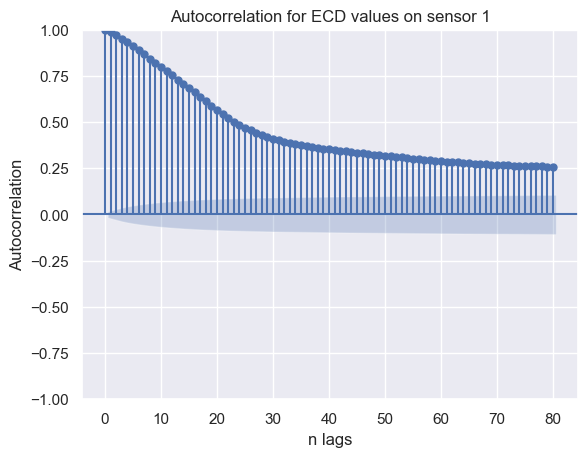

In [181]:

plot_acf(df_sensor["ASMECD1-T"].values, lags=80, ax = plt.gca())
plt.title(f'Autocorrelation for ECD values on sensor 1')
plt.xlabel("n lags")
plt.ylabel("Autocorrelation")

Text(0, 0.5, 'Autocorrelation')

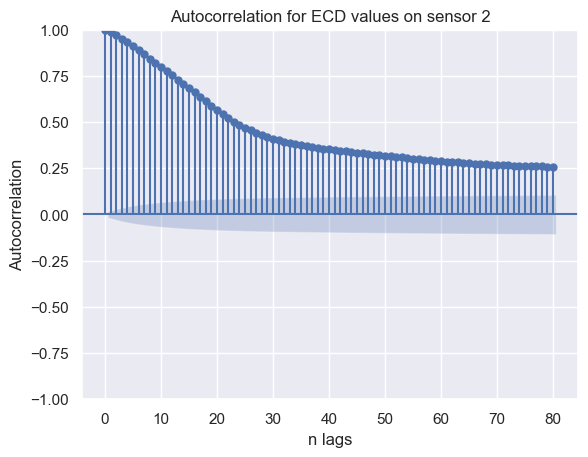

In [182]:
plot_acf(df_sensor["ASMECD1-T"].values, lags=80, ax = plt.gca())
plt.title(f'Autocorrelation for ECD values on sensor 2')
plt.xlabel("n lags")
plt.ylabel("Autocorrelation")

In [183]:
reg_1, reg_2, best_fit_1, best_fit_2,x_axis,variables_1,variables_2 = regression_for_asm_data_points(df_sensor["ASMECD1-T"].values,df_sensor["ASMECD2-T"].values,number_of_points_to_evaluate=30,idx = 13100, degree=1)

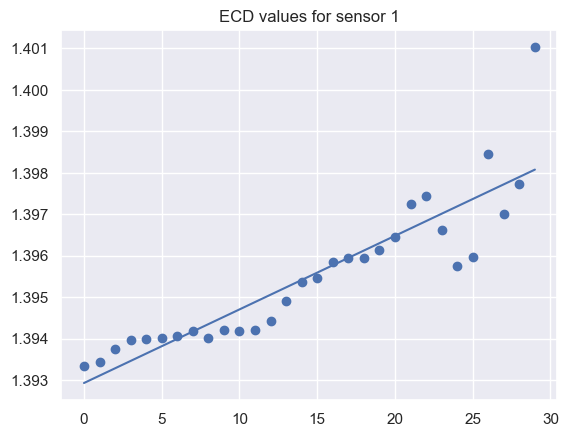

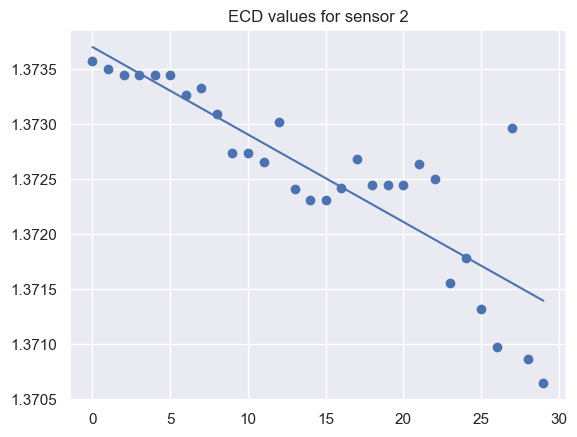

[1.77444097e-04 1.39293290e+00]


In [184]:
plt.title("ECD values for sensor 1")
plt.plot(x_axis,best_fit_1(x_axis))
plt.scatter(x_axis,variables_1)
plt.show()
plt.title("ECD values for sensor 2")
plt.plot(x_axis,best_fit_2(x_axis))
plt.scatter(x_axis,variables_2)
plt.show()
print(best_fit_1.c)

In [193]:
warnings_linreg = []
time_stamps_linreg = []
number_of_points = 20
for index in range(number_of_points,len(df_sensor)):
    reg_1, reg_2, best_fit_1, best_fit_2,x_axis,variables_1,variables_2 = regression_for_asm_data_points(df_sensor["ASMECD1-T"].values,df_sensor["ASMECD2-T"].values,number_of_points_to_evaluate=number_of_points,idx = index, degree=1)
    if reg_1[0] > .0002 and reg_2[0] < 0:
        warnings_linreg.append([df_sensor.index[index],index])

In [186]:

# plt.rcParams['text.usetex'] = True
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
# sns.set_theme()
# transients = []
# ecd_1_segments = []
# ecd_2_segments = []
# ecd_1_segments_sim = []
# ecd_2_segments_sim = []
# window_size = 20
# indices = [element[1] for element in warnings_linreg]

# for index in indices:
#     transients.append([df_sensor.index[index], index])
#     ecd_1_segments.append(df_sensor["ASMECD1-T"].iloc[index - window_size:index + window_size].values)
#     ecd_2_segments.append(df_sensor["ASMECD2-T"].iloc[index - window_size:index + window_size].values)
#     ecd_1_segments_sim.append(df_simulated["ecdAtPos2"].iloc[index - window_size:index + window_size].values)
#     ecd_2_segments_sim.append(df_simulated["ecdAtPos3"].iloc[index - window_size:index + window_size].values)

In [187]:
# for segment_ecd_1, segment_ecd_2, segment_ecd_1_sim, segment_ecd_2_sim, transient in zip(ecd_1_segments, ecd_2_segments, ecd_1_segments_sim, ecd_2_segments_sim, transients):
#     plt.title(f"Transient segment around timestamp {transient[0]} with index {transient[1]}")
#     plt.plot(segment_ecd_1, label = "ASM 1")
#     plt.plot(segment_ecd_2, label = "ASM 2")
#     plt.plot(segment_ecd_1_sim, label = "HFM 1")
#     plt.plot(segment_ecd_2_sim, label = "HFM 2")
#     plt.ylabel(r'$\text{gcm}^{-3}$')
#     plt.legend()
#     plt.show()

In [194]:
# 10949, 11909, 12382, 12422, 12907, 13106, 13566,13623 indices where the algorithm raised warnings
print(warnings_linreg)
print(len(warnings_linreg))

[['2020-08-17 19:06:20+00:00', 31], ['2020-08-17 19:06:30+00:00', 32], ['2020-08-17 19:06:40+00:00', 33], ['2020-08-17 19:06:50+00:00', 34], ['2020-08-17 19:07:00+00:00', 35], ['2020-08-18 00:32:50+00:00', 1990], ['2020-08-18 01:51:40+00:00', 2463], ['2020-08-18 01:51:50+00:00', 2464], ['2020-08-18 01:52:00+00:00', 2465], ['2020-08-18 02:10:20+00:00', 2575], ['2020-08-18 02:10:30+00:00', 2576], ['2020-08-18 02:10:40+00:00', 2577], ['2020-08-18 02:10:50+00:00', 2578], ['2020-08-18 02:11:00+00:00', 2579], ['2020-08-18 02:11:10+00:00', 2580], ['2020-08-18 02:11:20+00:00', 2581], ['2020-08-18 03:32:00+00:00', 3065], ['2020-08-18 03:32:10+00:00', 3066], ['2020-08-18 03:42:10+00:00', 3126], ['2020-08-18 03:42:20+00:00', 3127], ['2020-08-18 03:42:30+00:00', 3128], ['2020-08-18 04:31:00+00:00', 3419], ['2020-08-18 04:31:10+00:00', 3420], ['2020-08-18 04:31:20+00:00', 3421], ['2020-08-18 04:31:30+00:00', 3422], ['2020-08-18 05:01:50+00:00', 3604], ['2020-08-18 06:43:20+00:00', 4213], ['2020-08-

c:\Users\thomaswi\OneDrive - SINTEF\Drilling and well\Code\CodeForMaster\utils\utils\utils.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(8,figsize = (20,20))


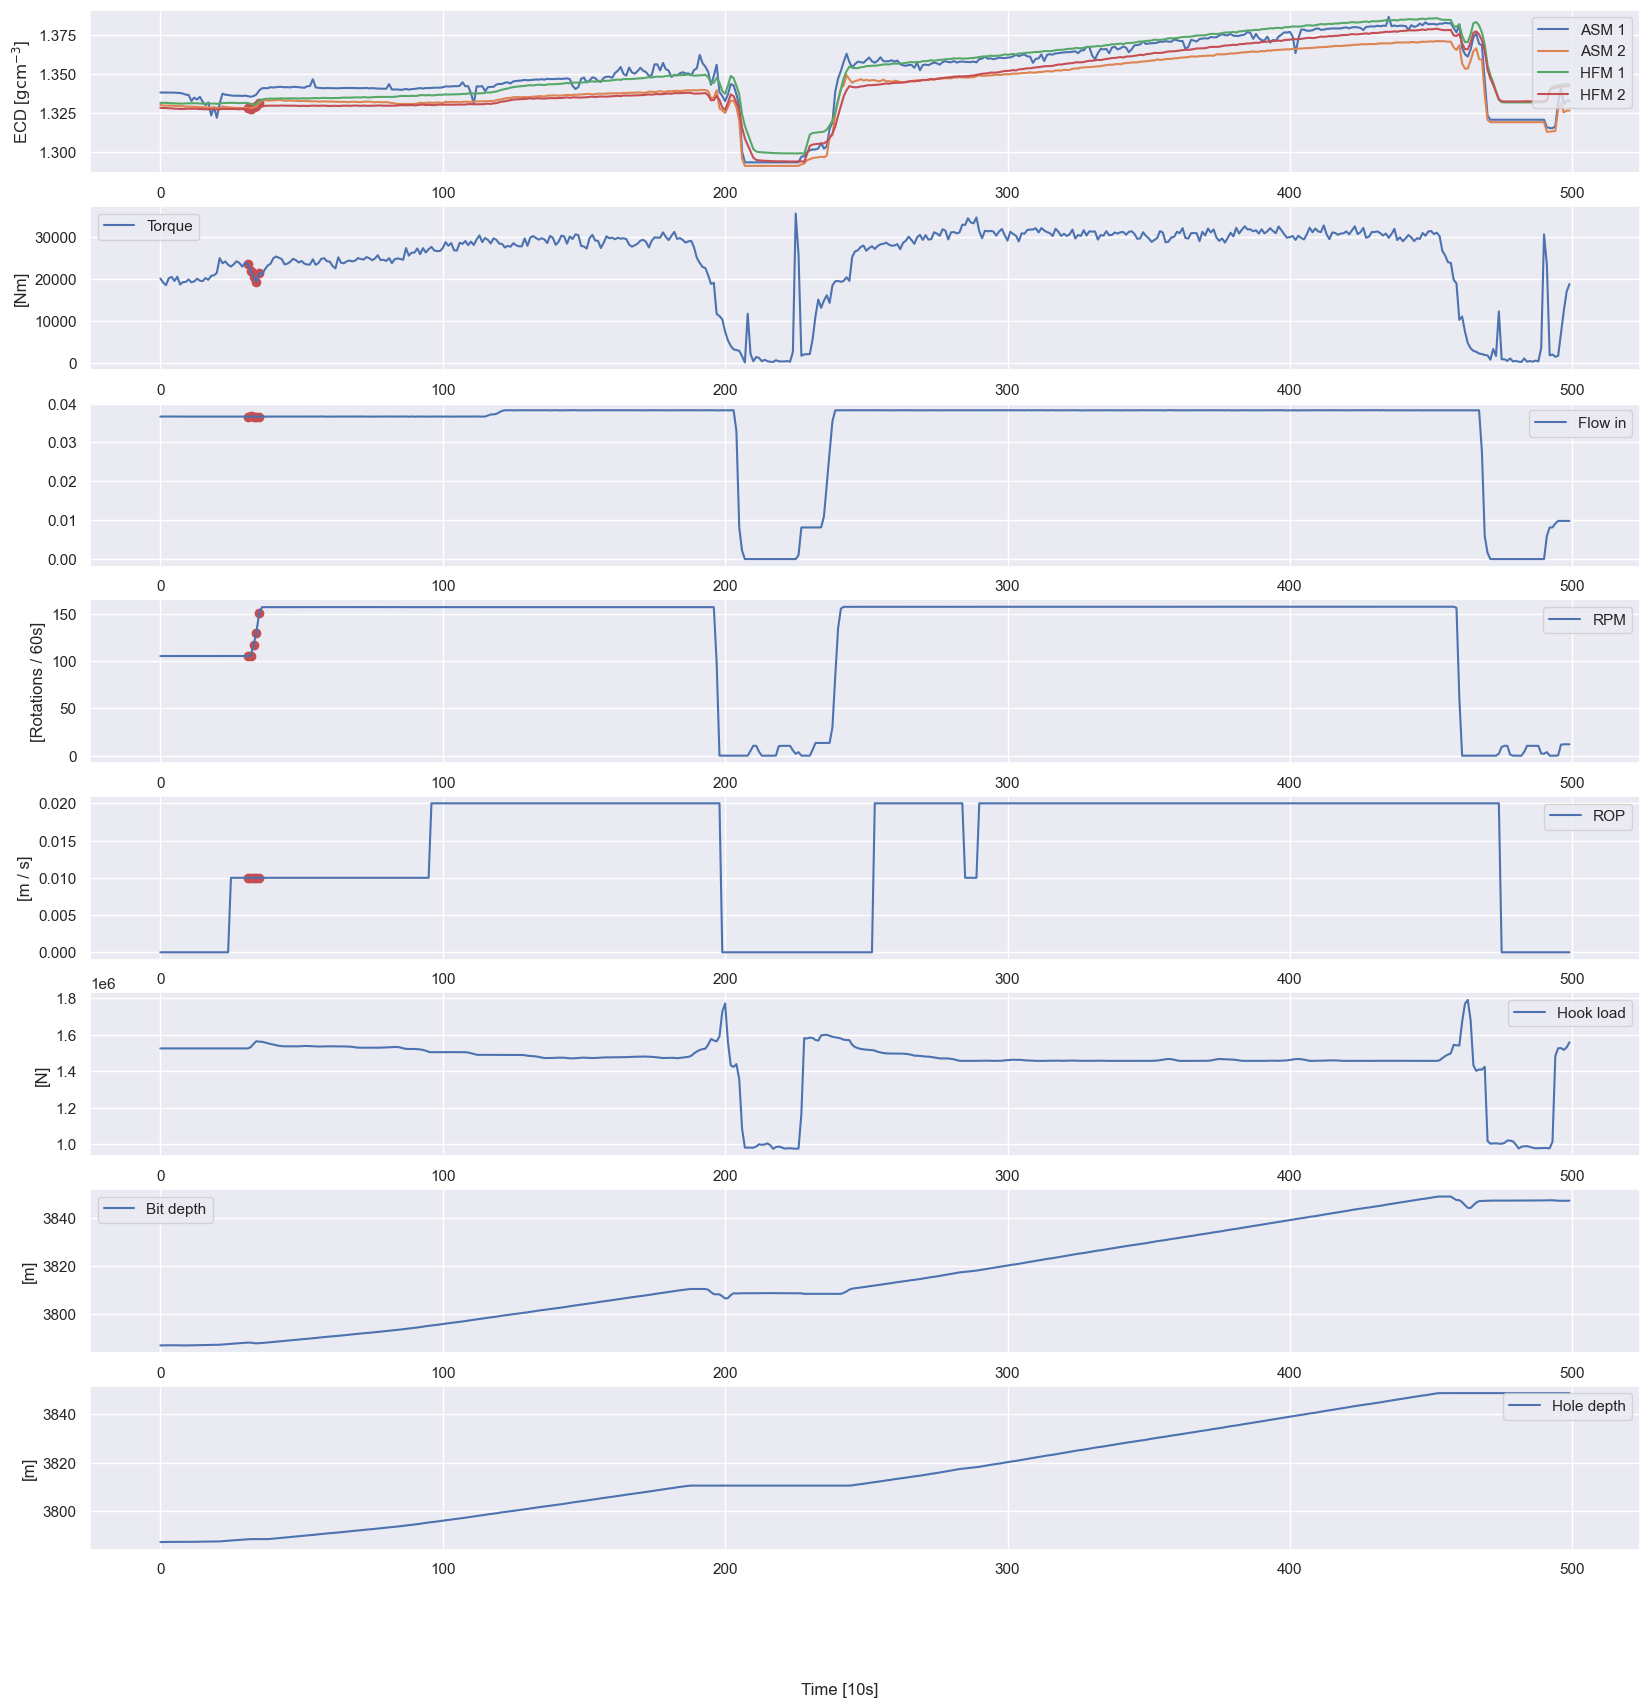

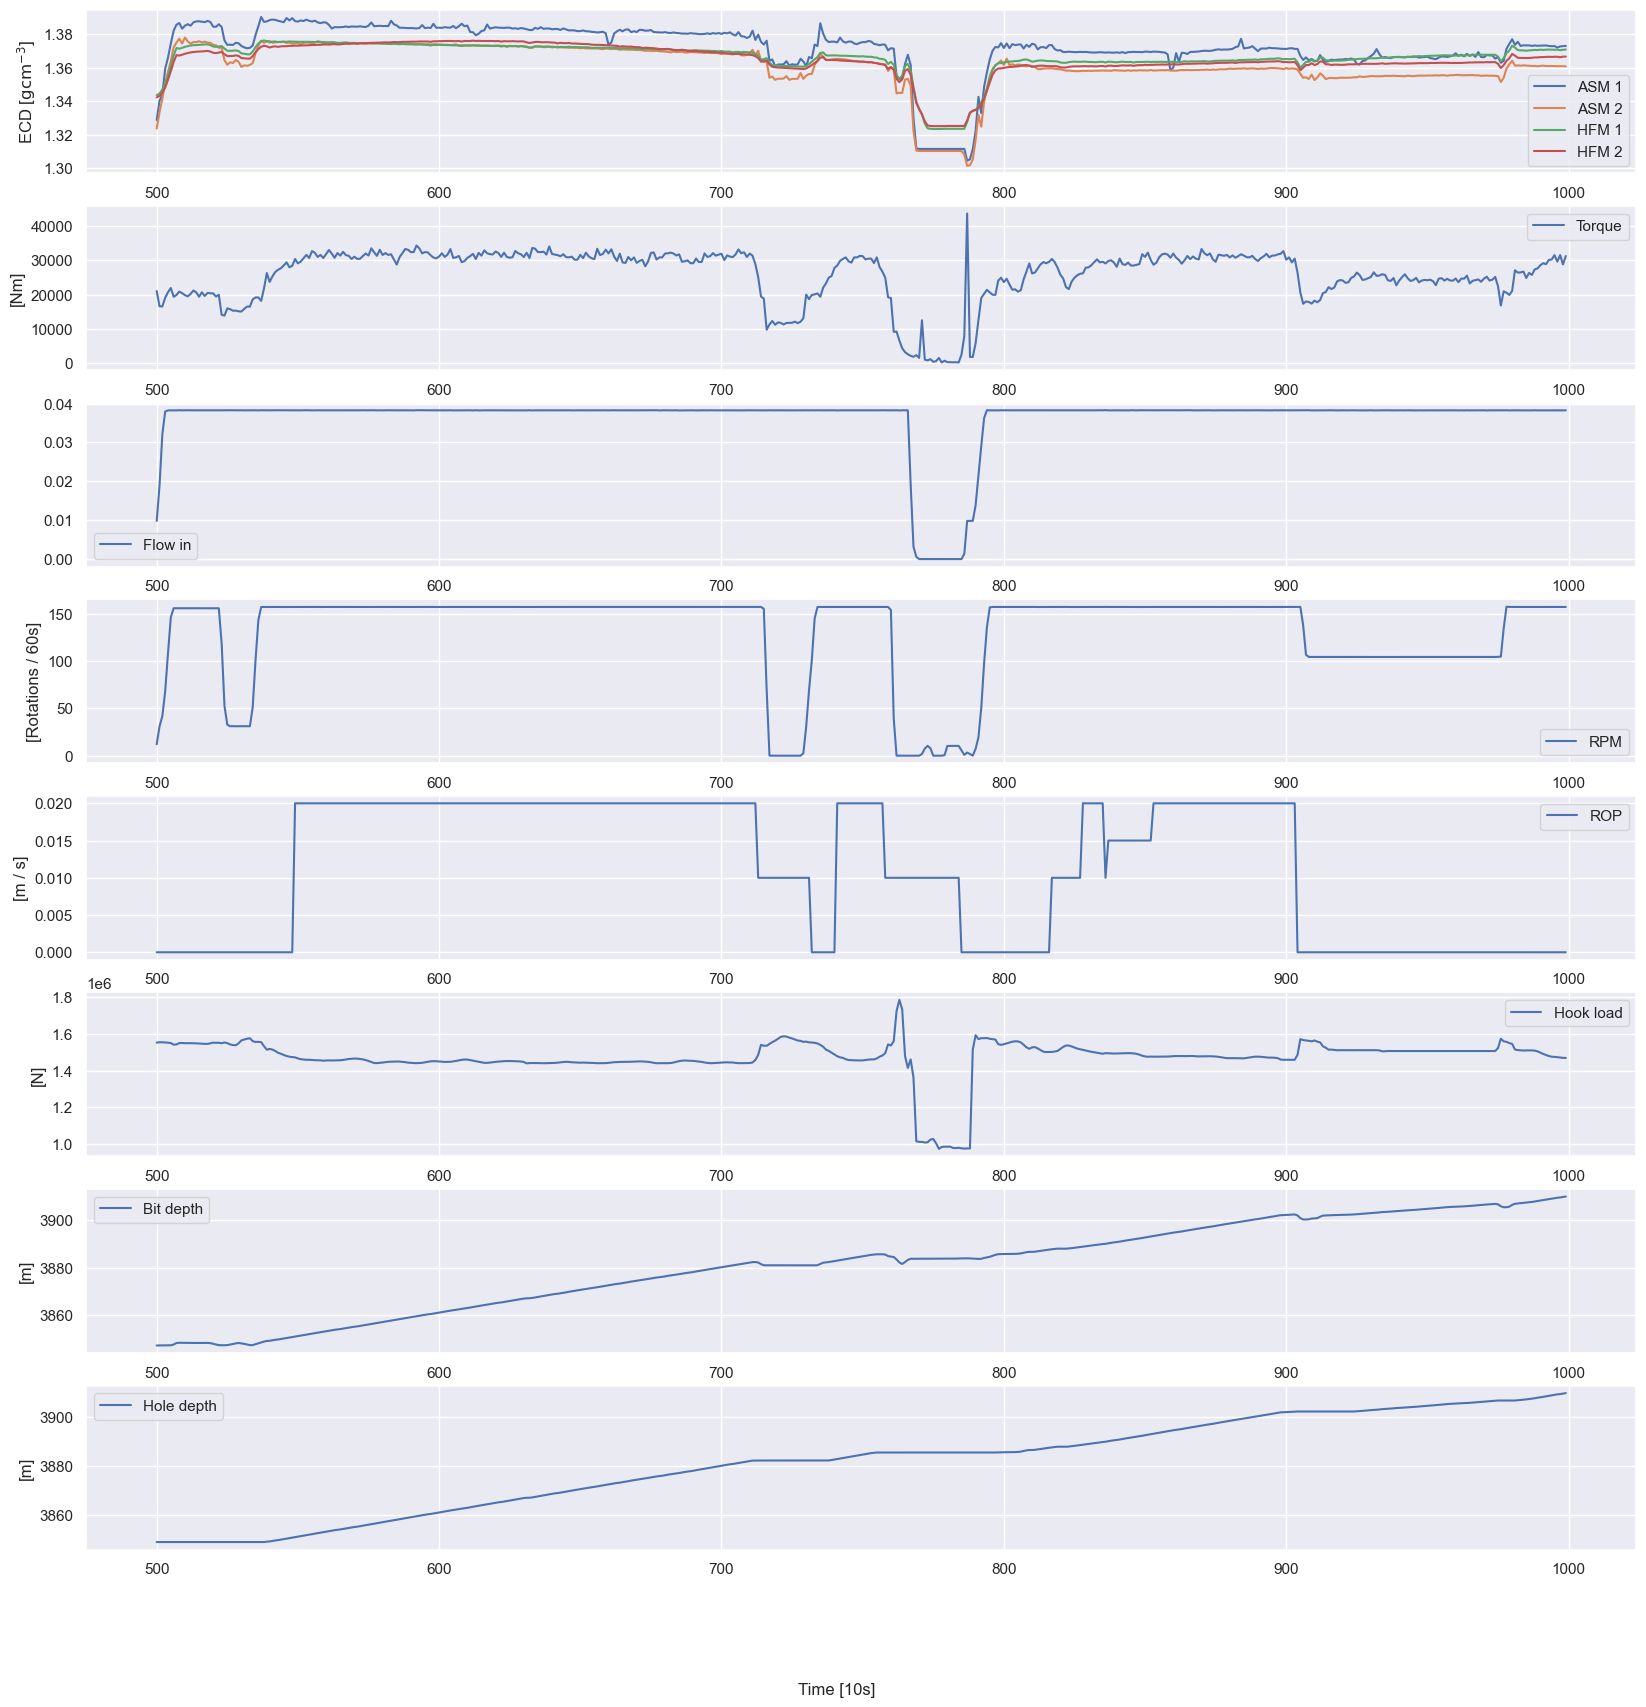

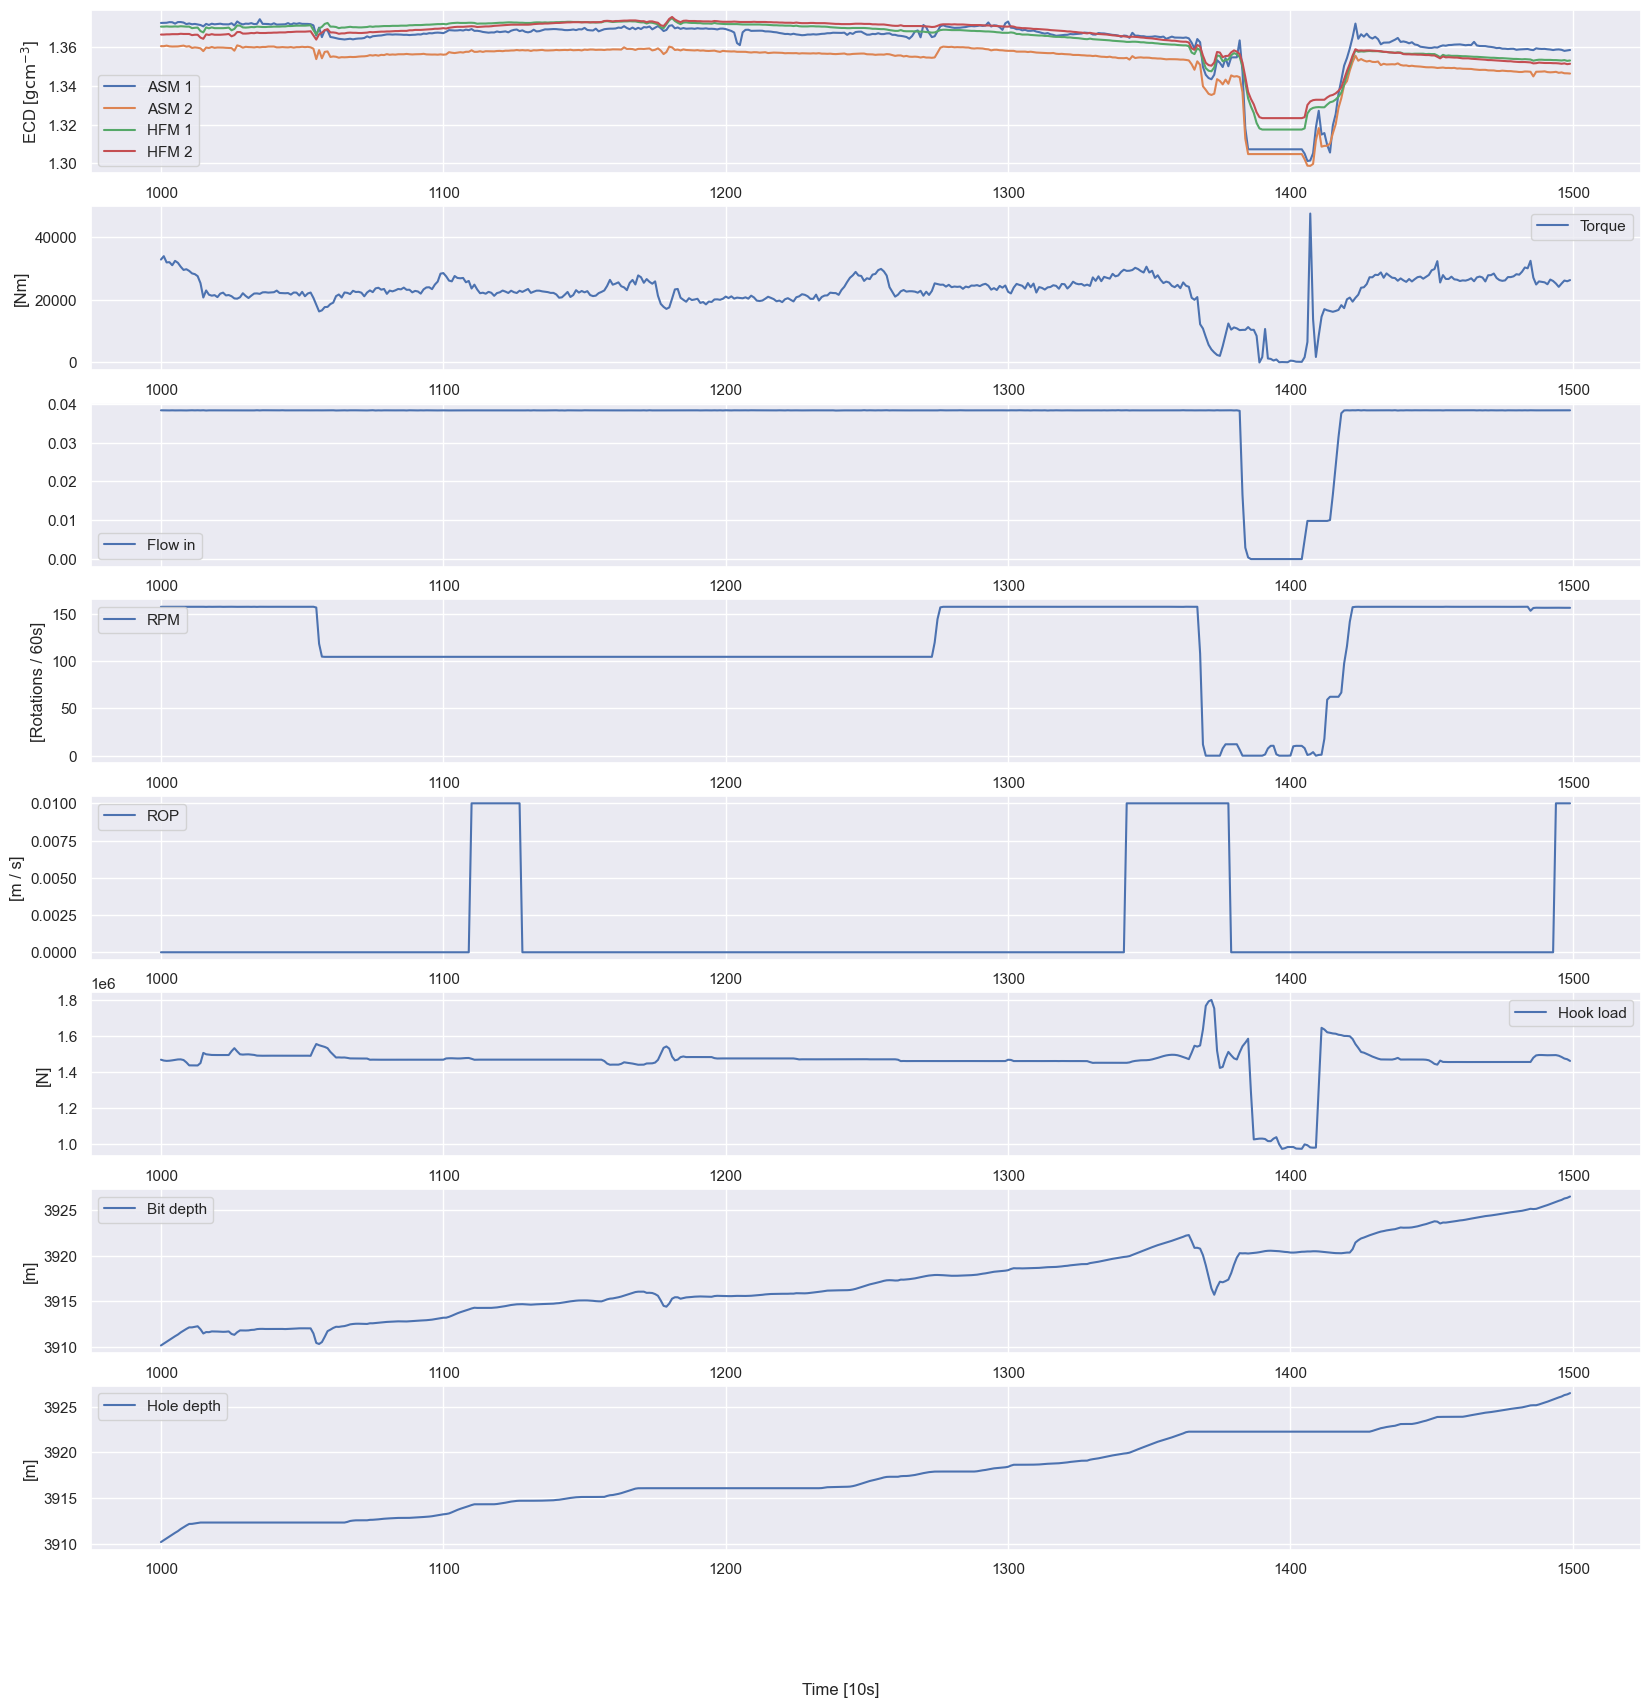

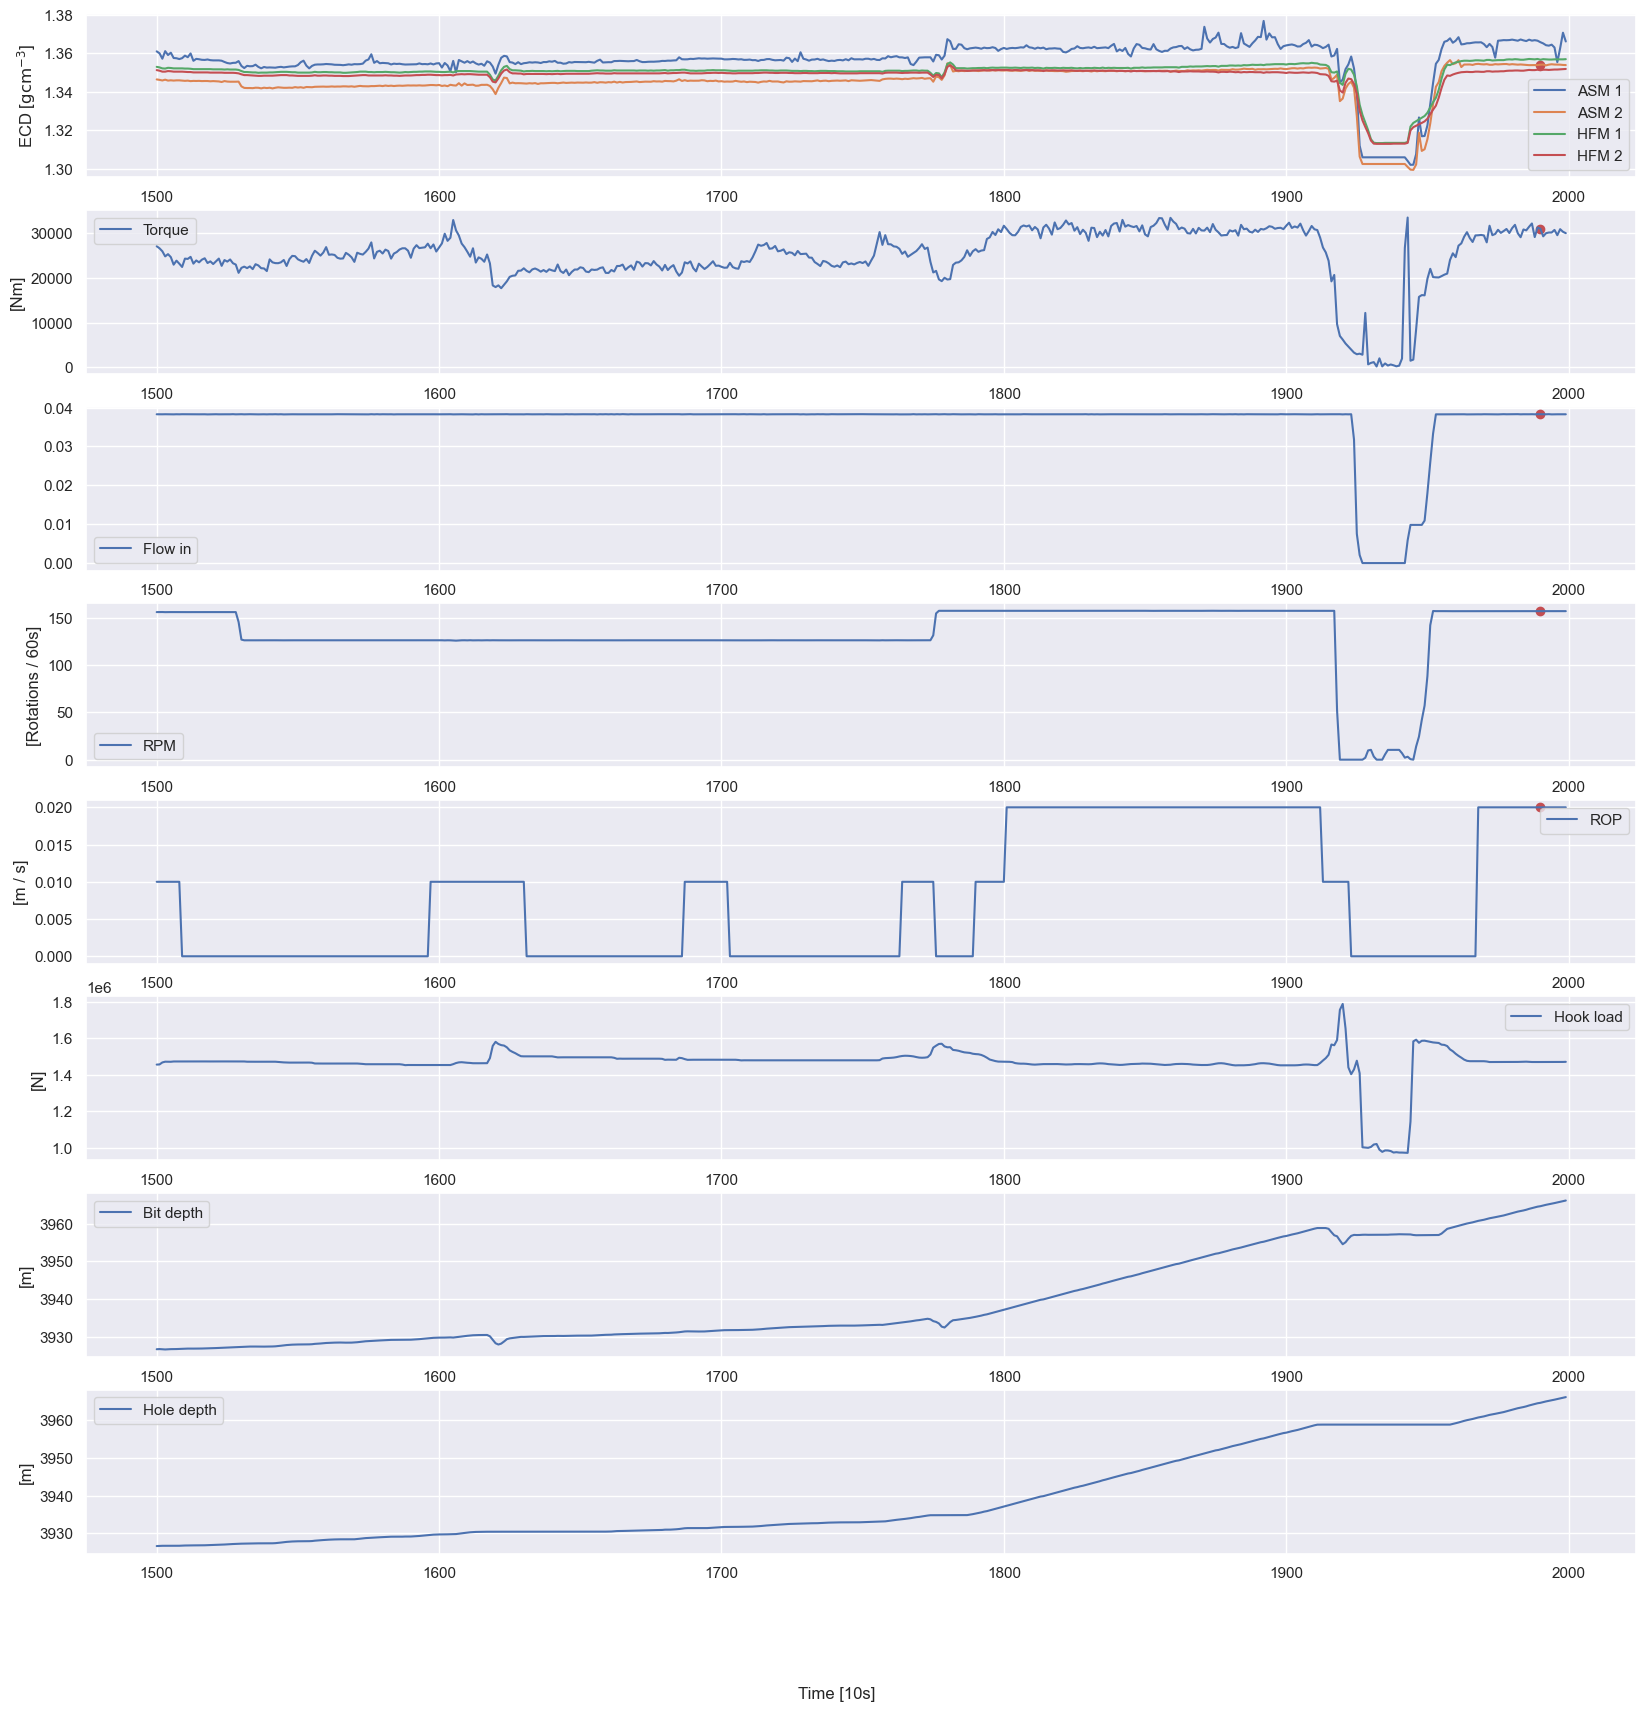

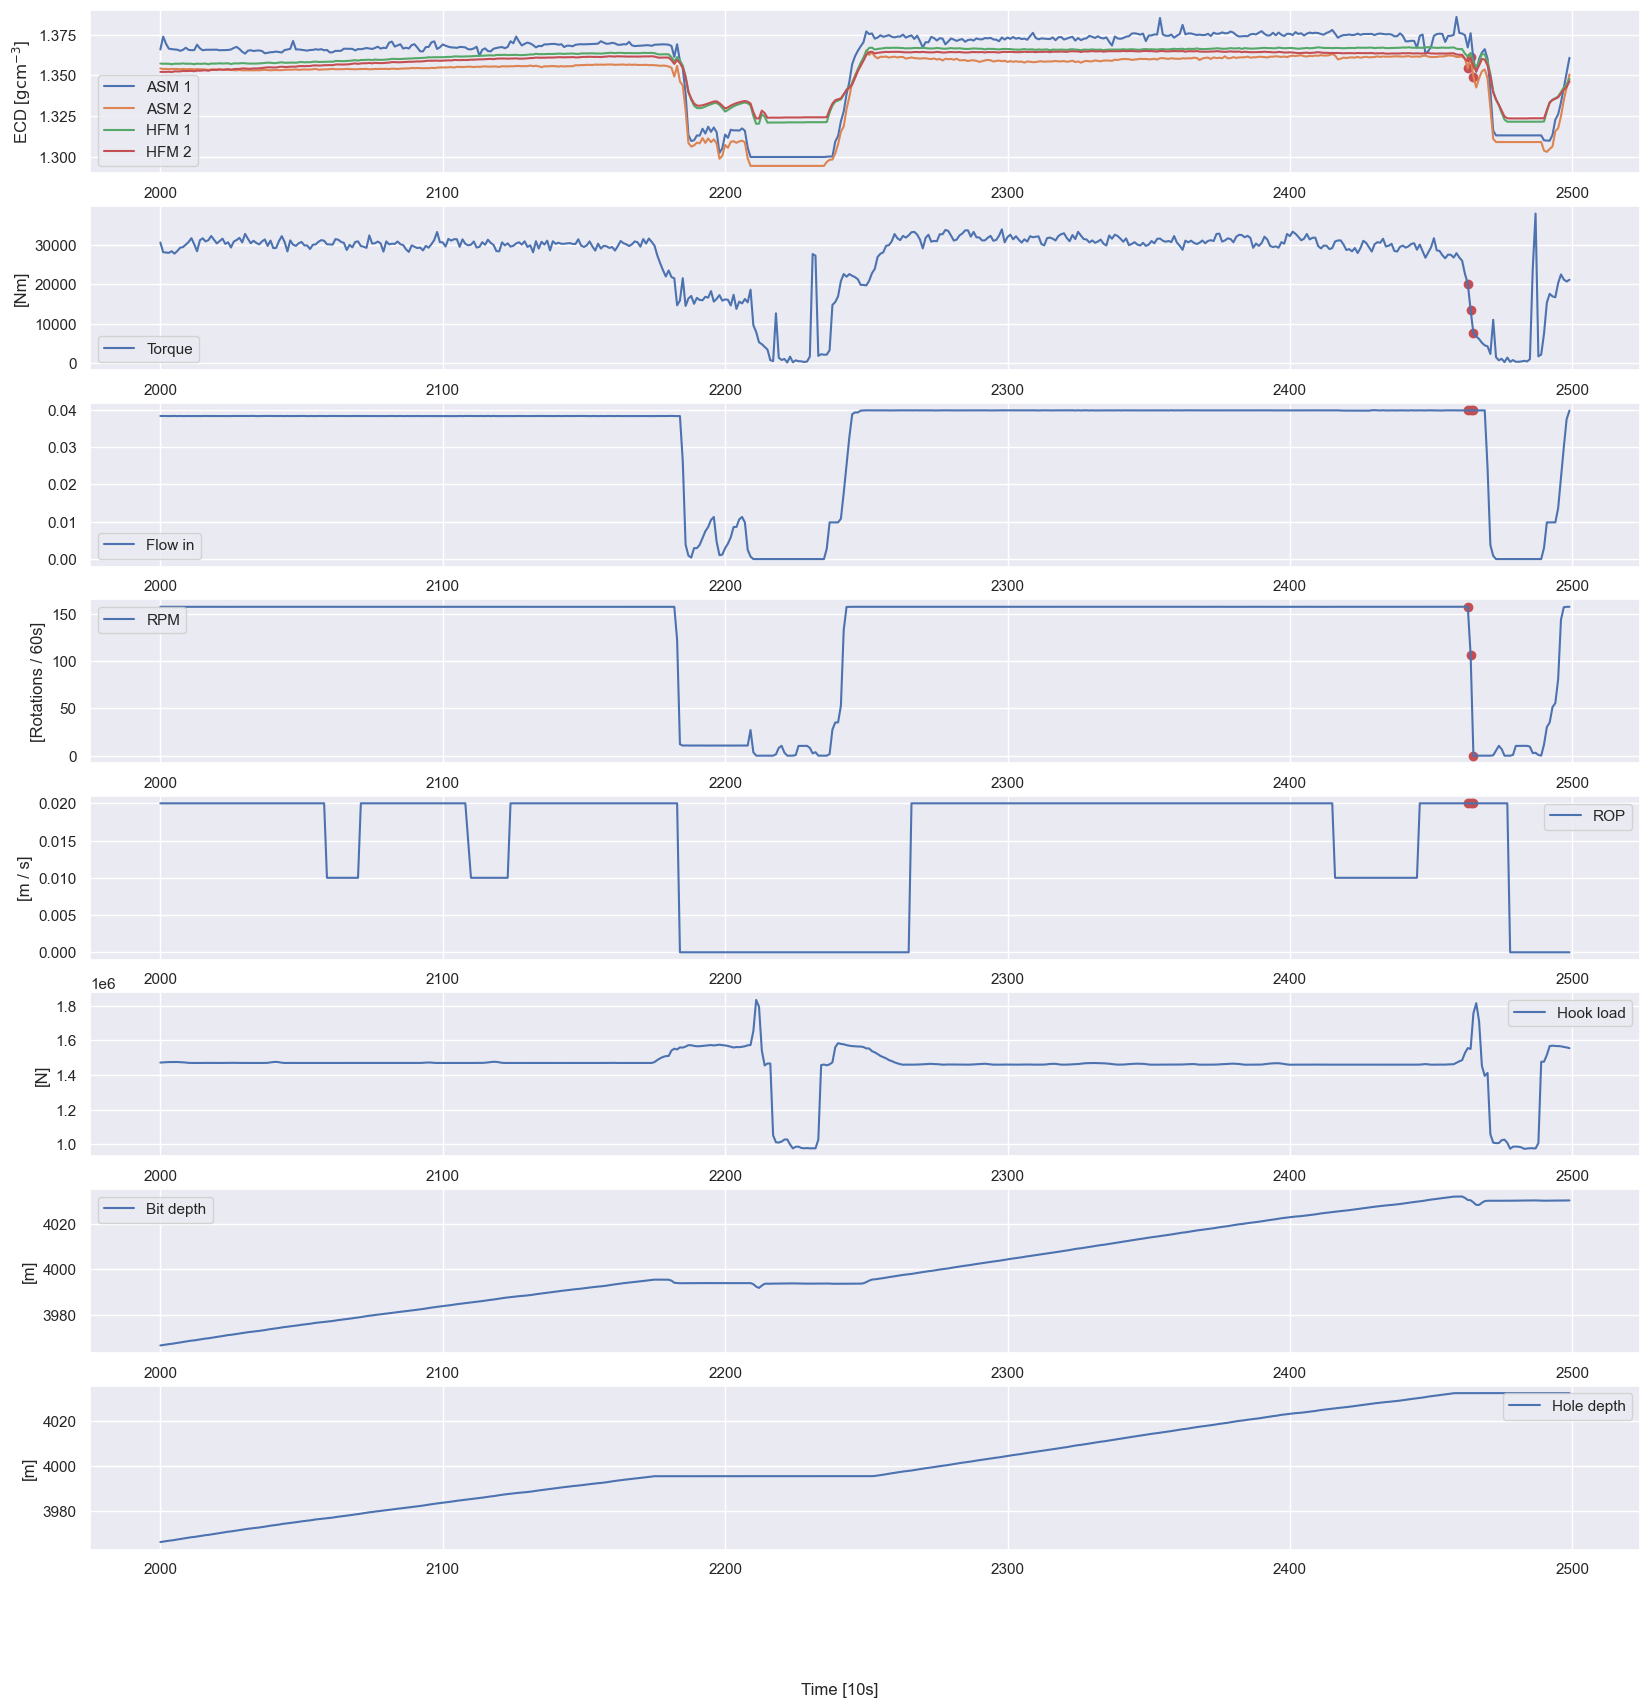

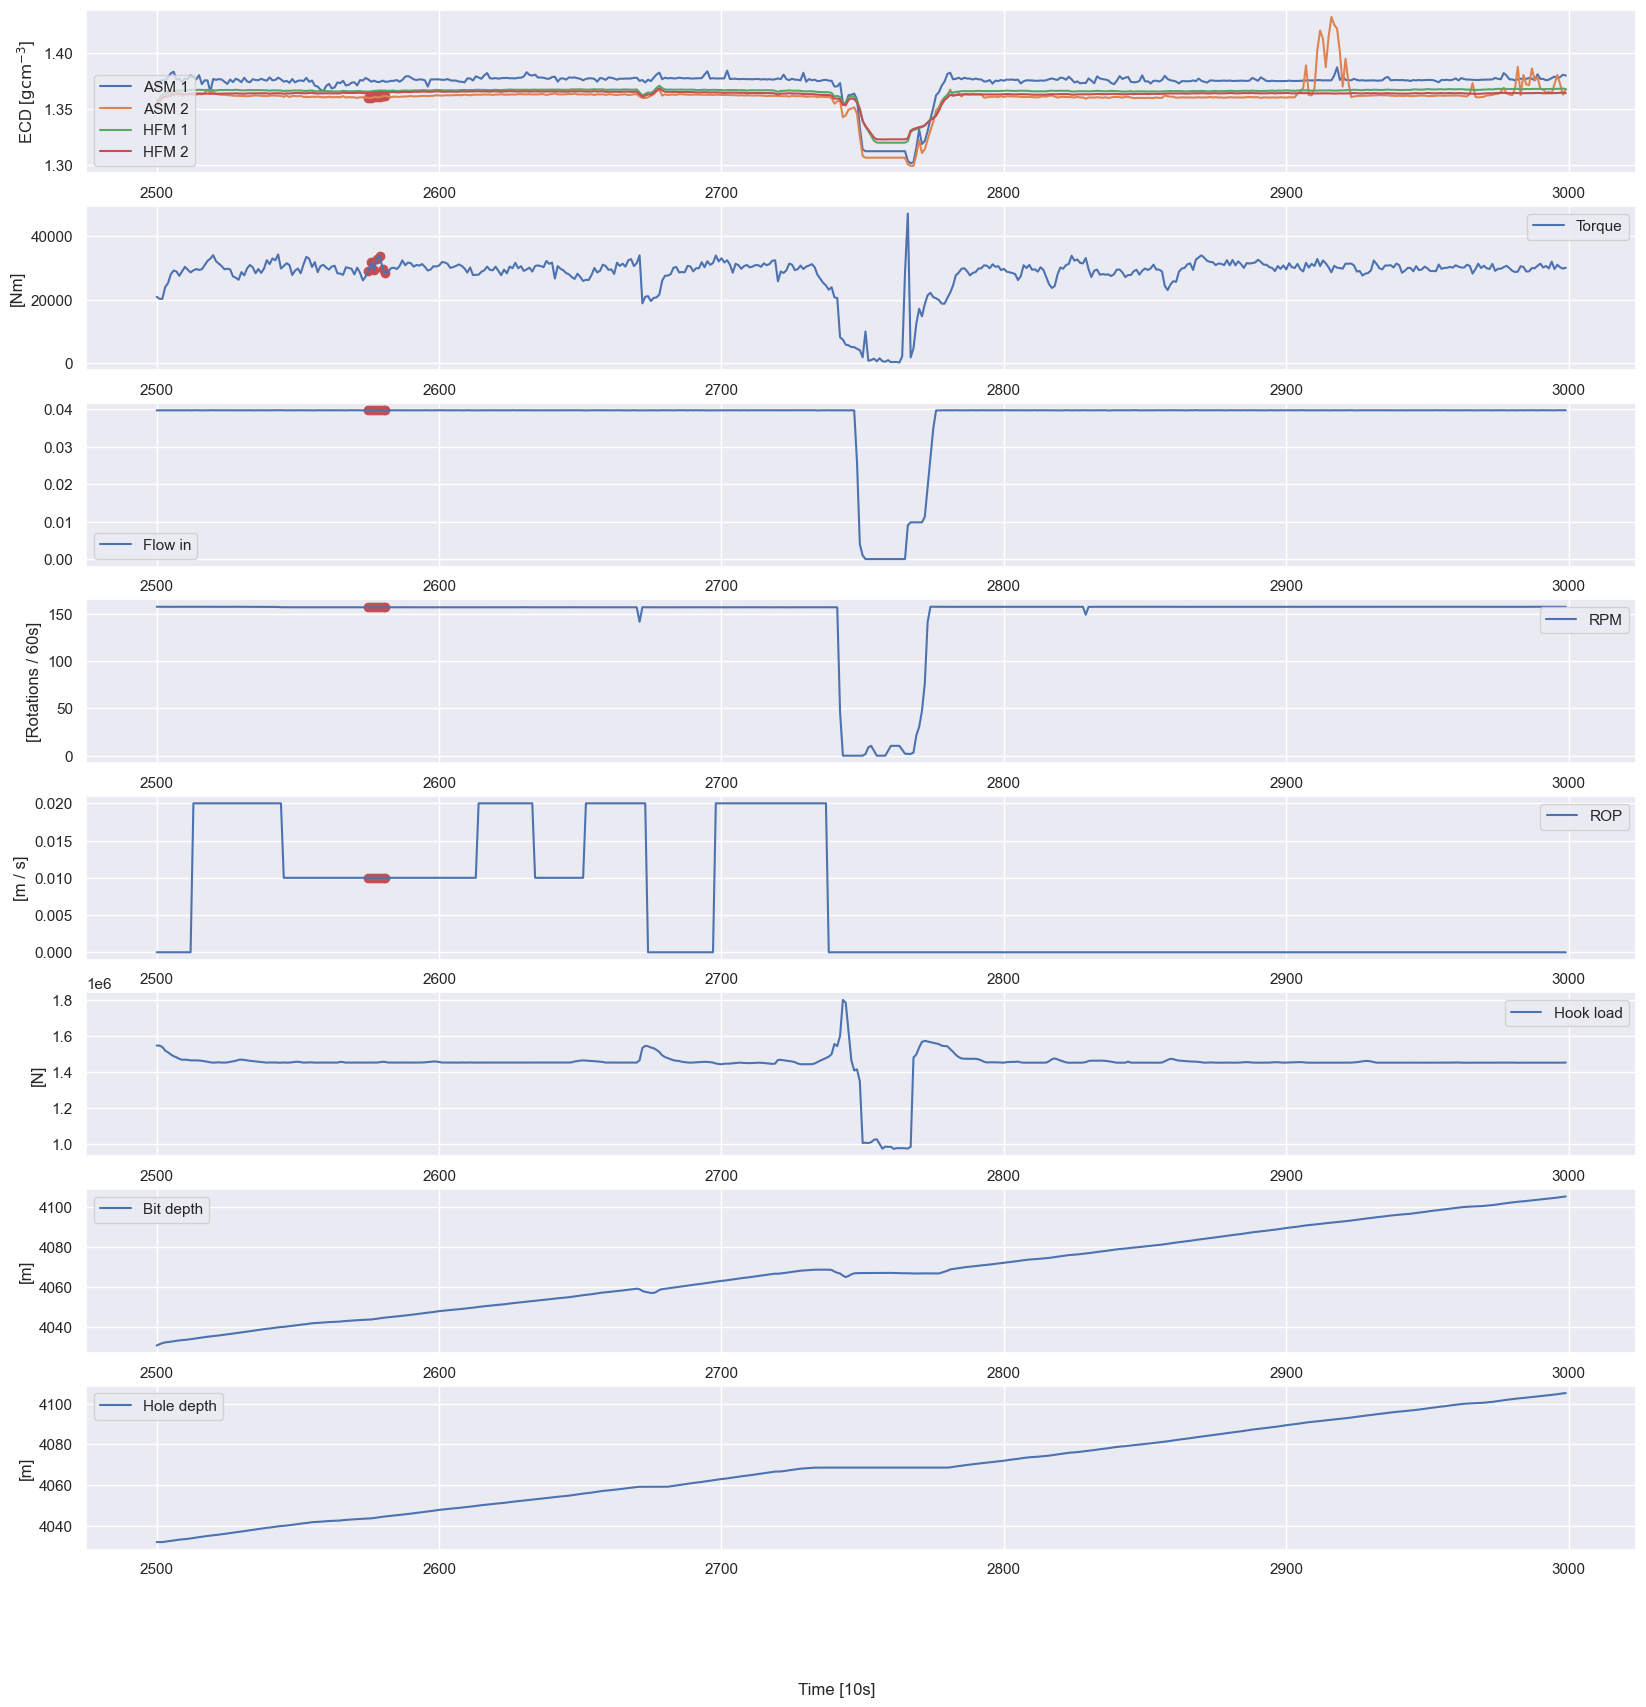

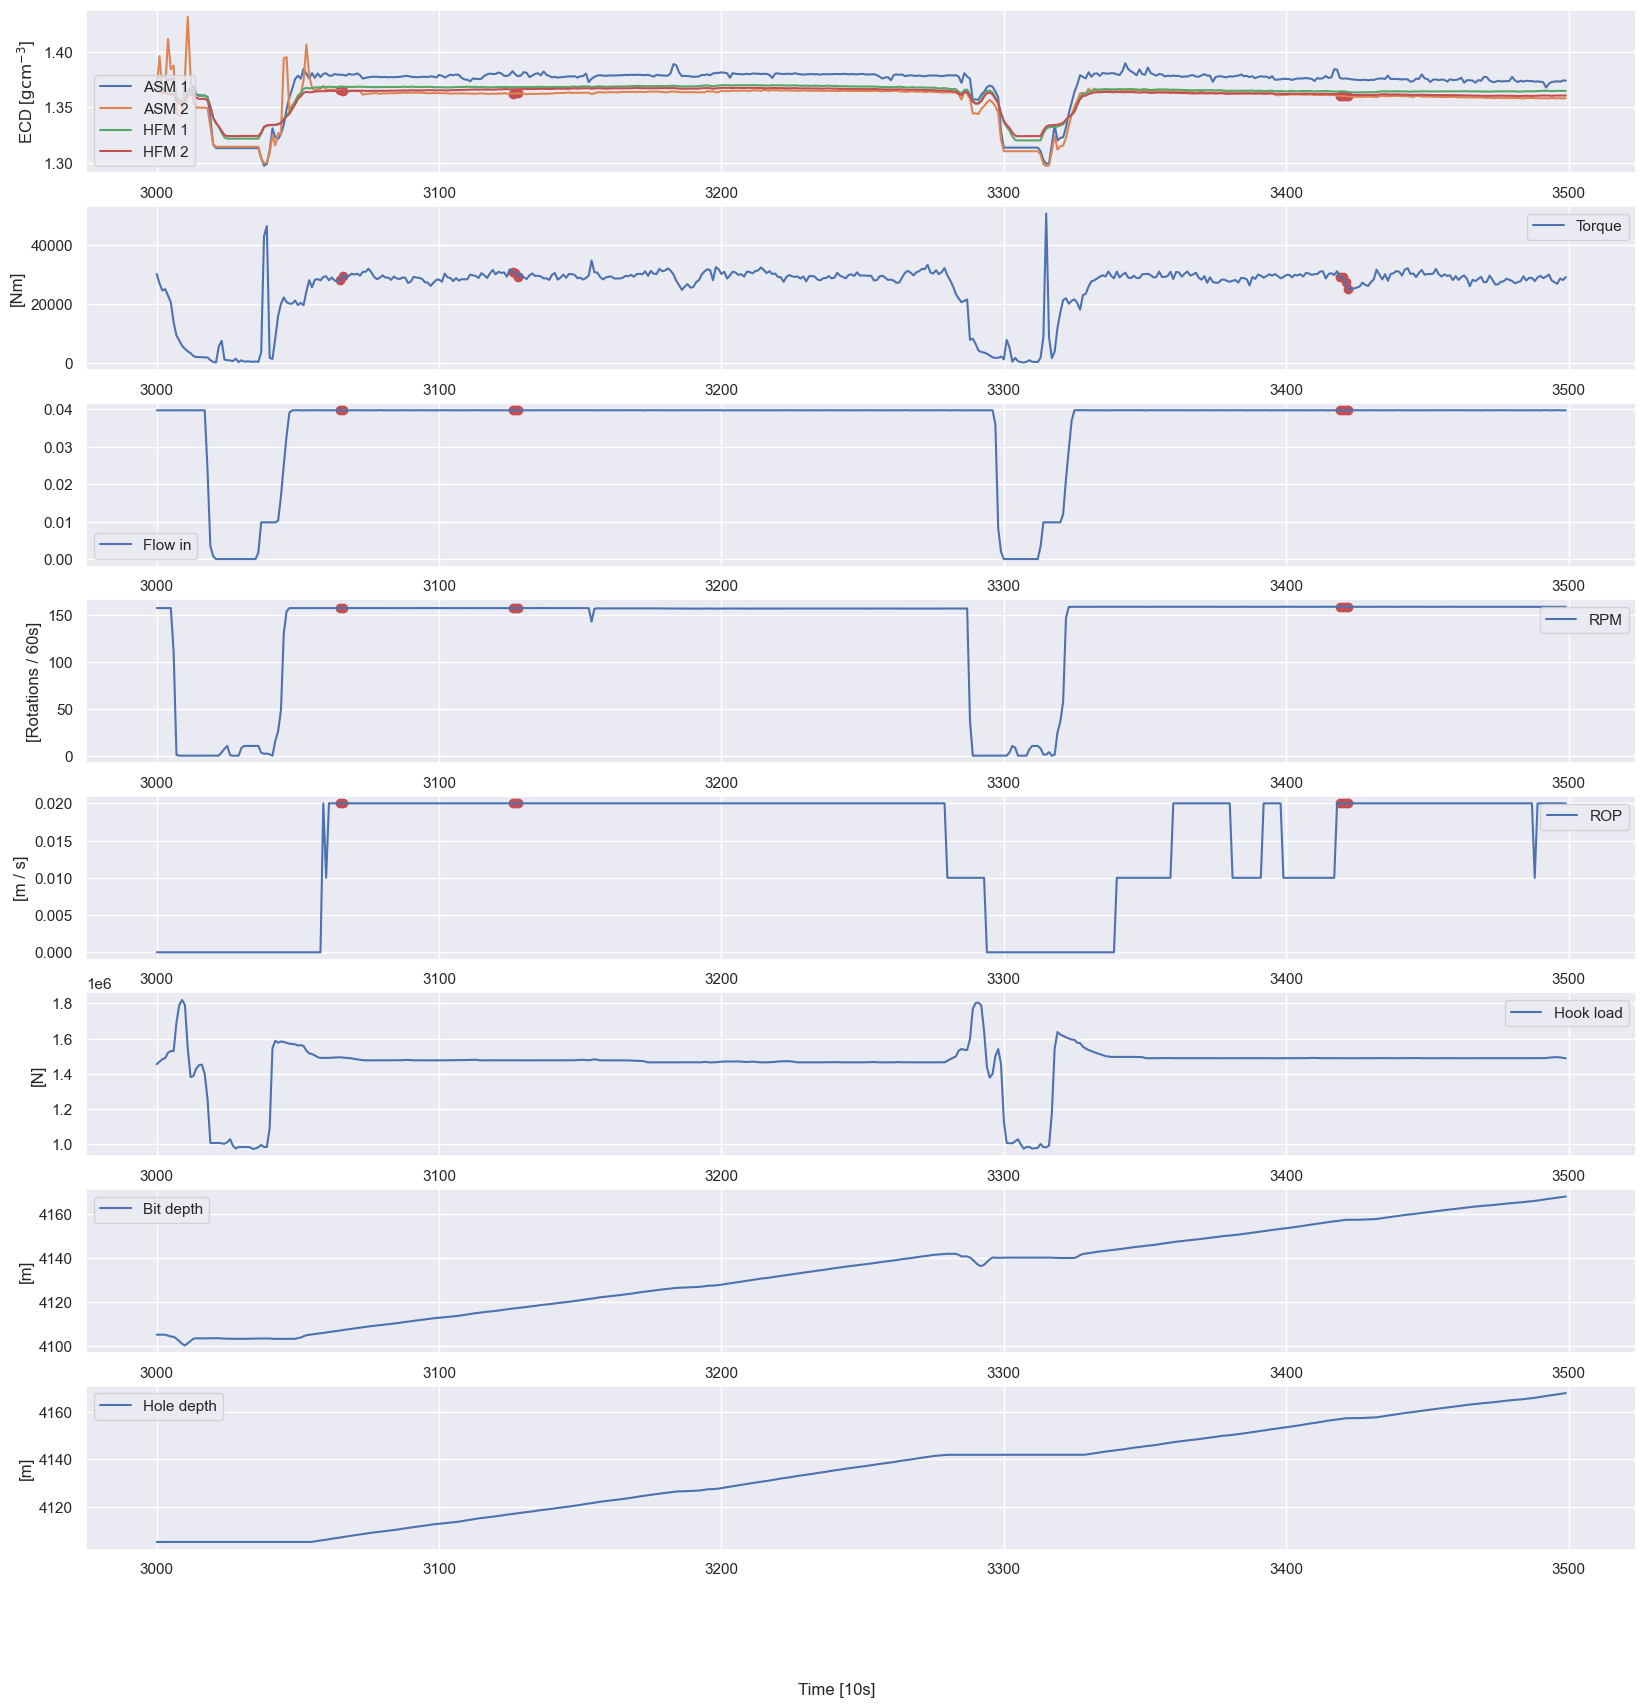

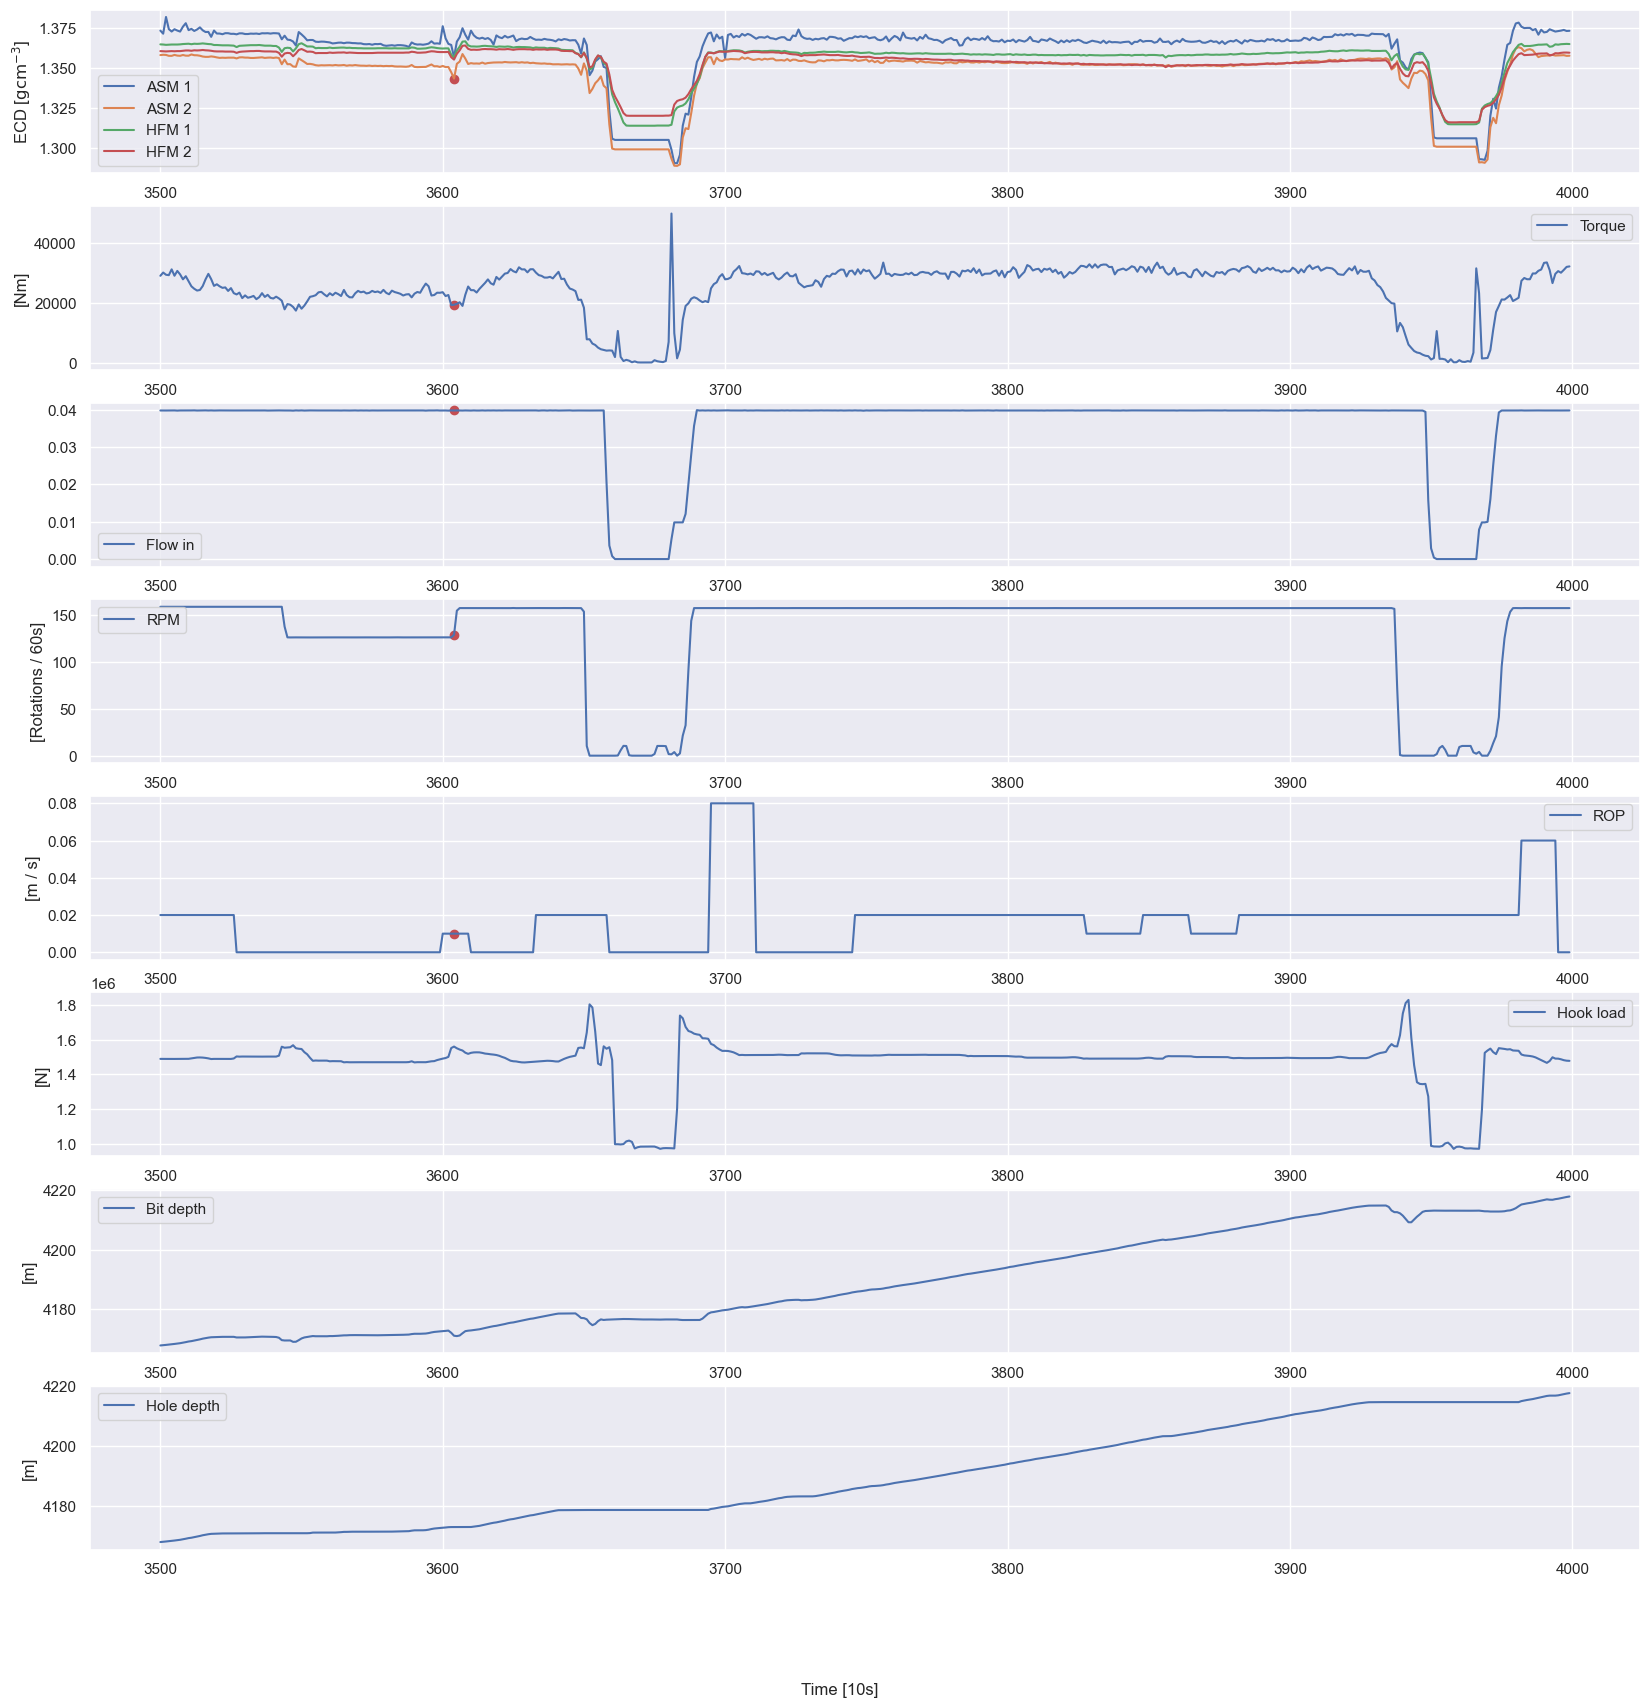

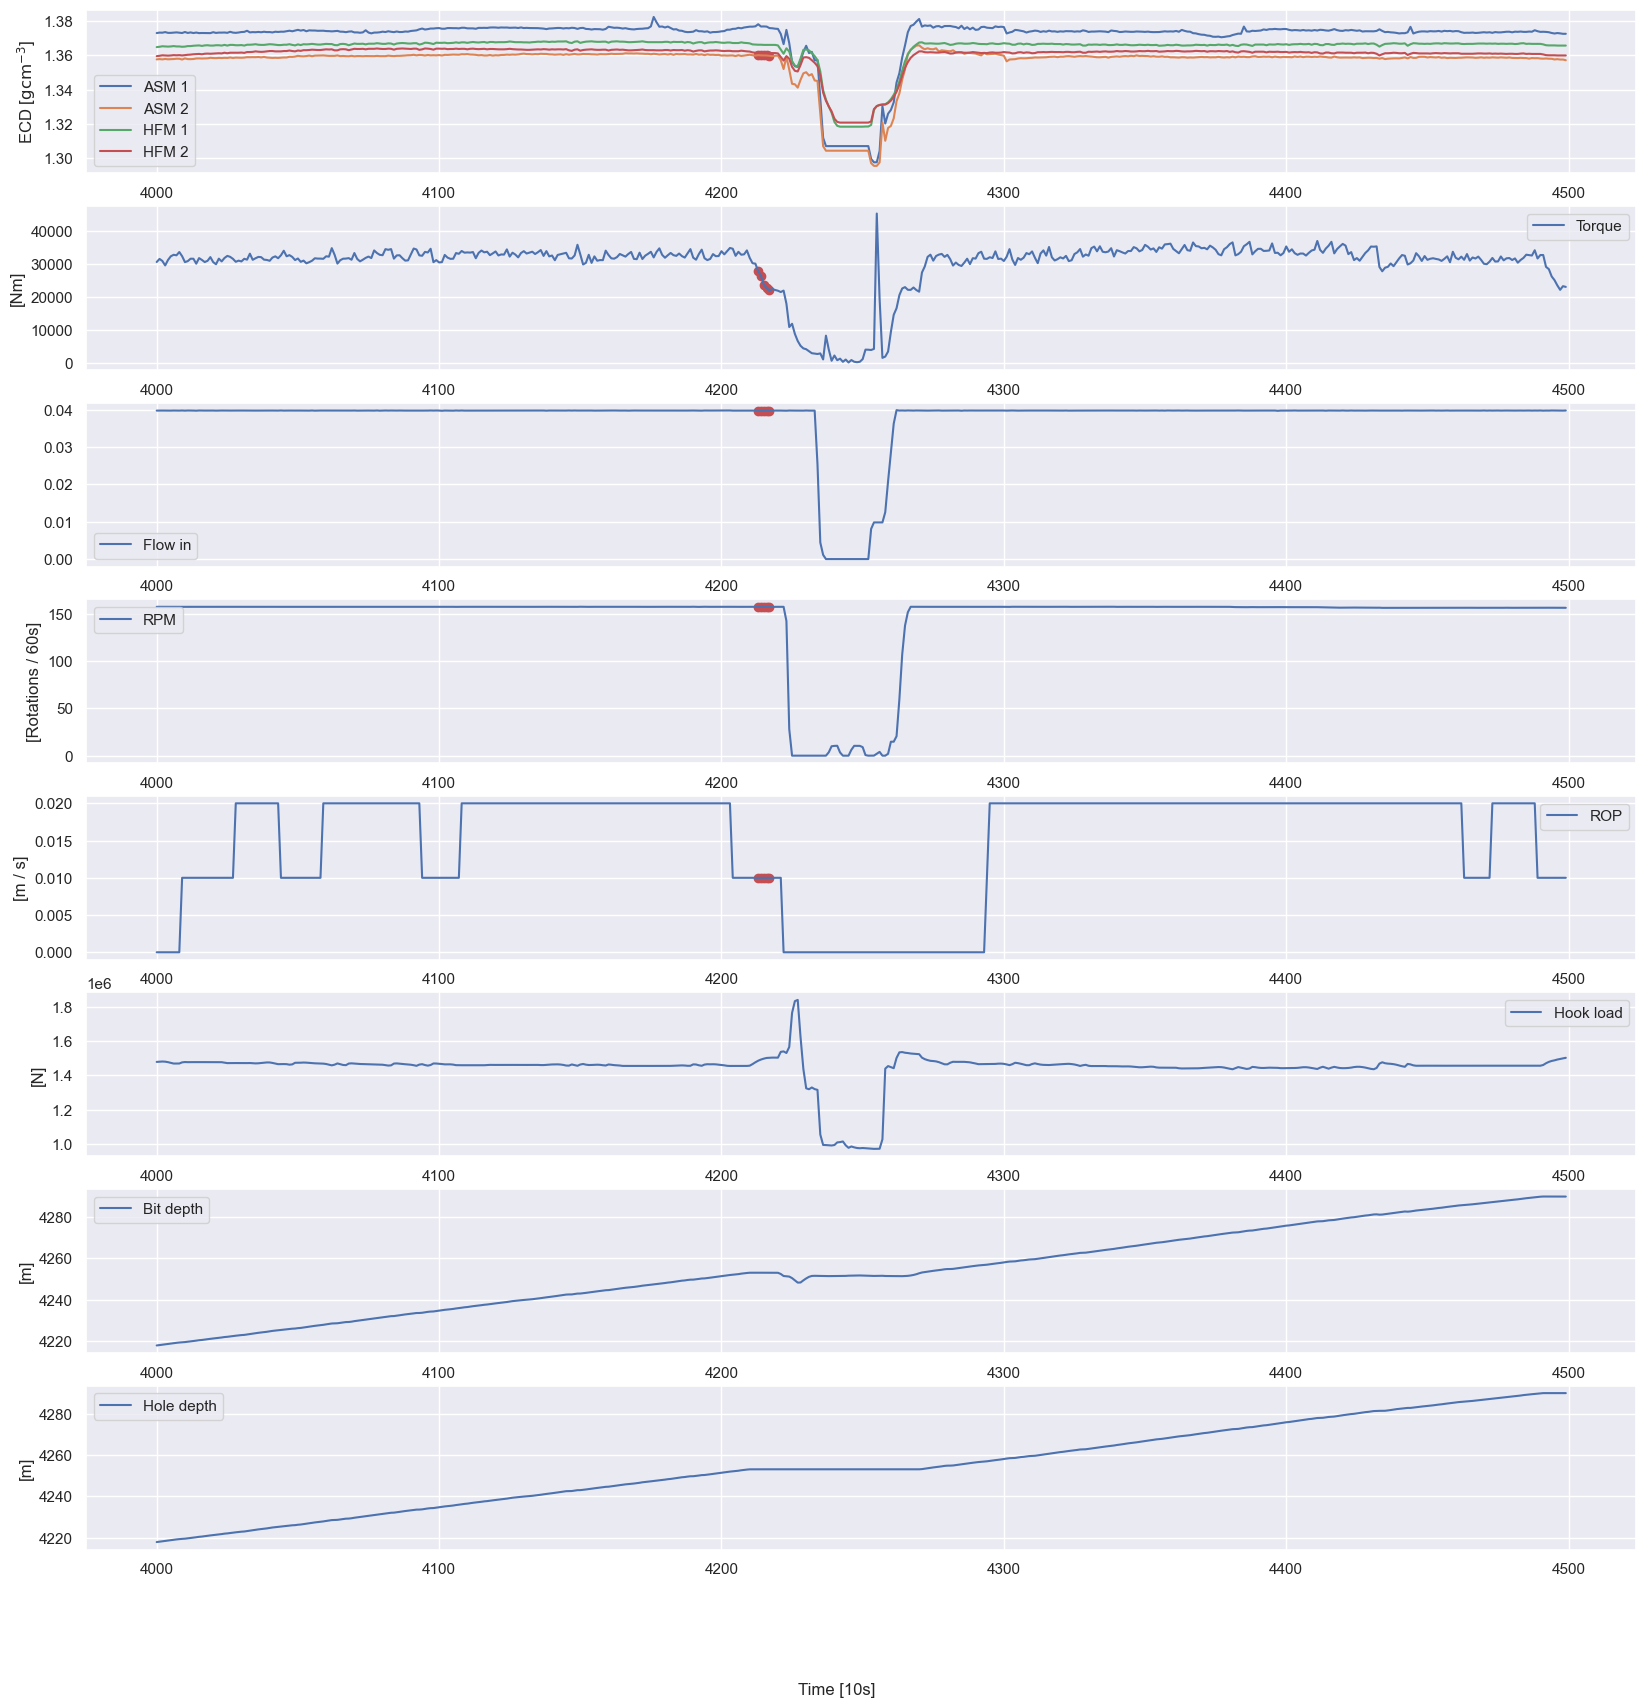

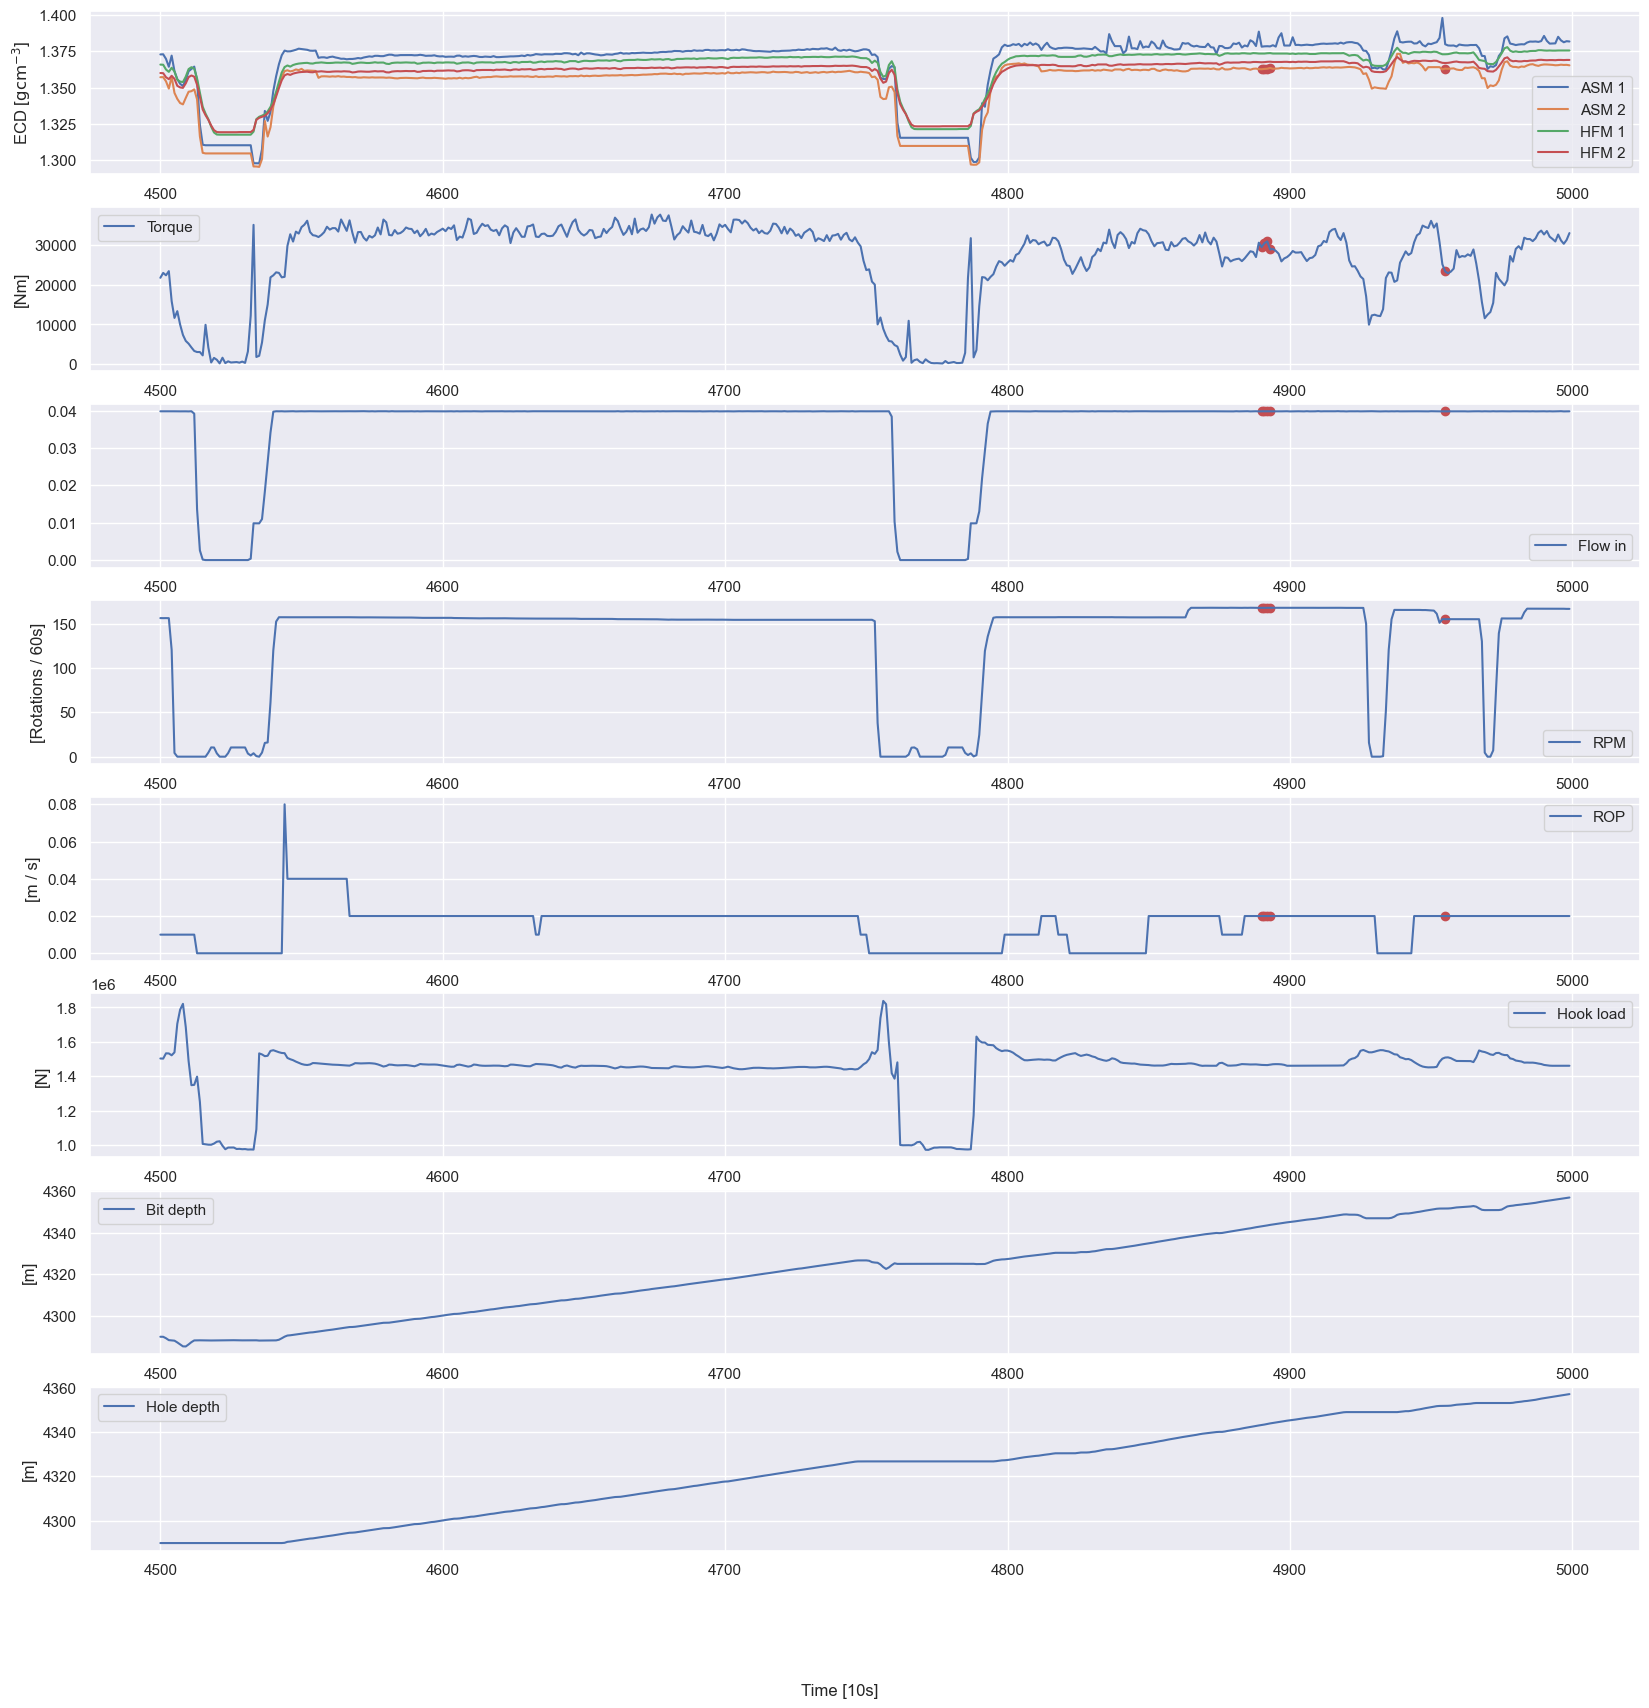

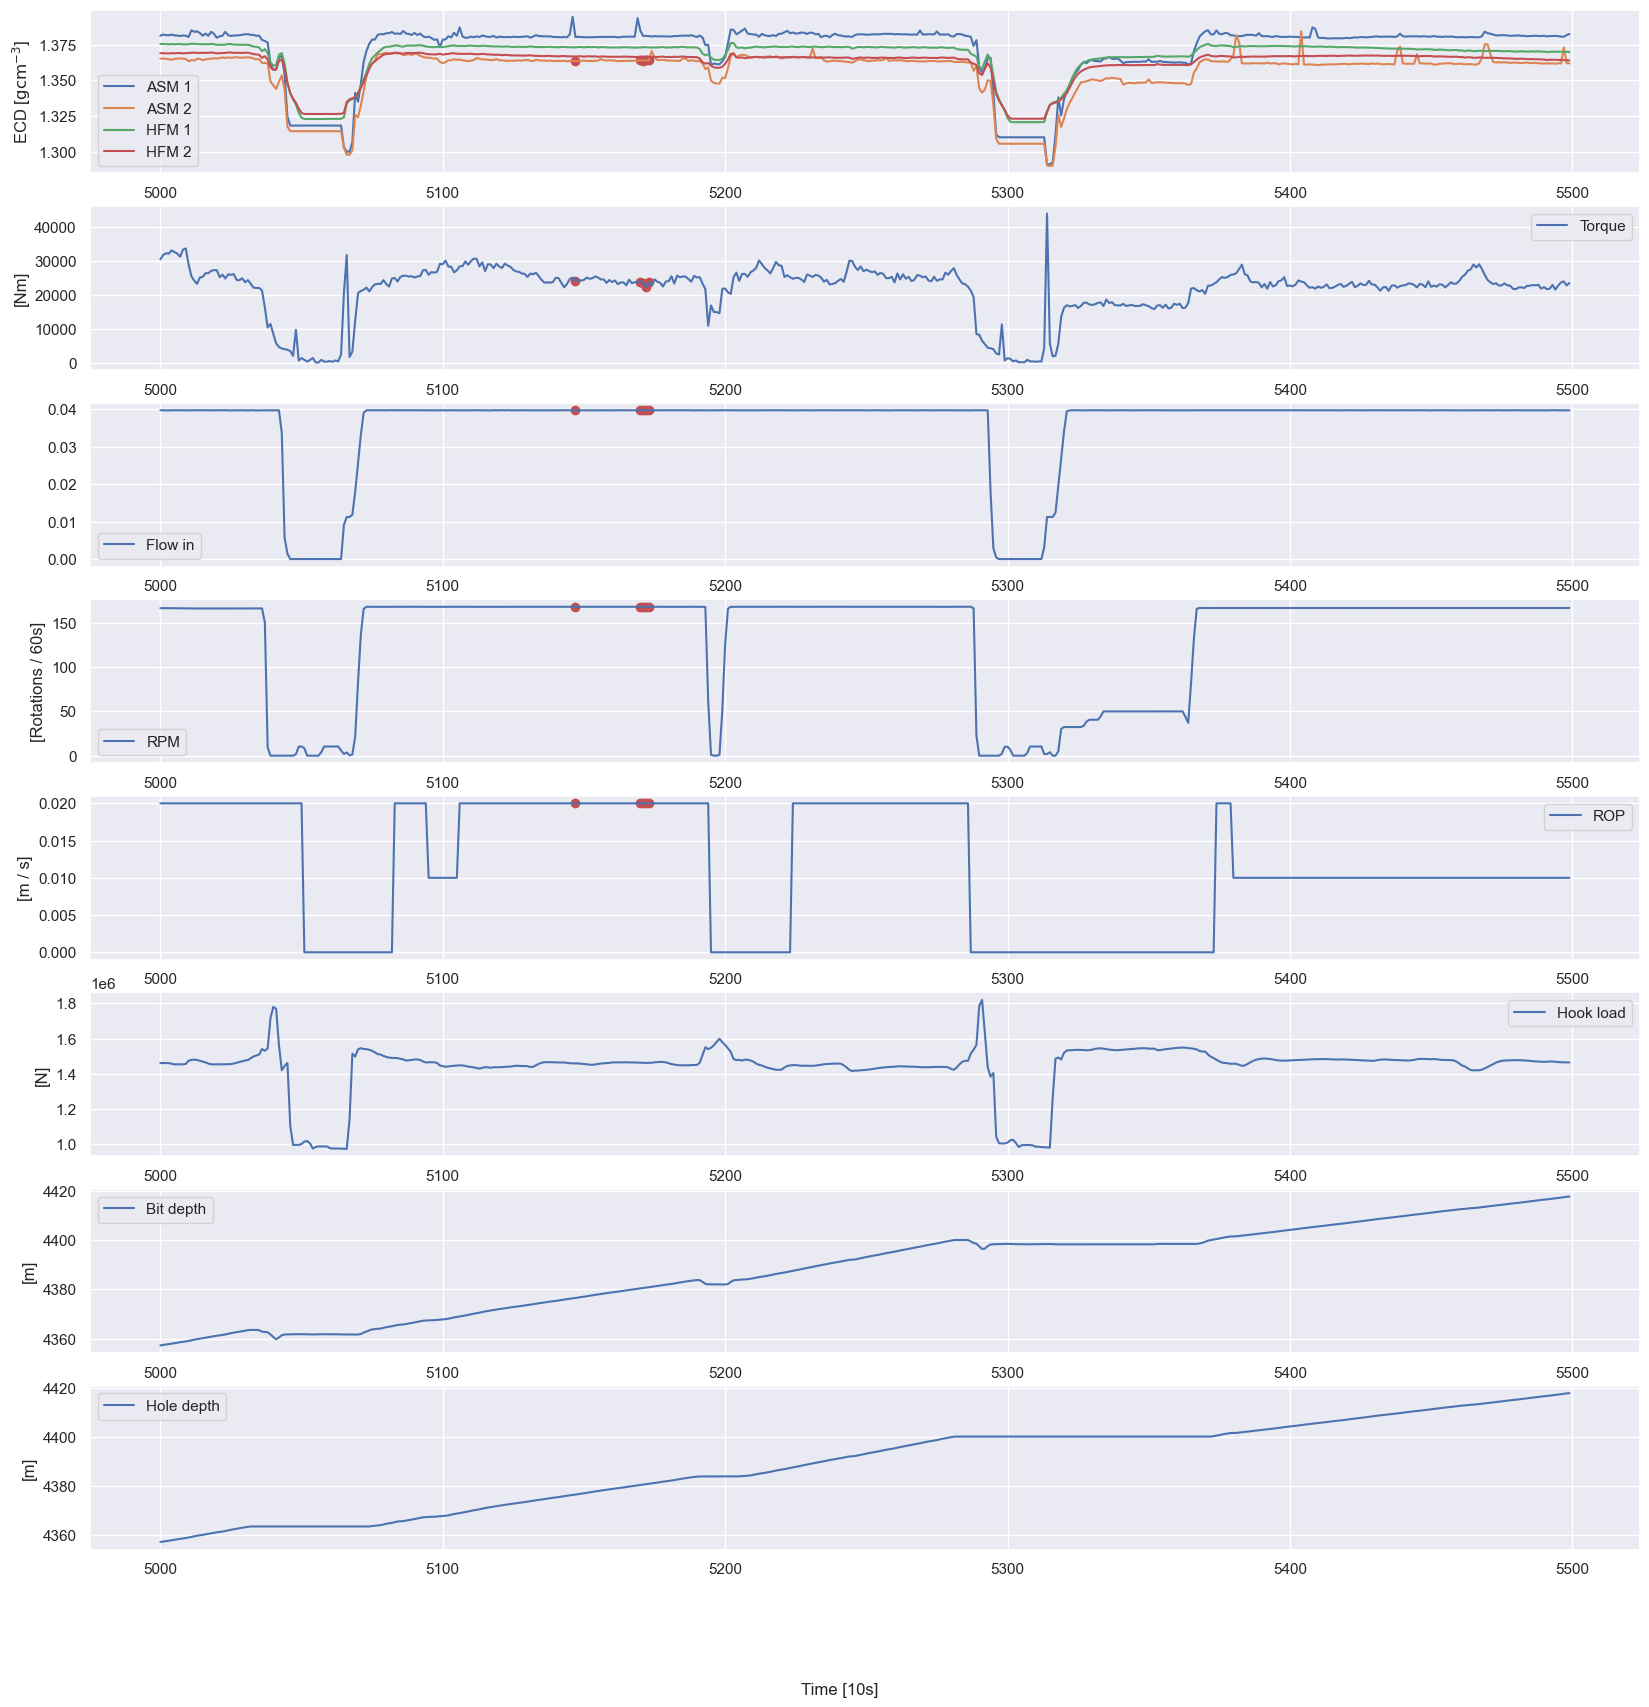

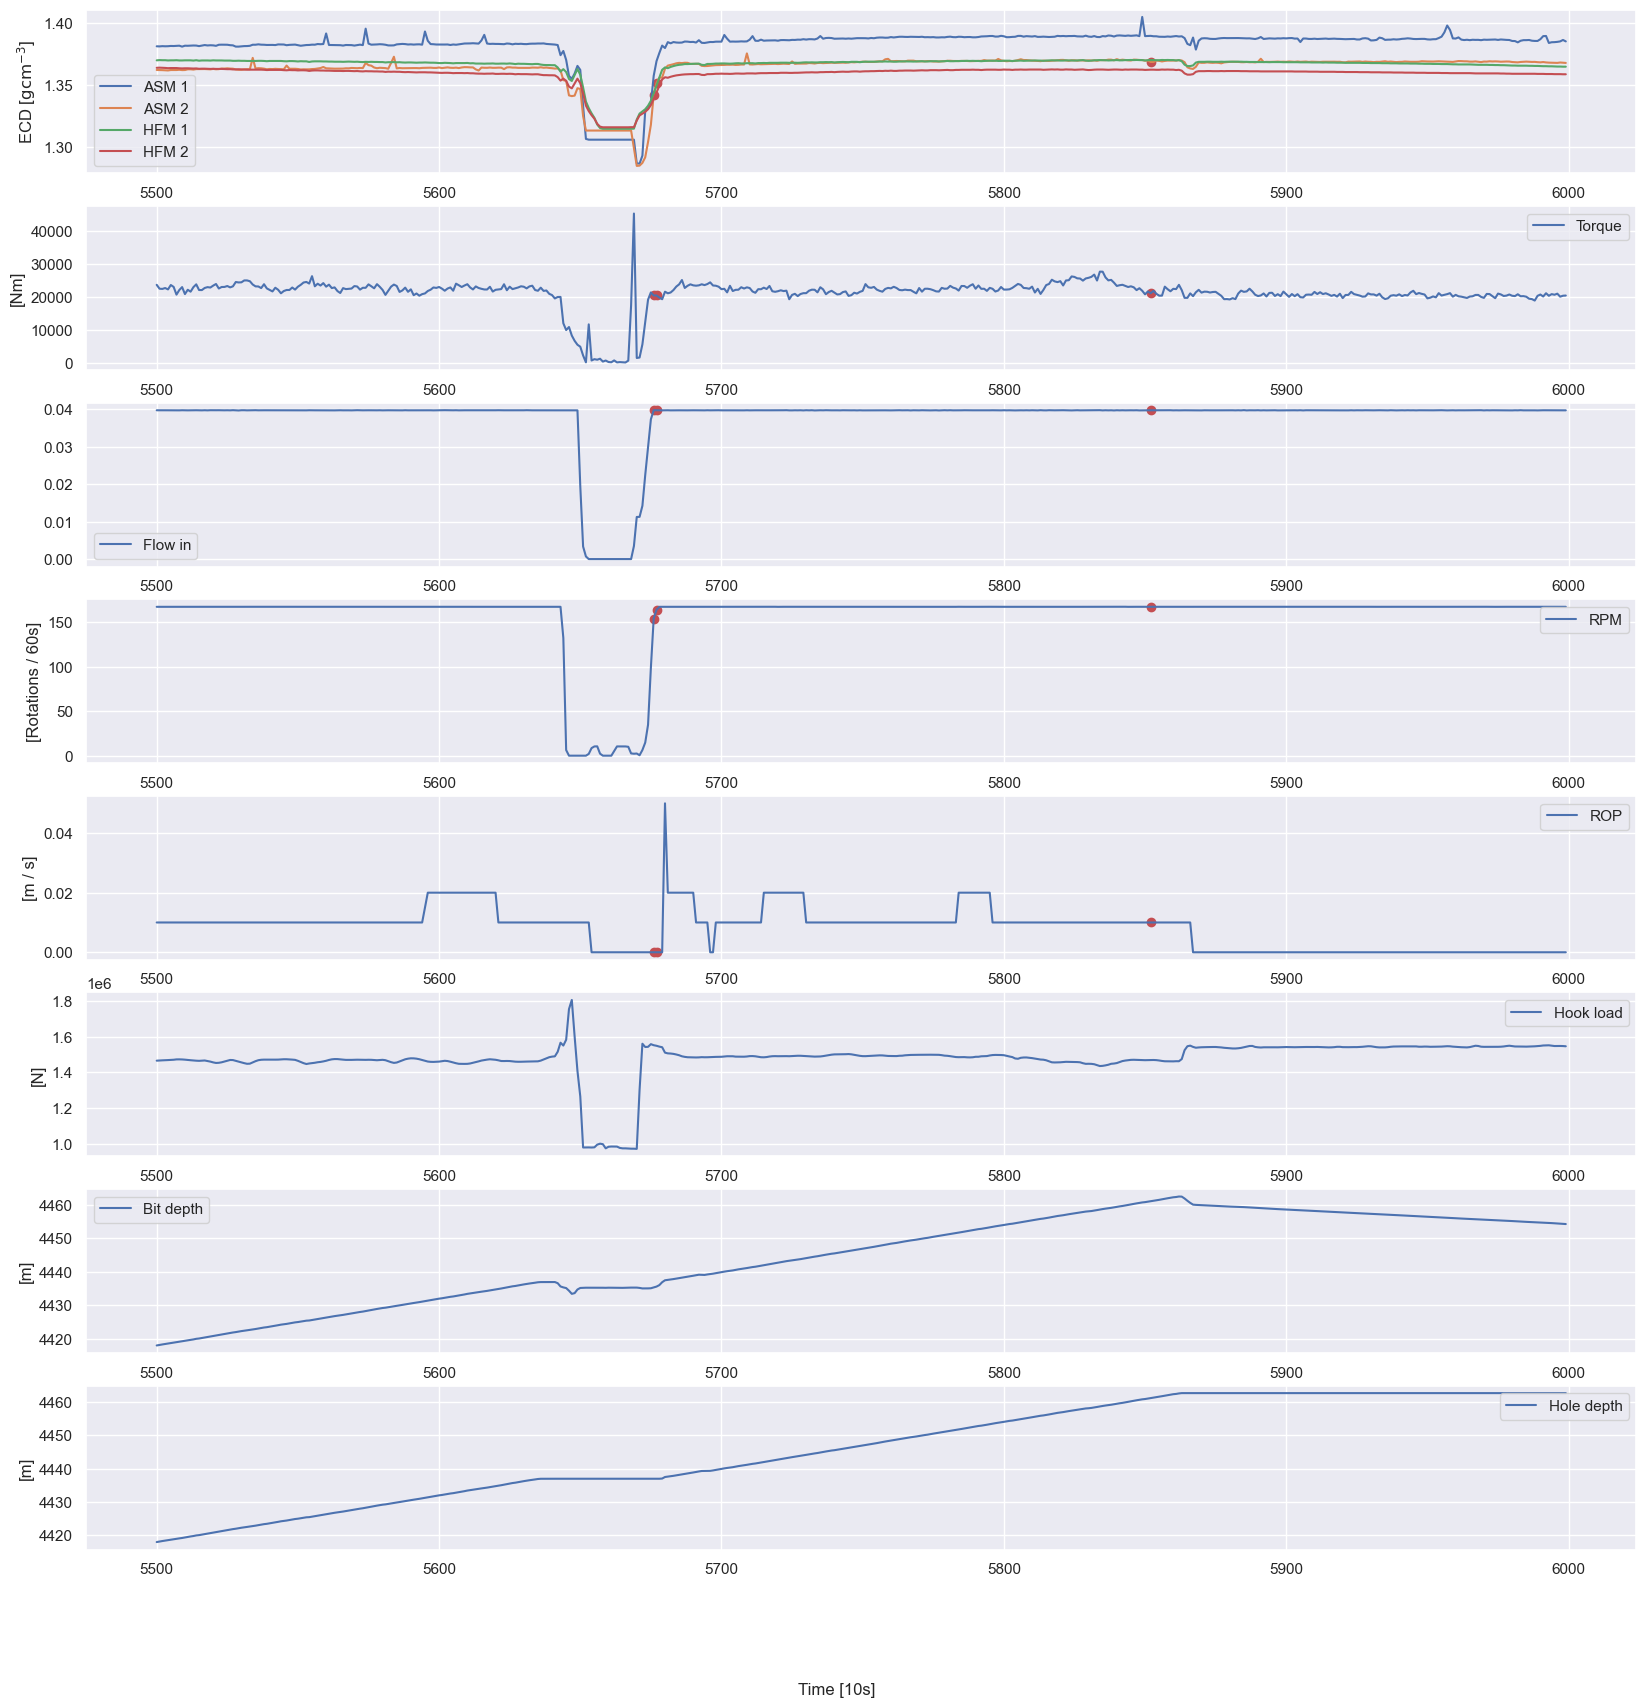

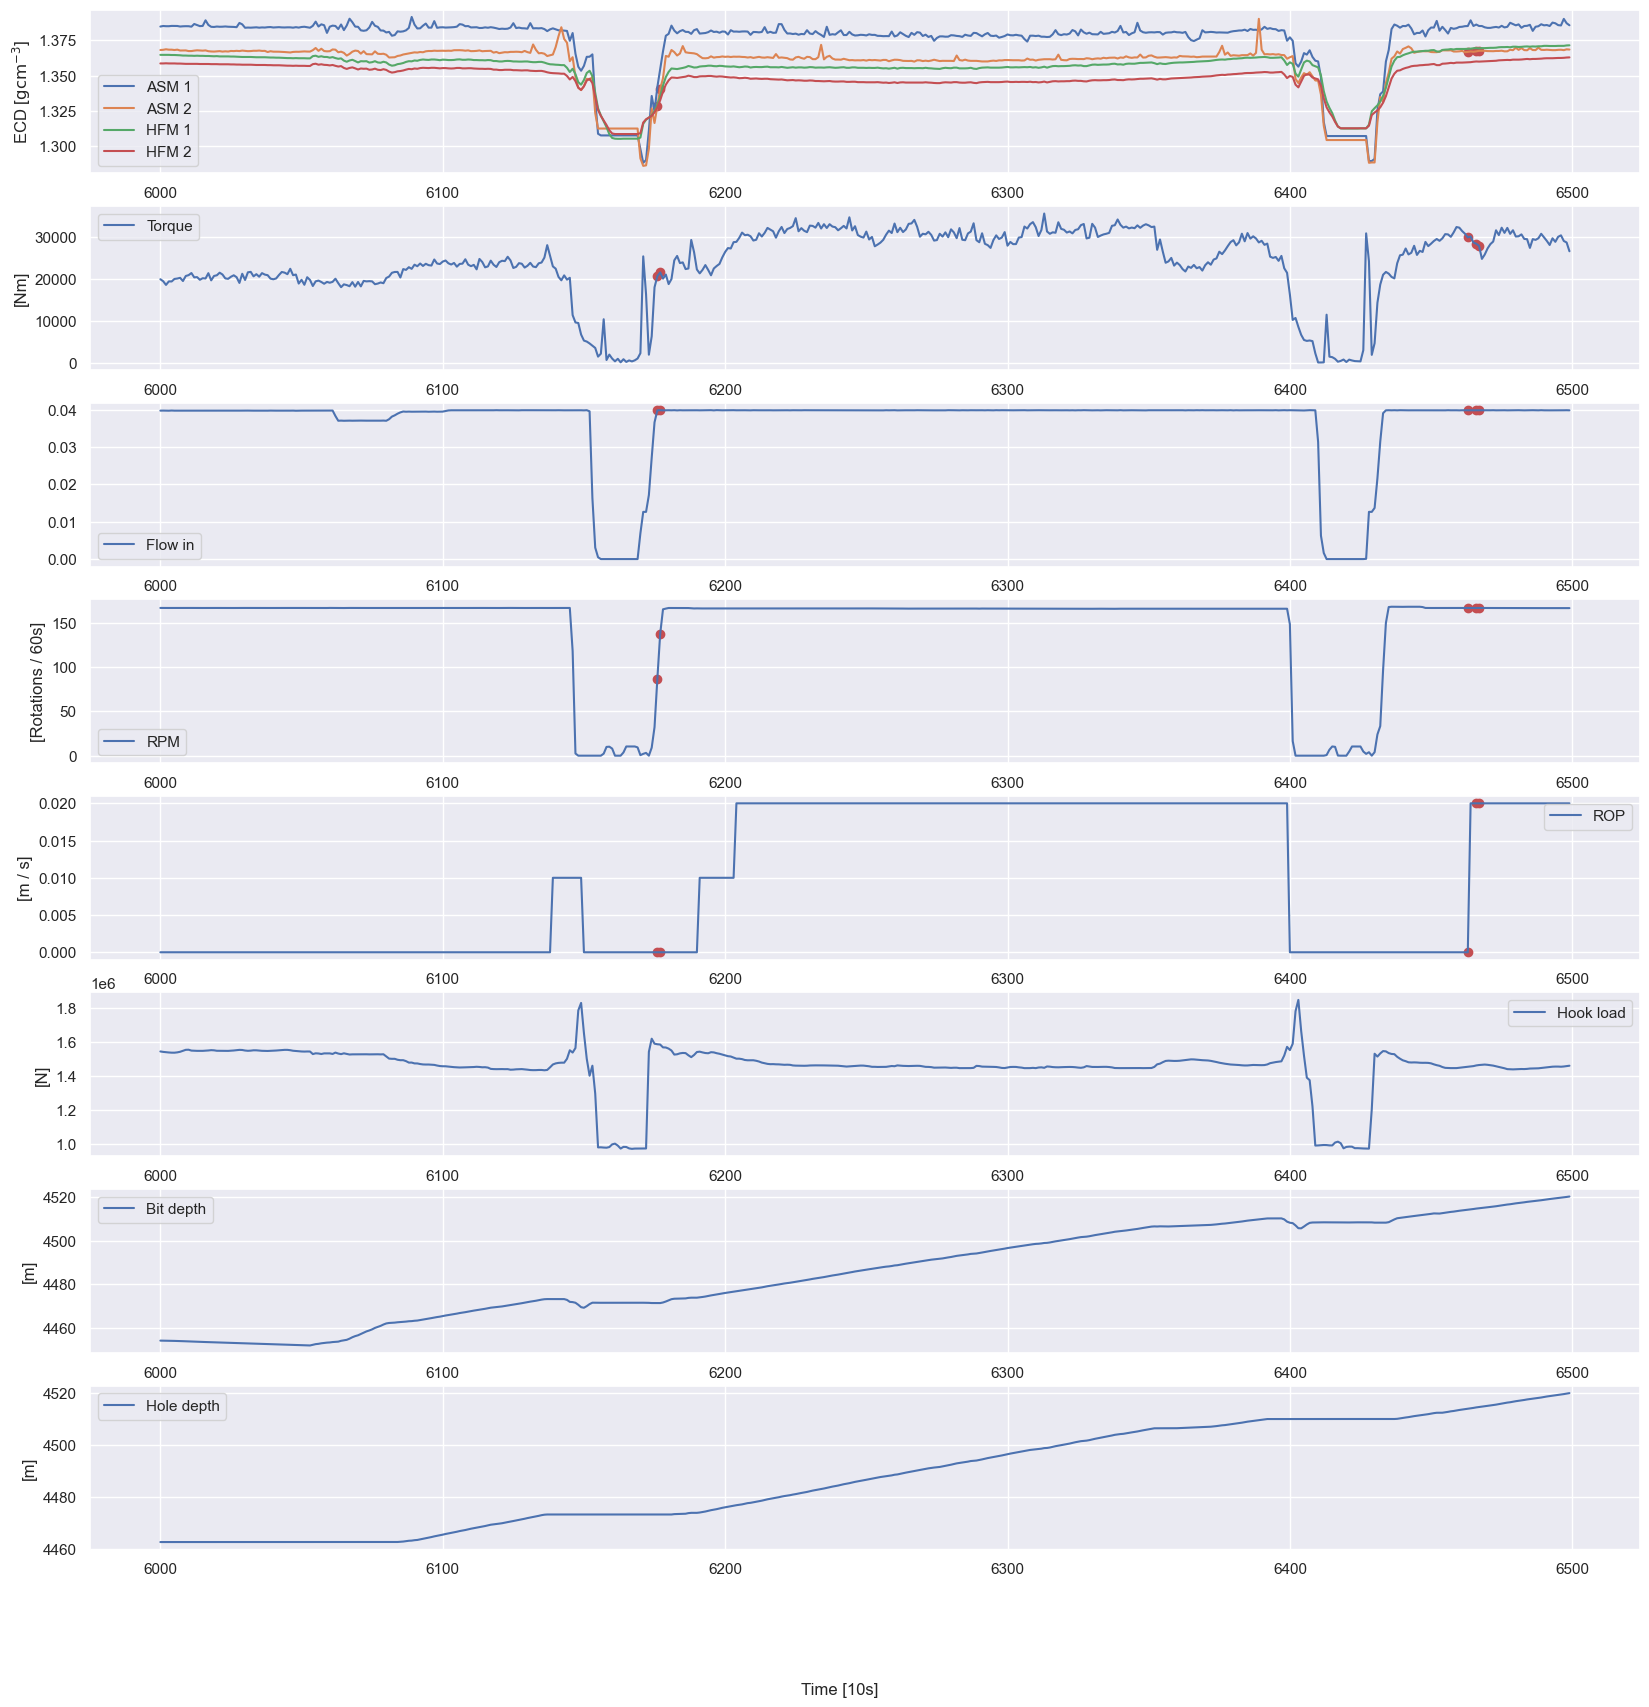

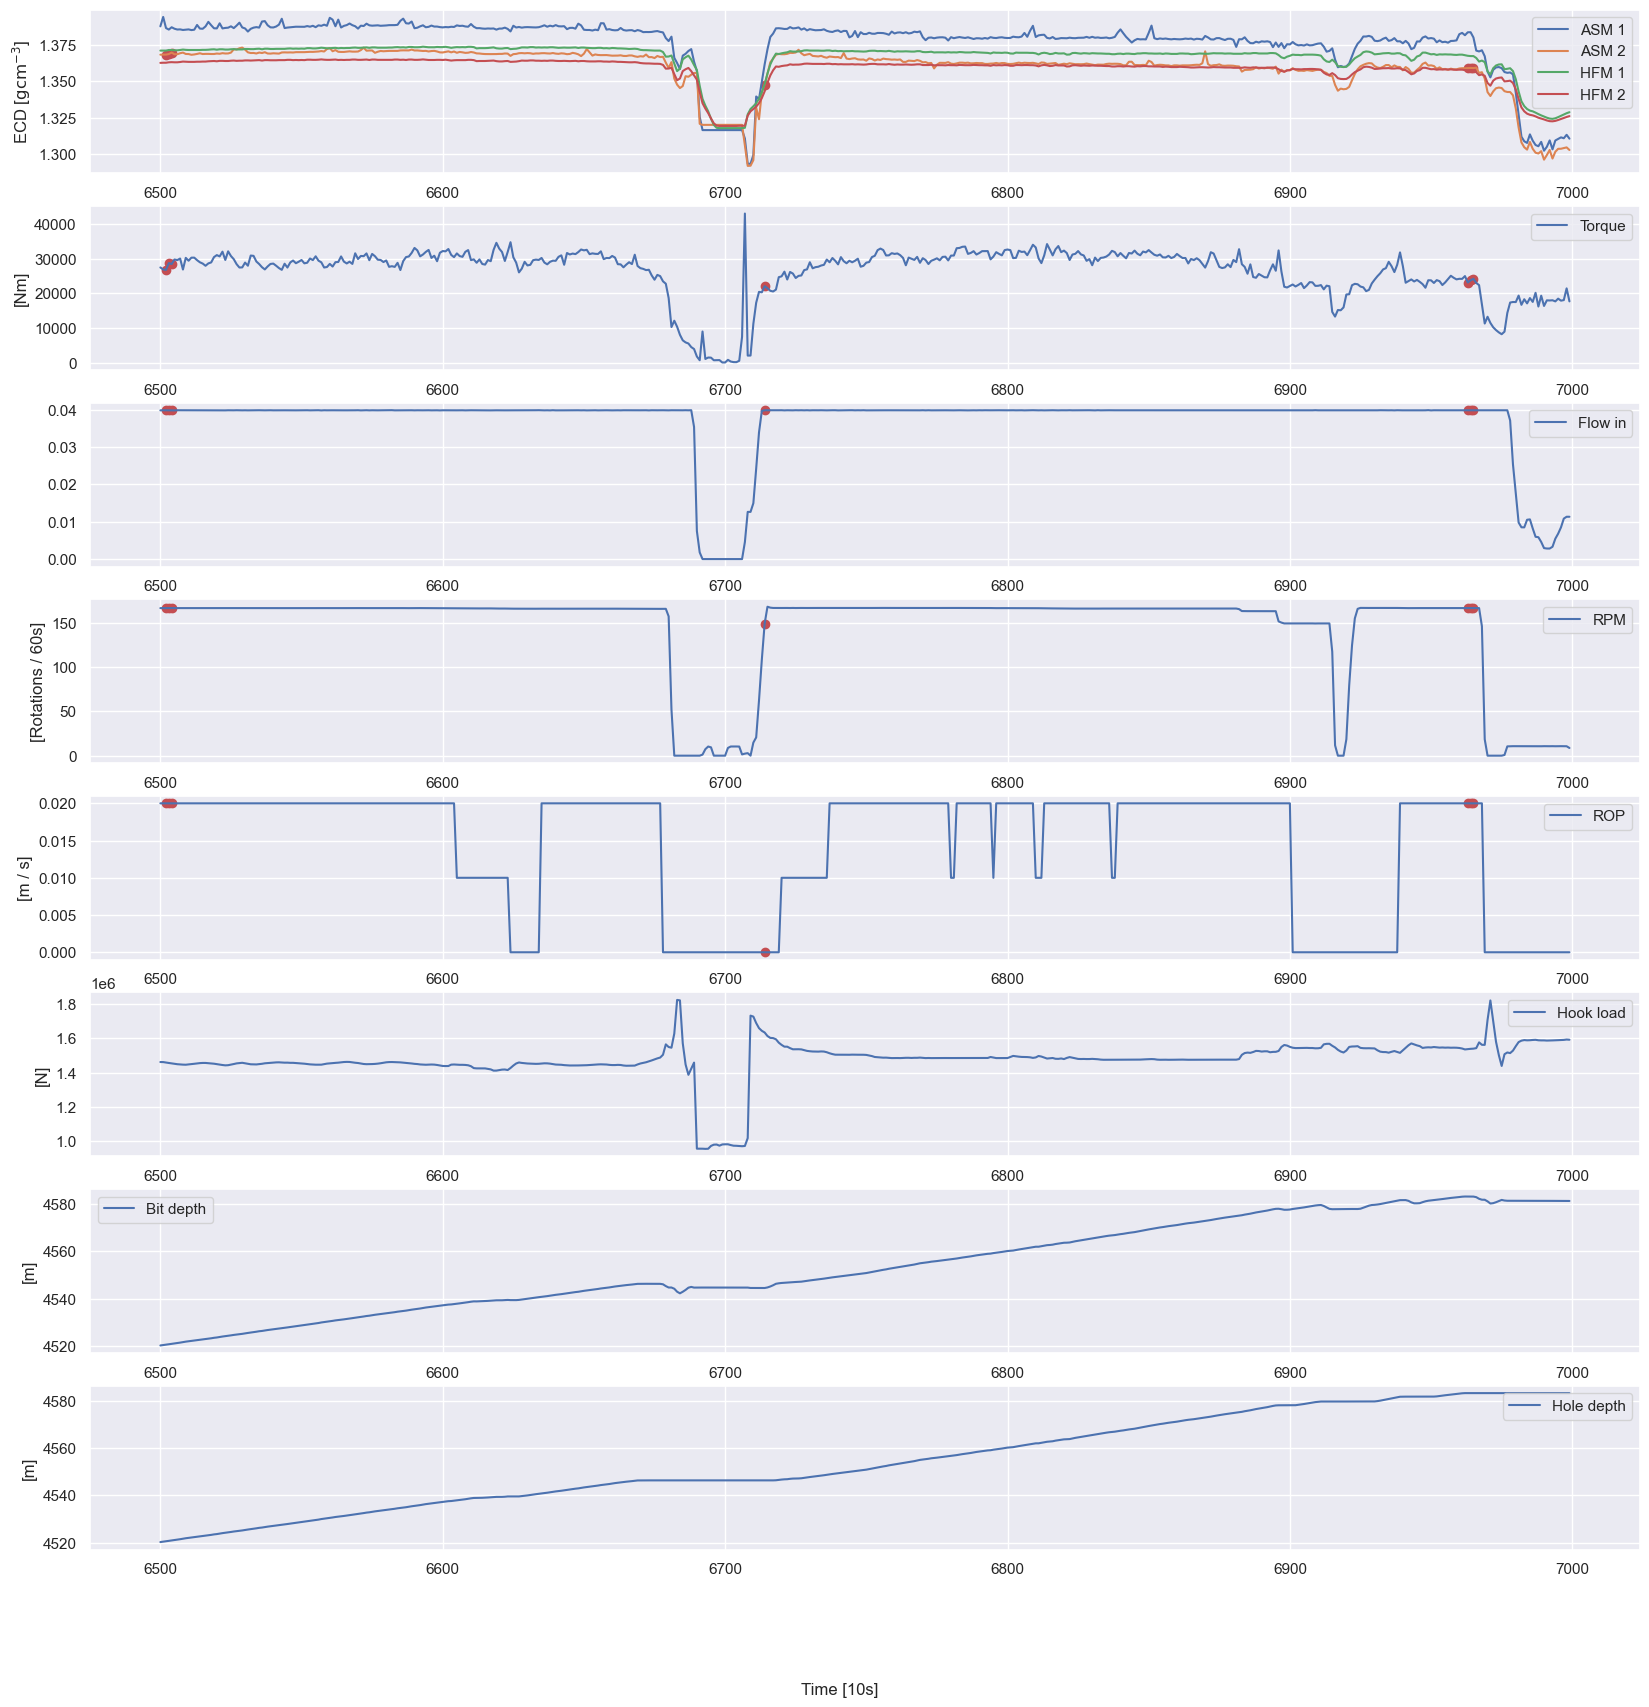

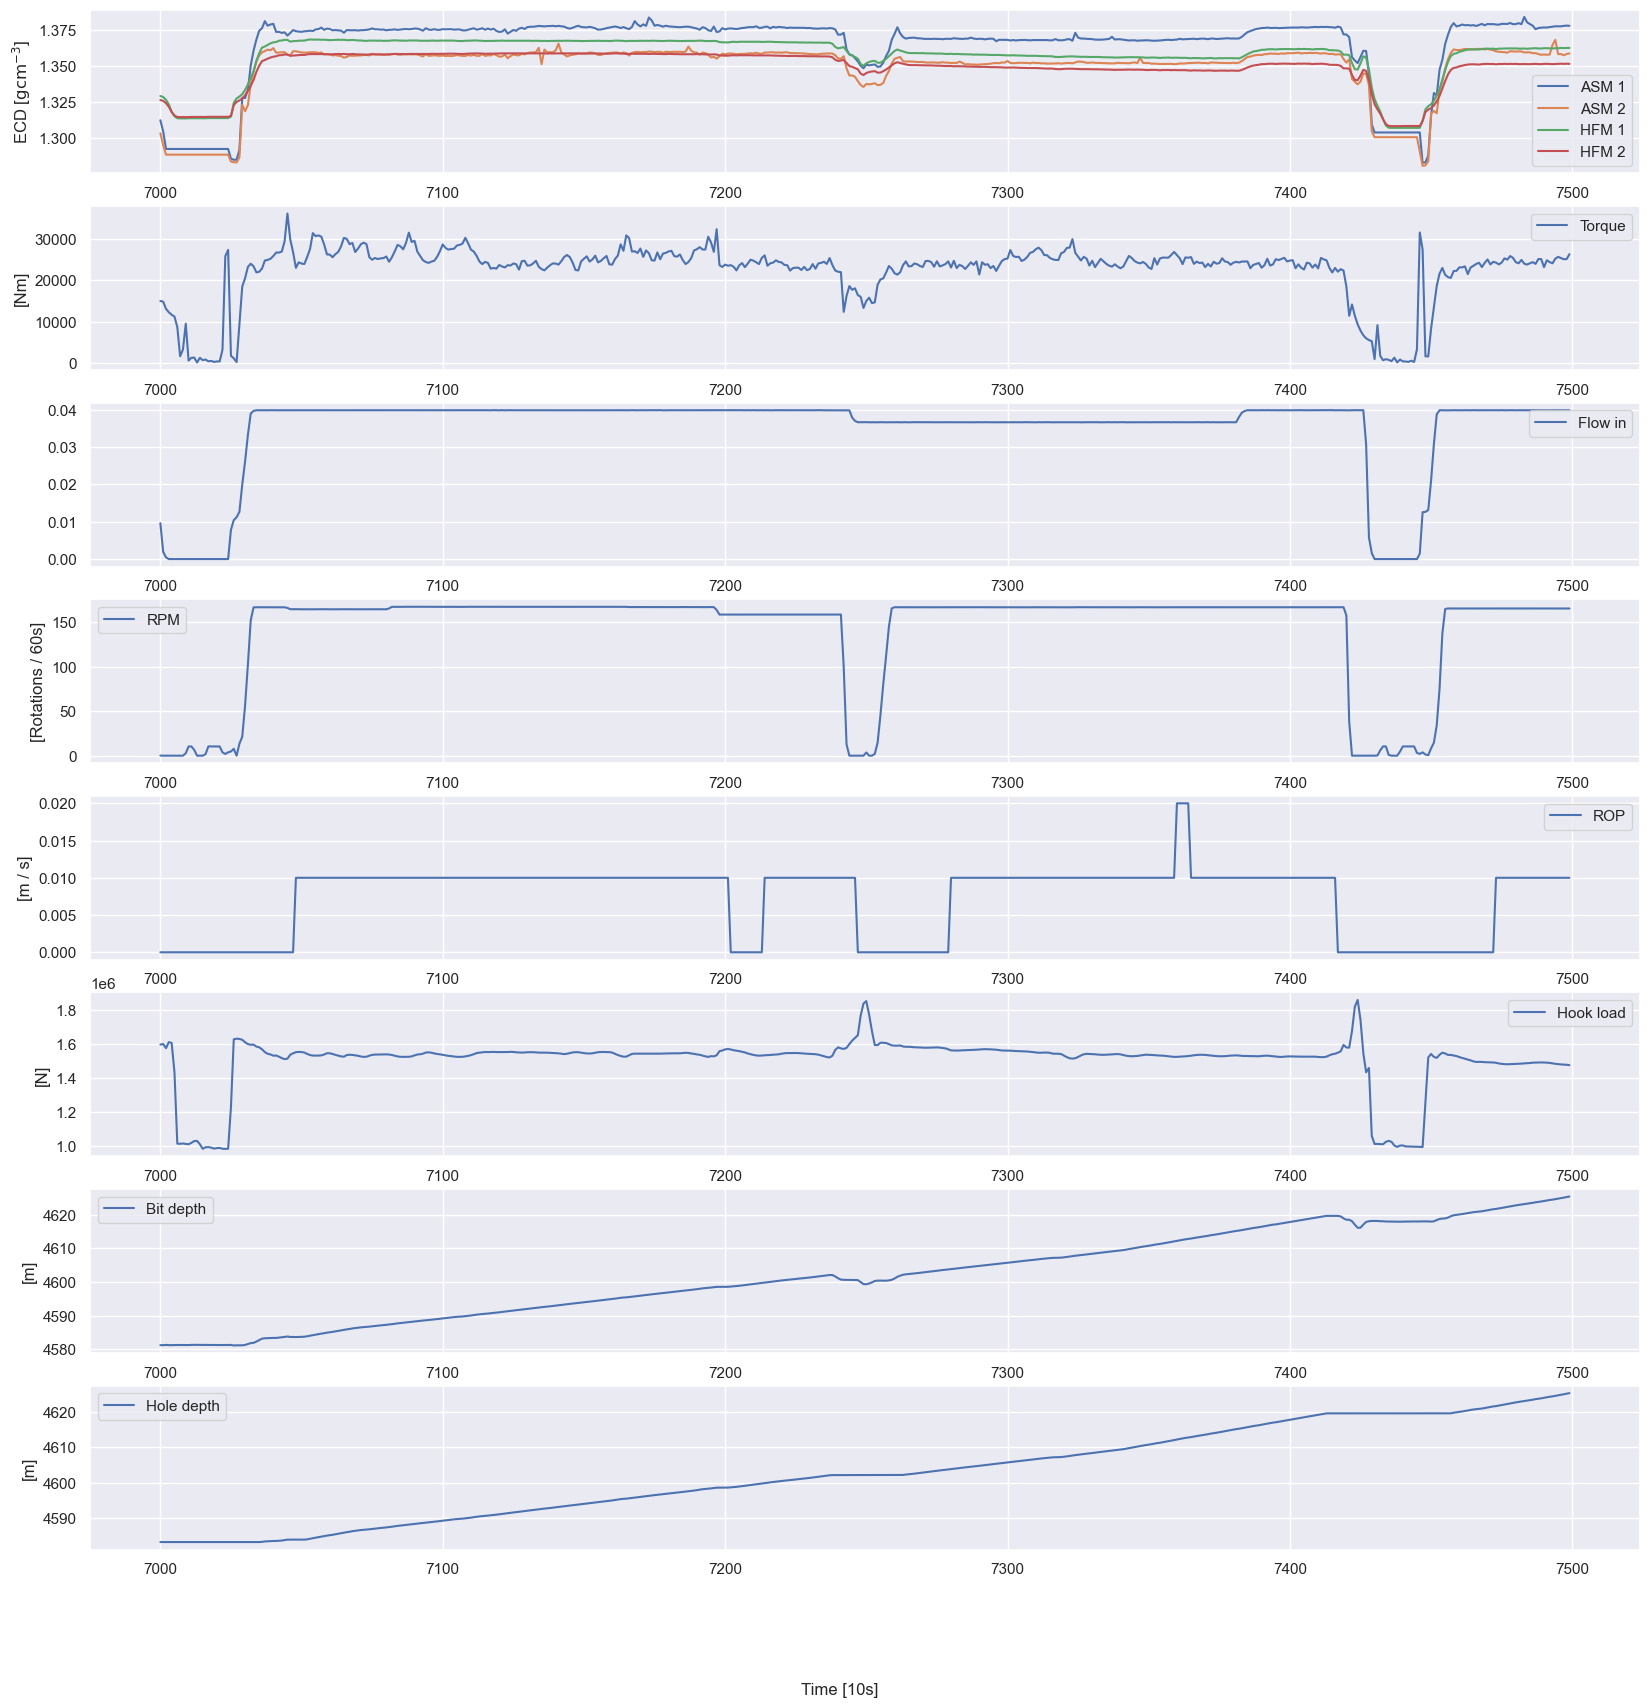

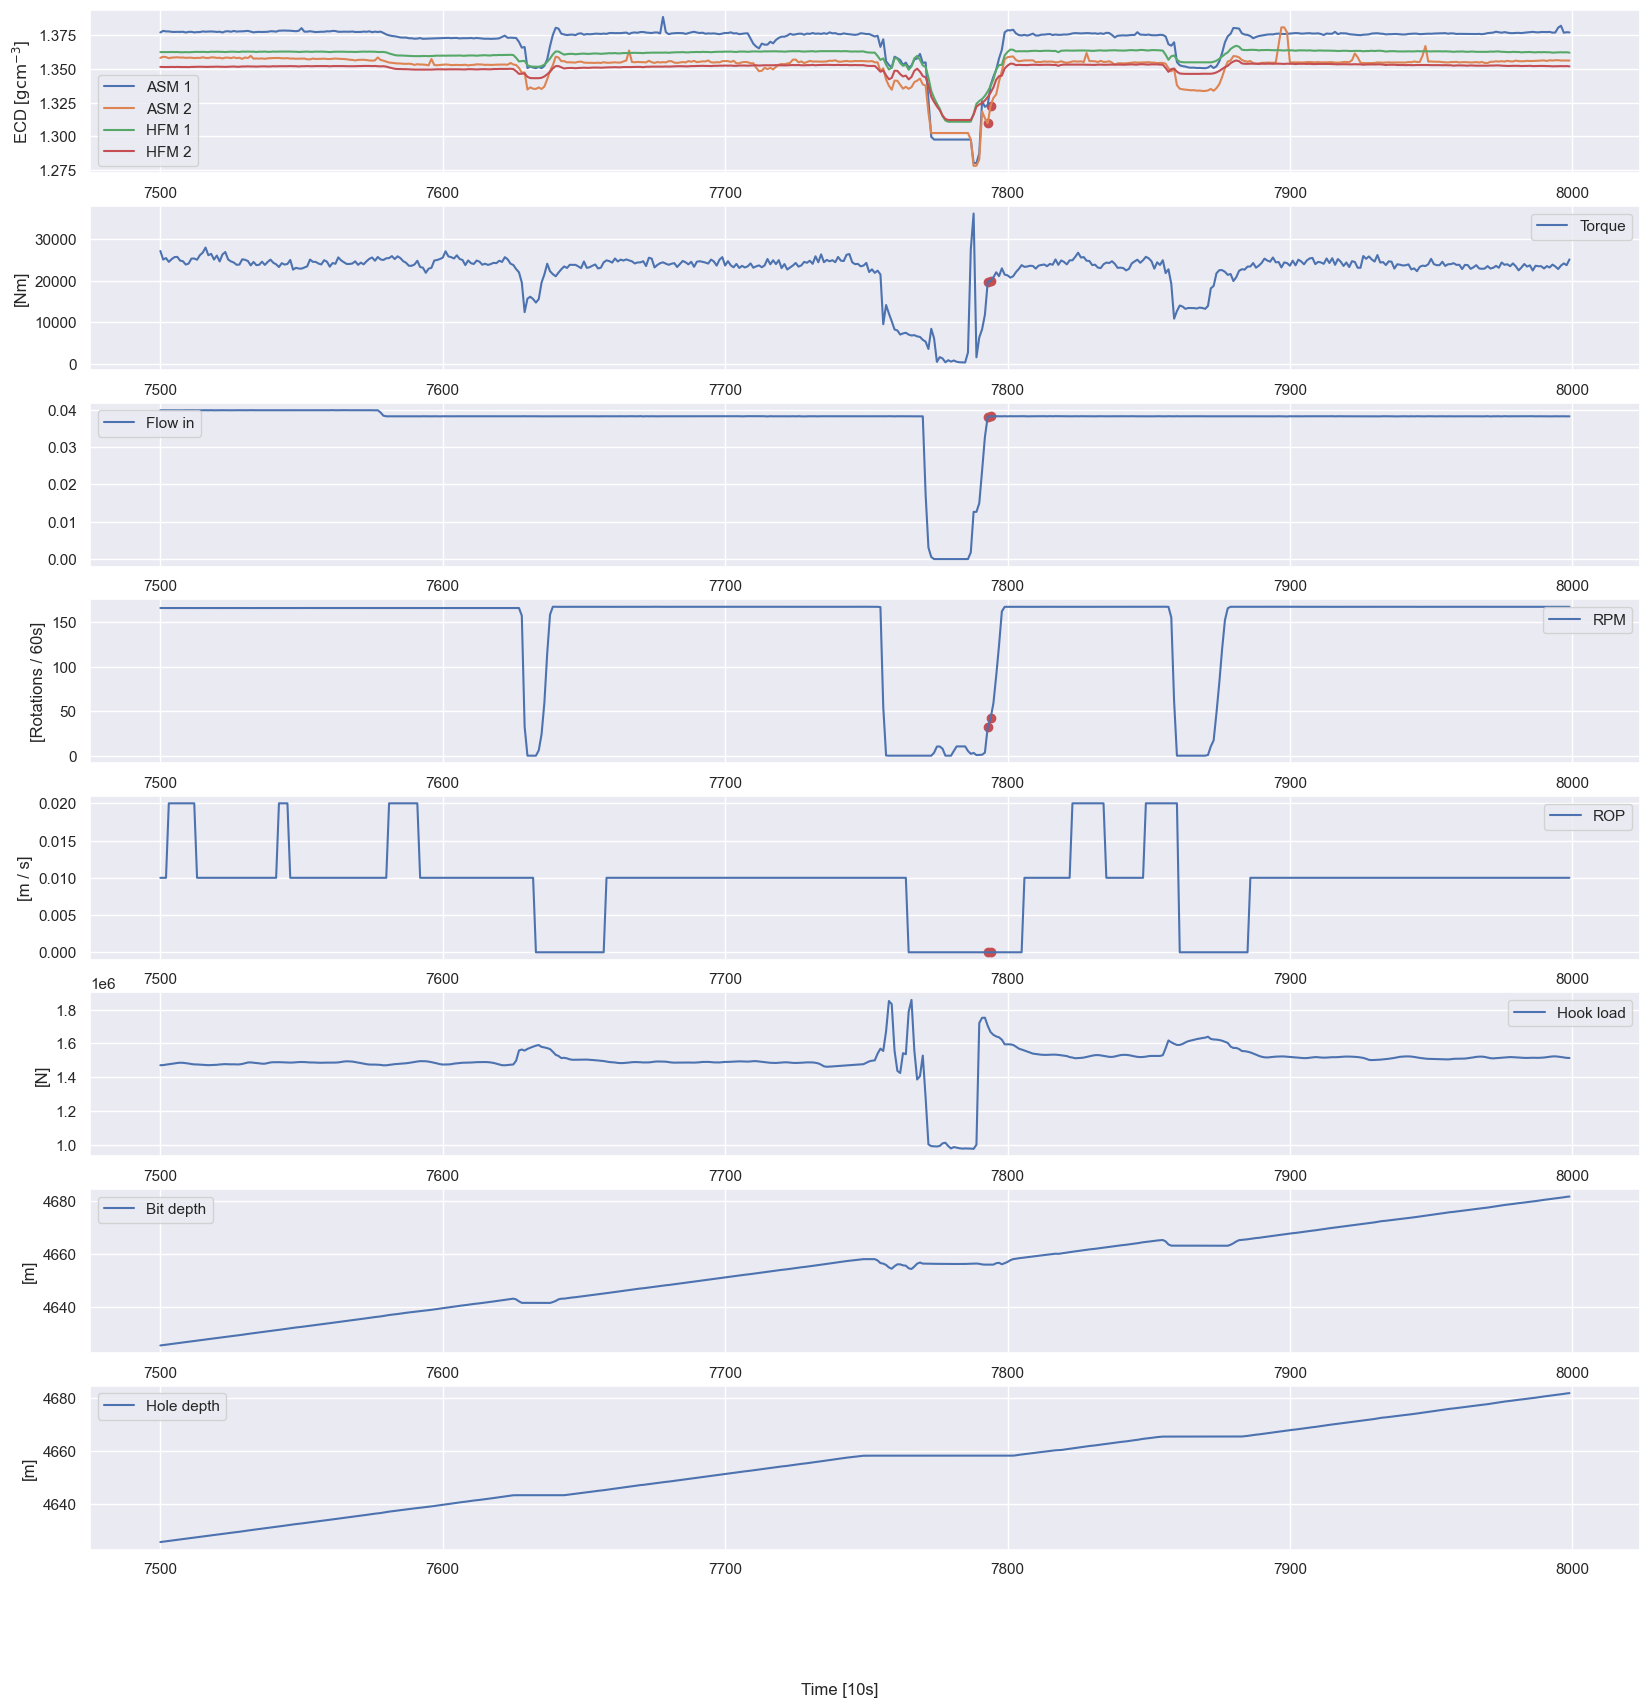

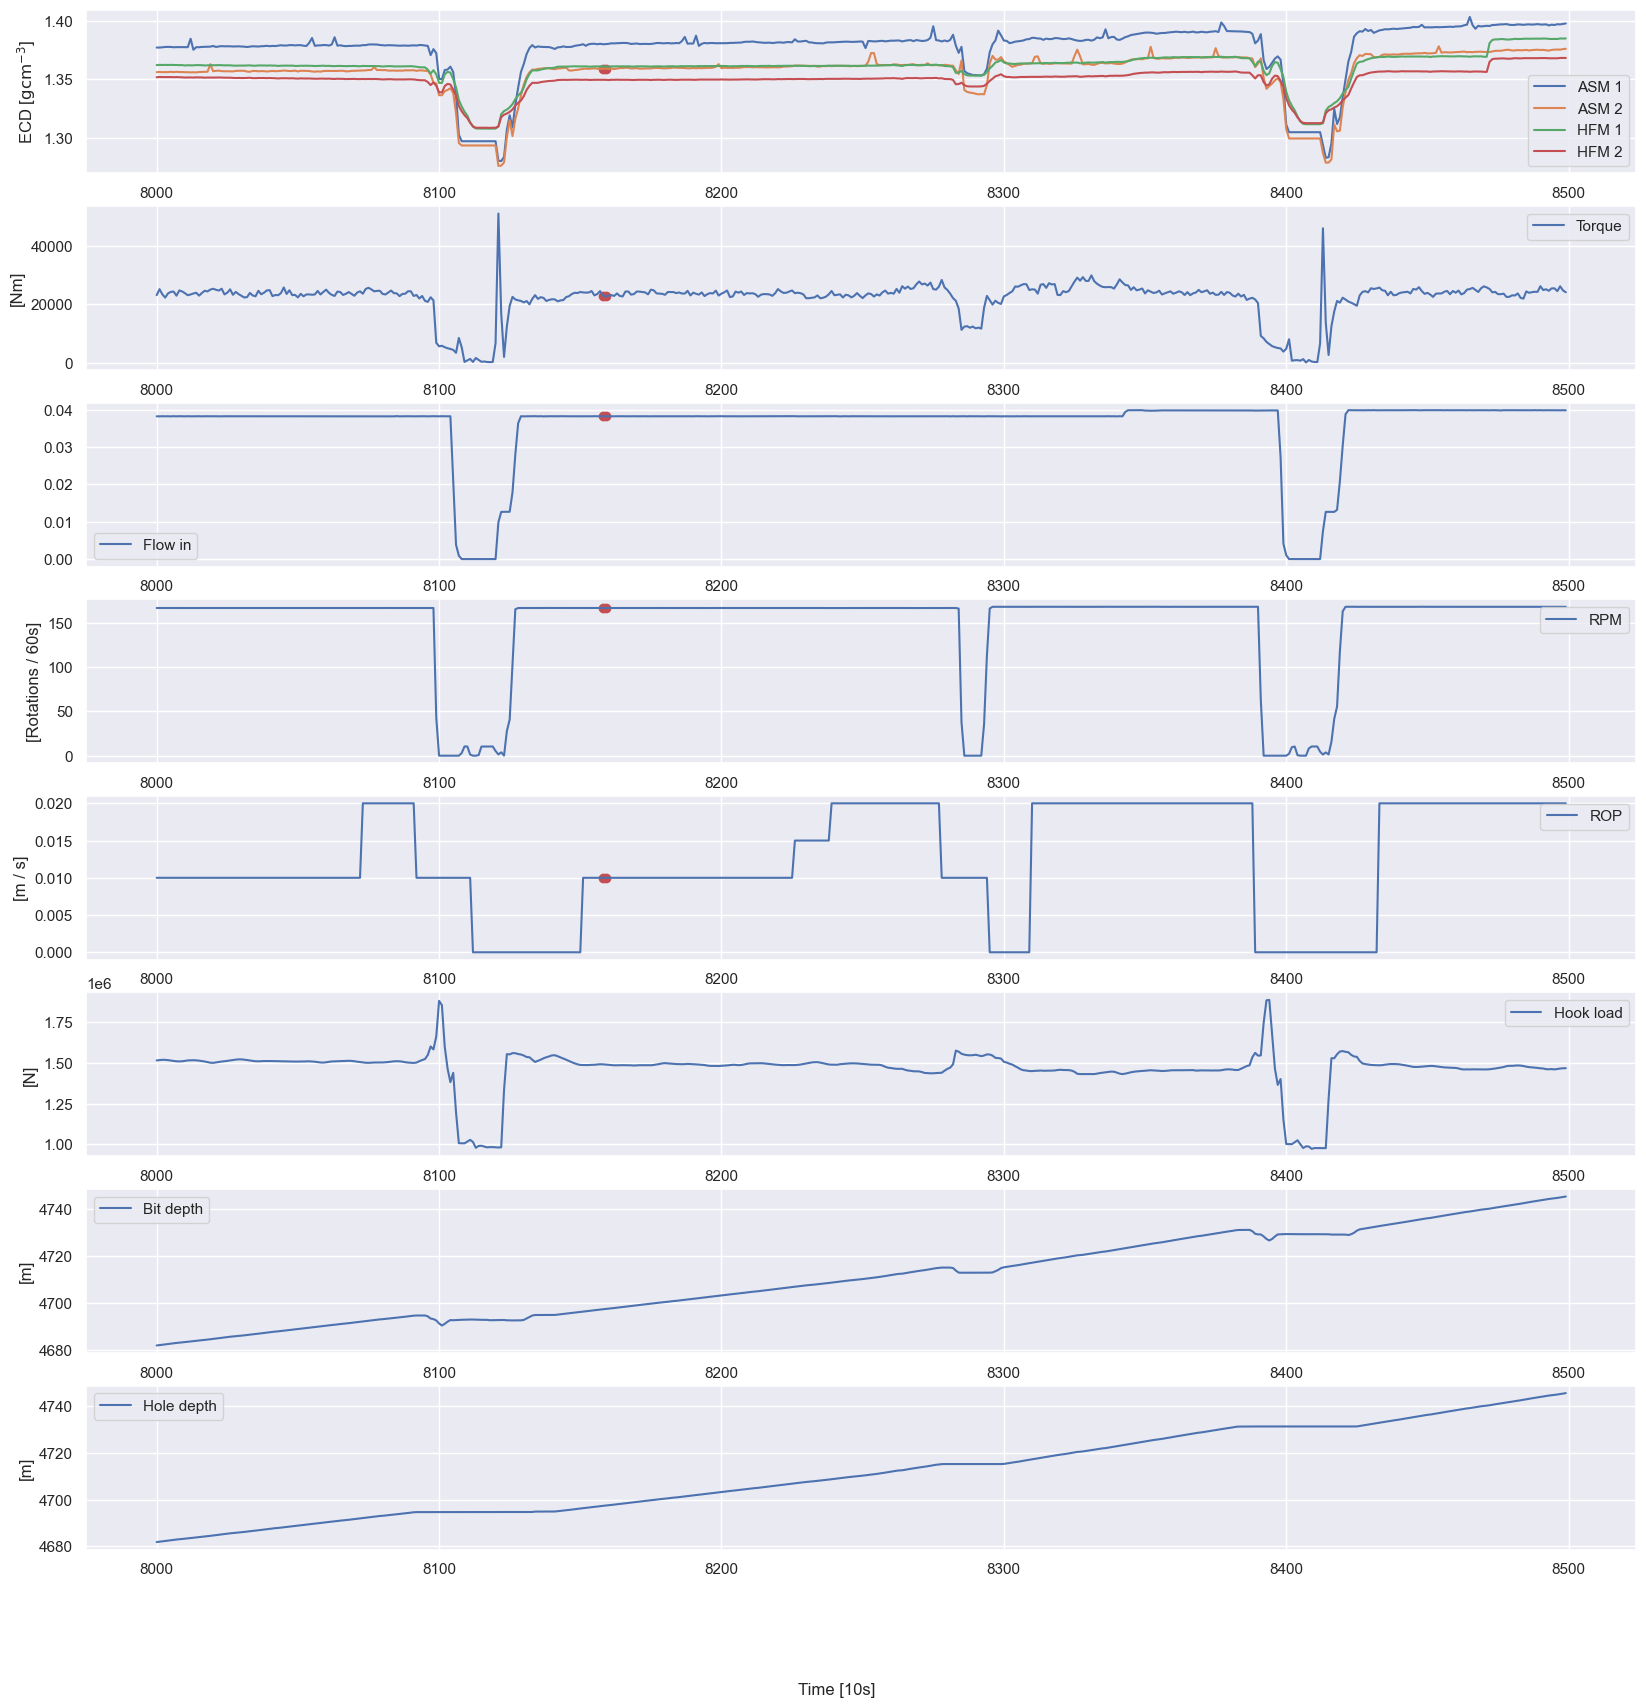

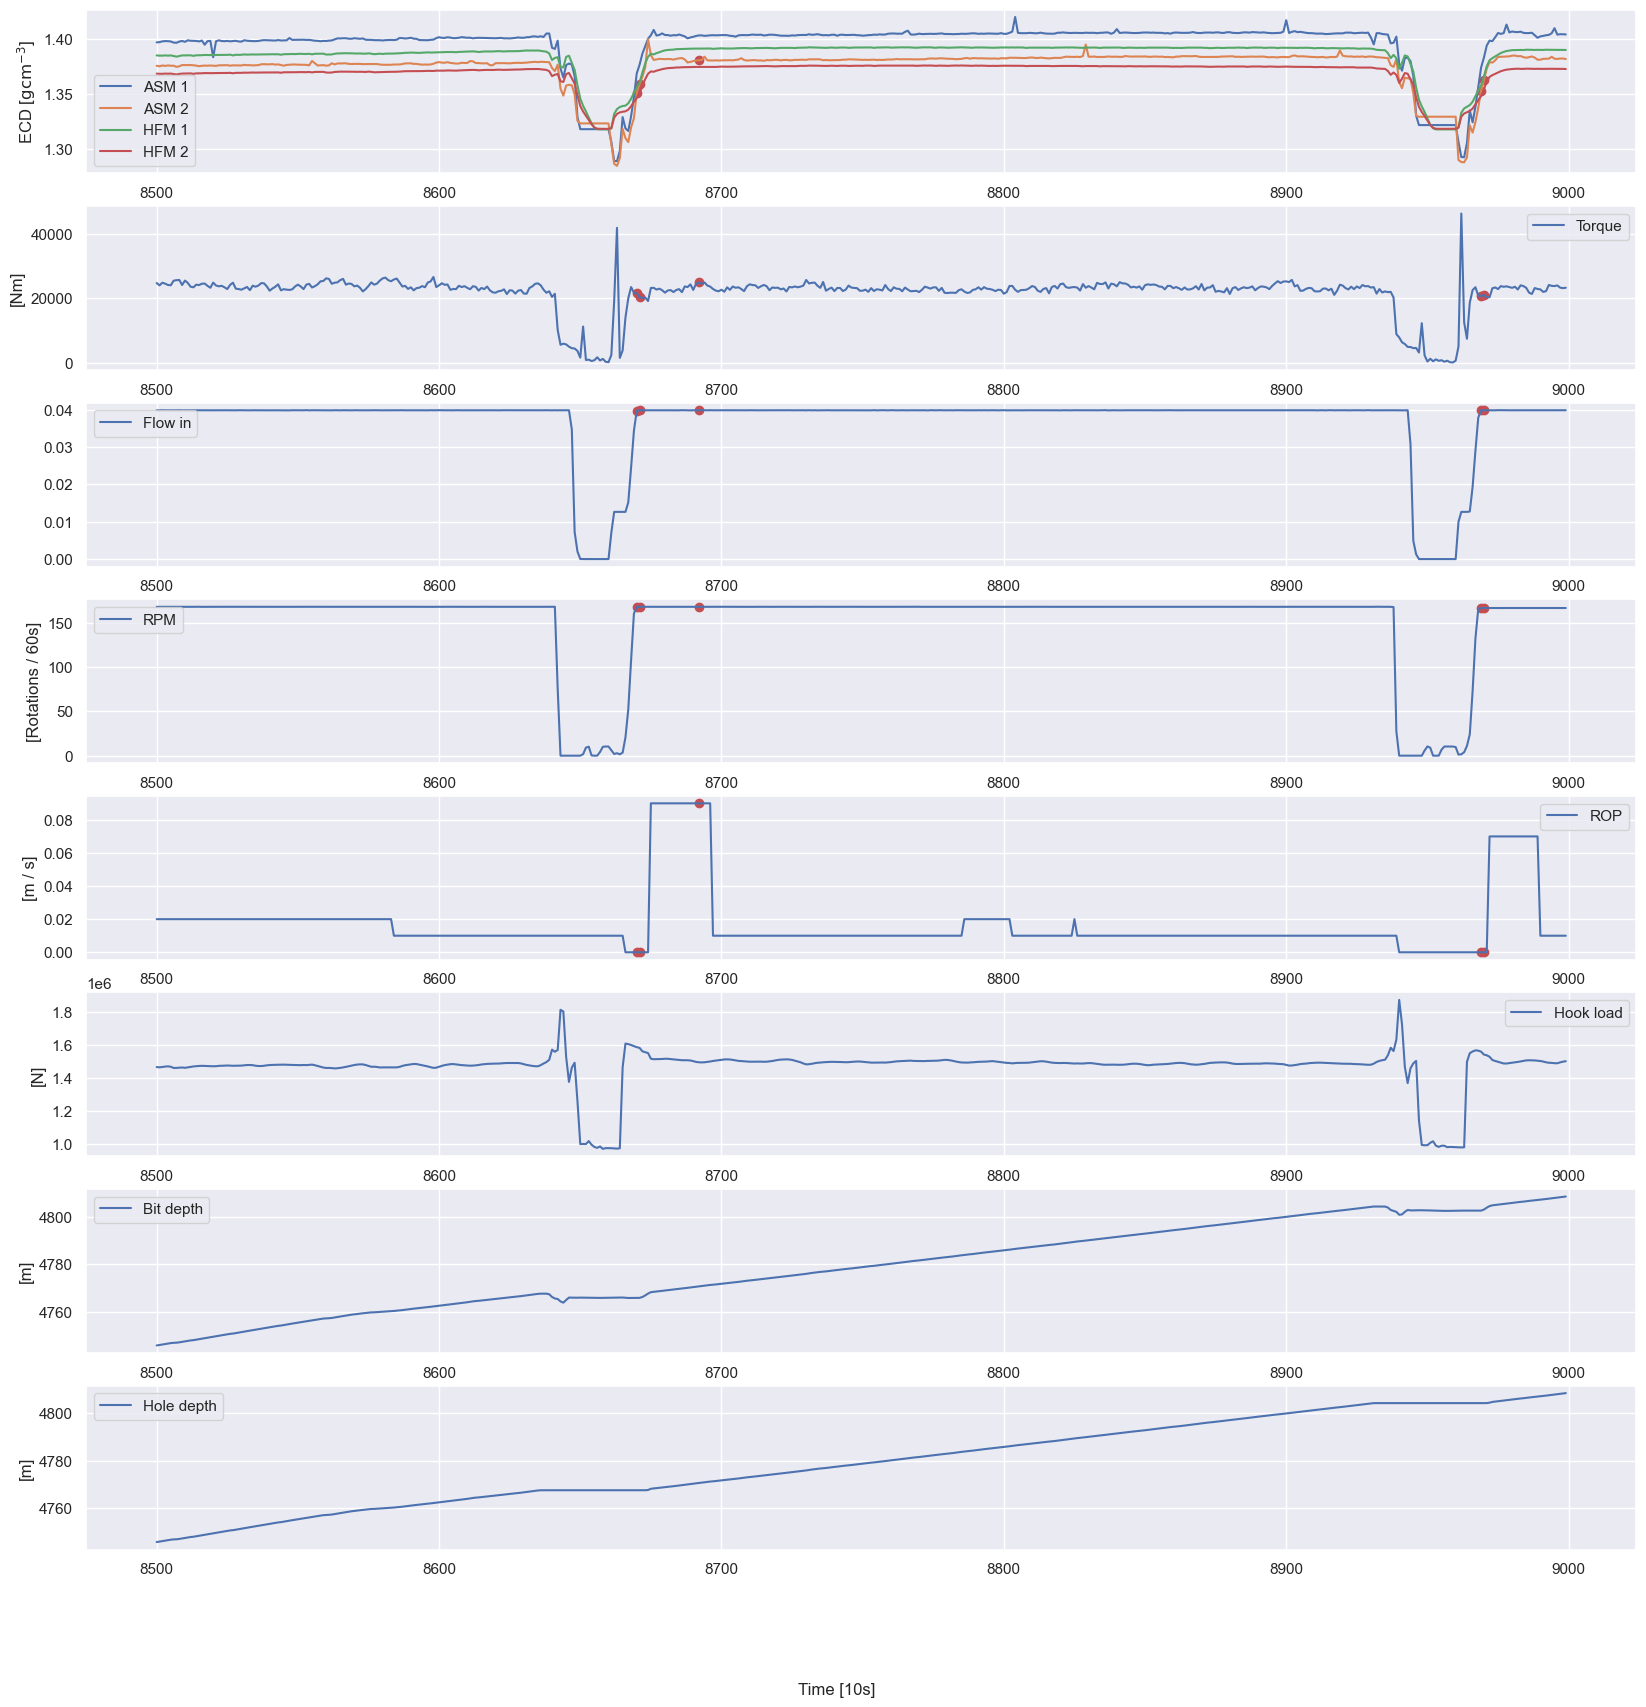

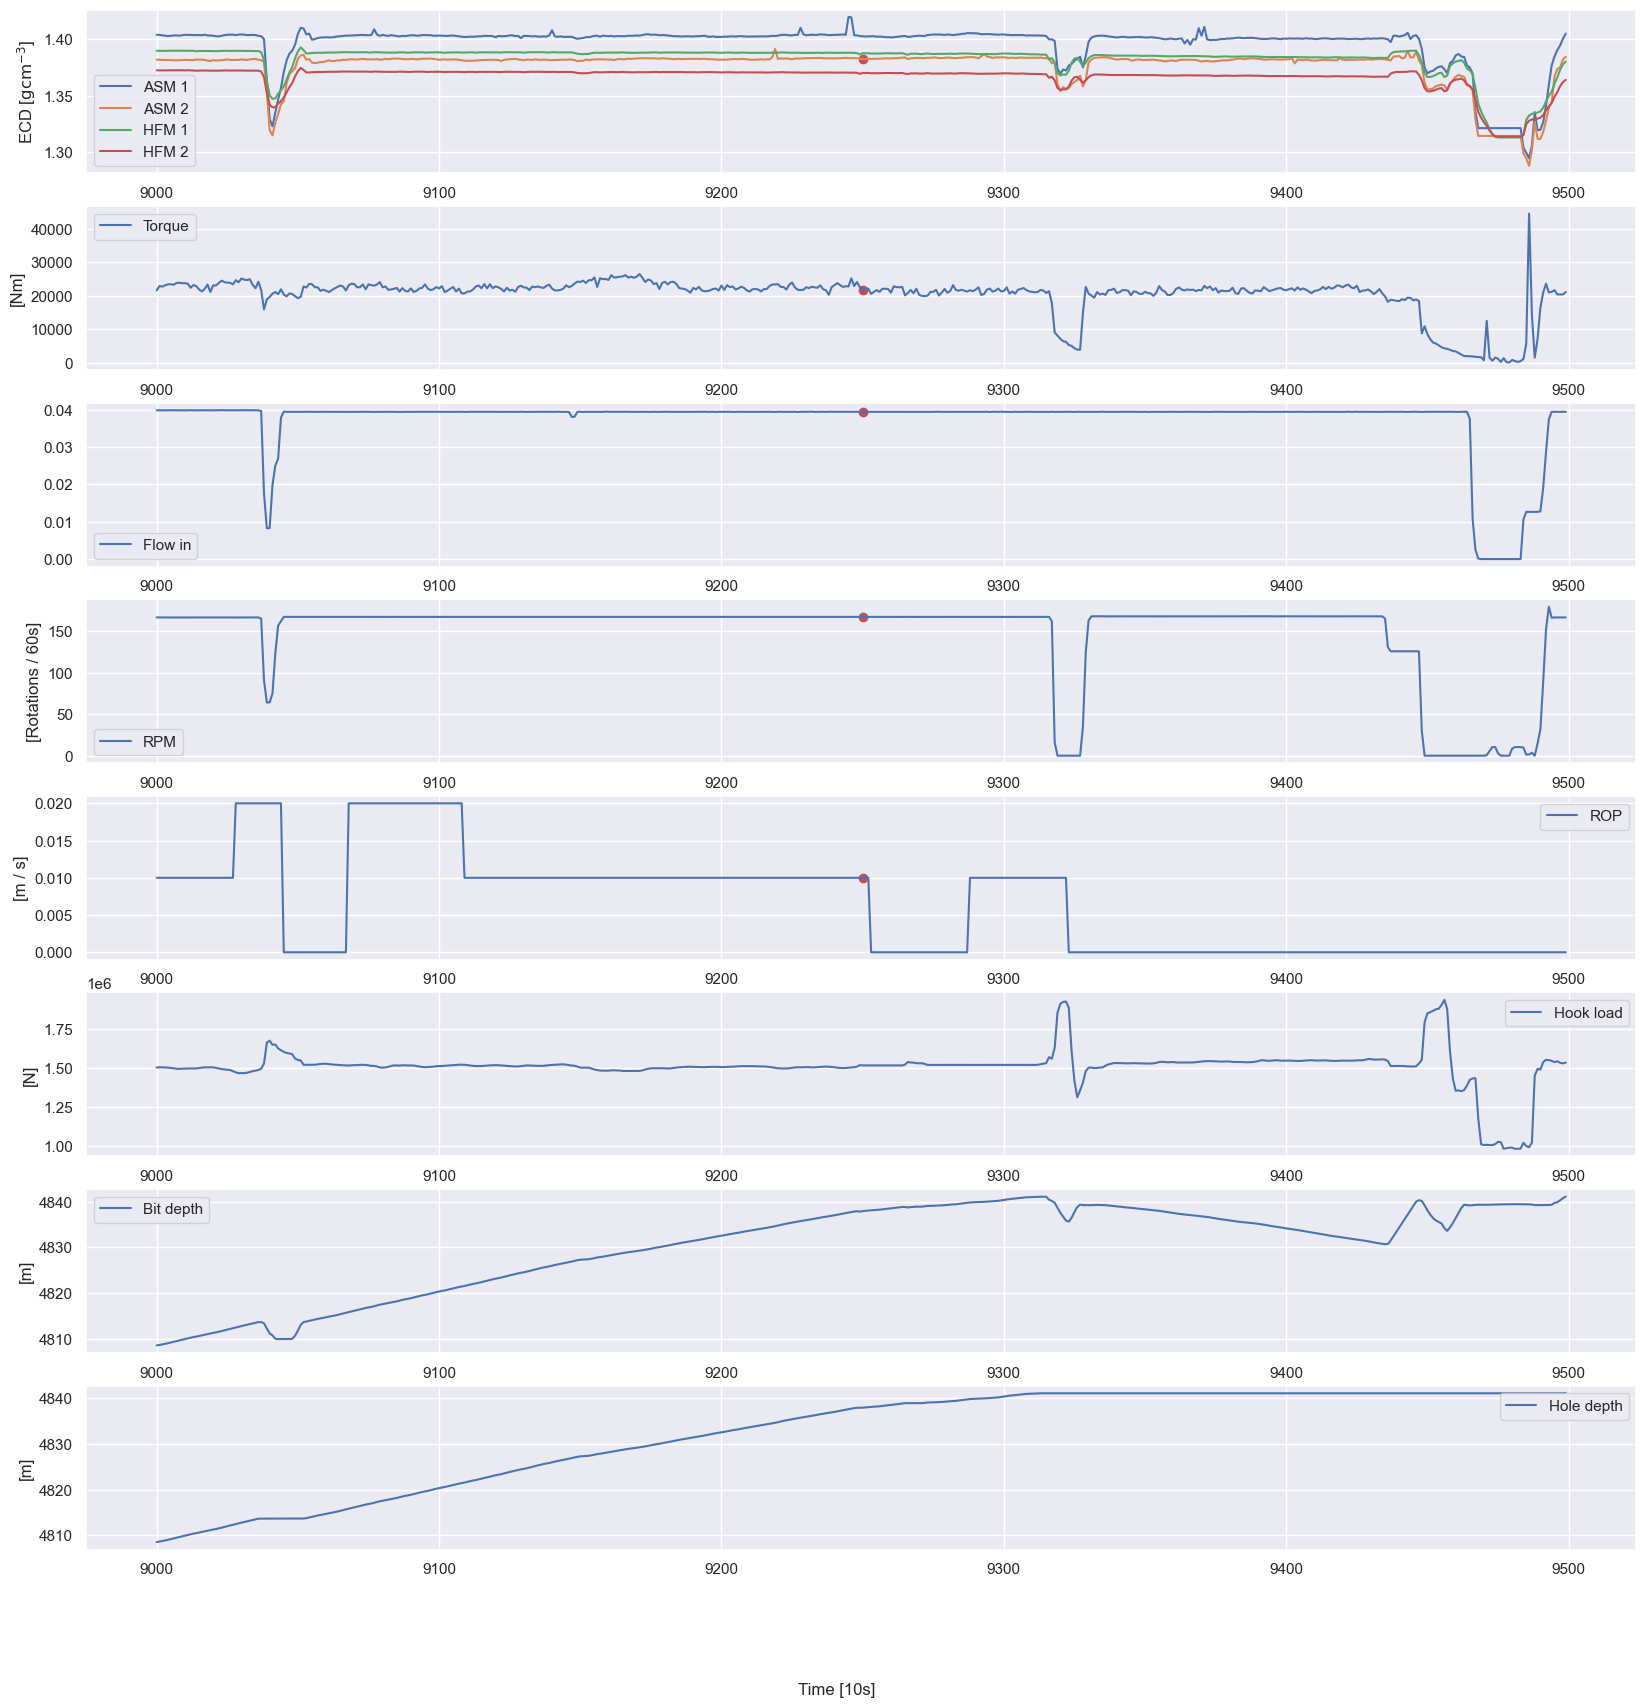

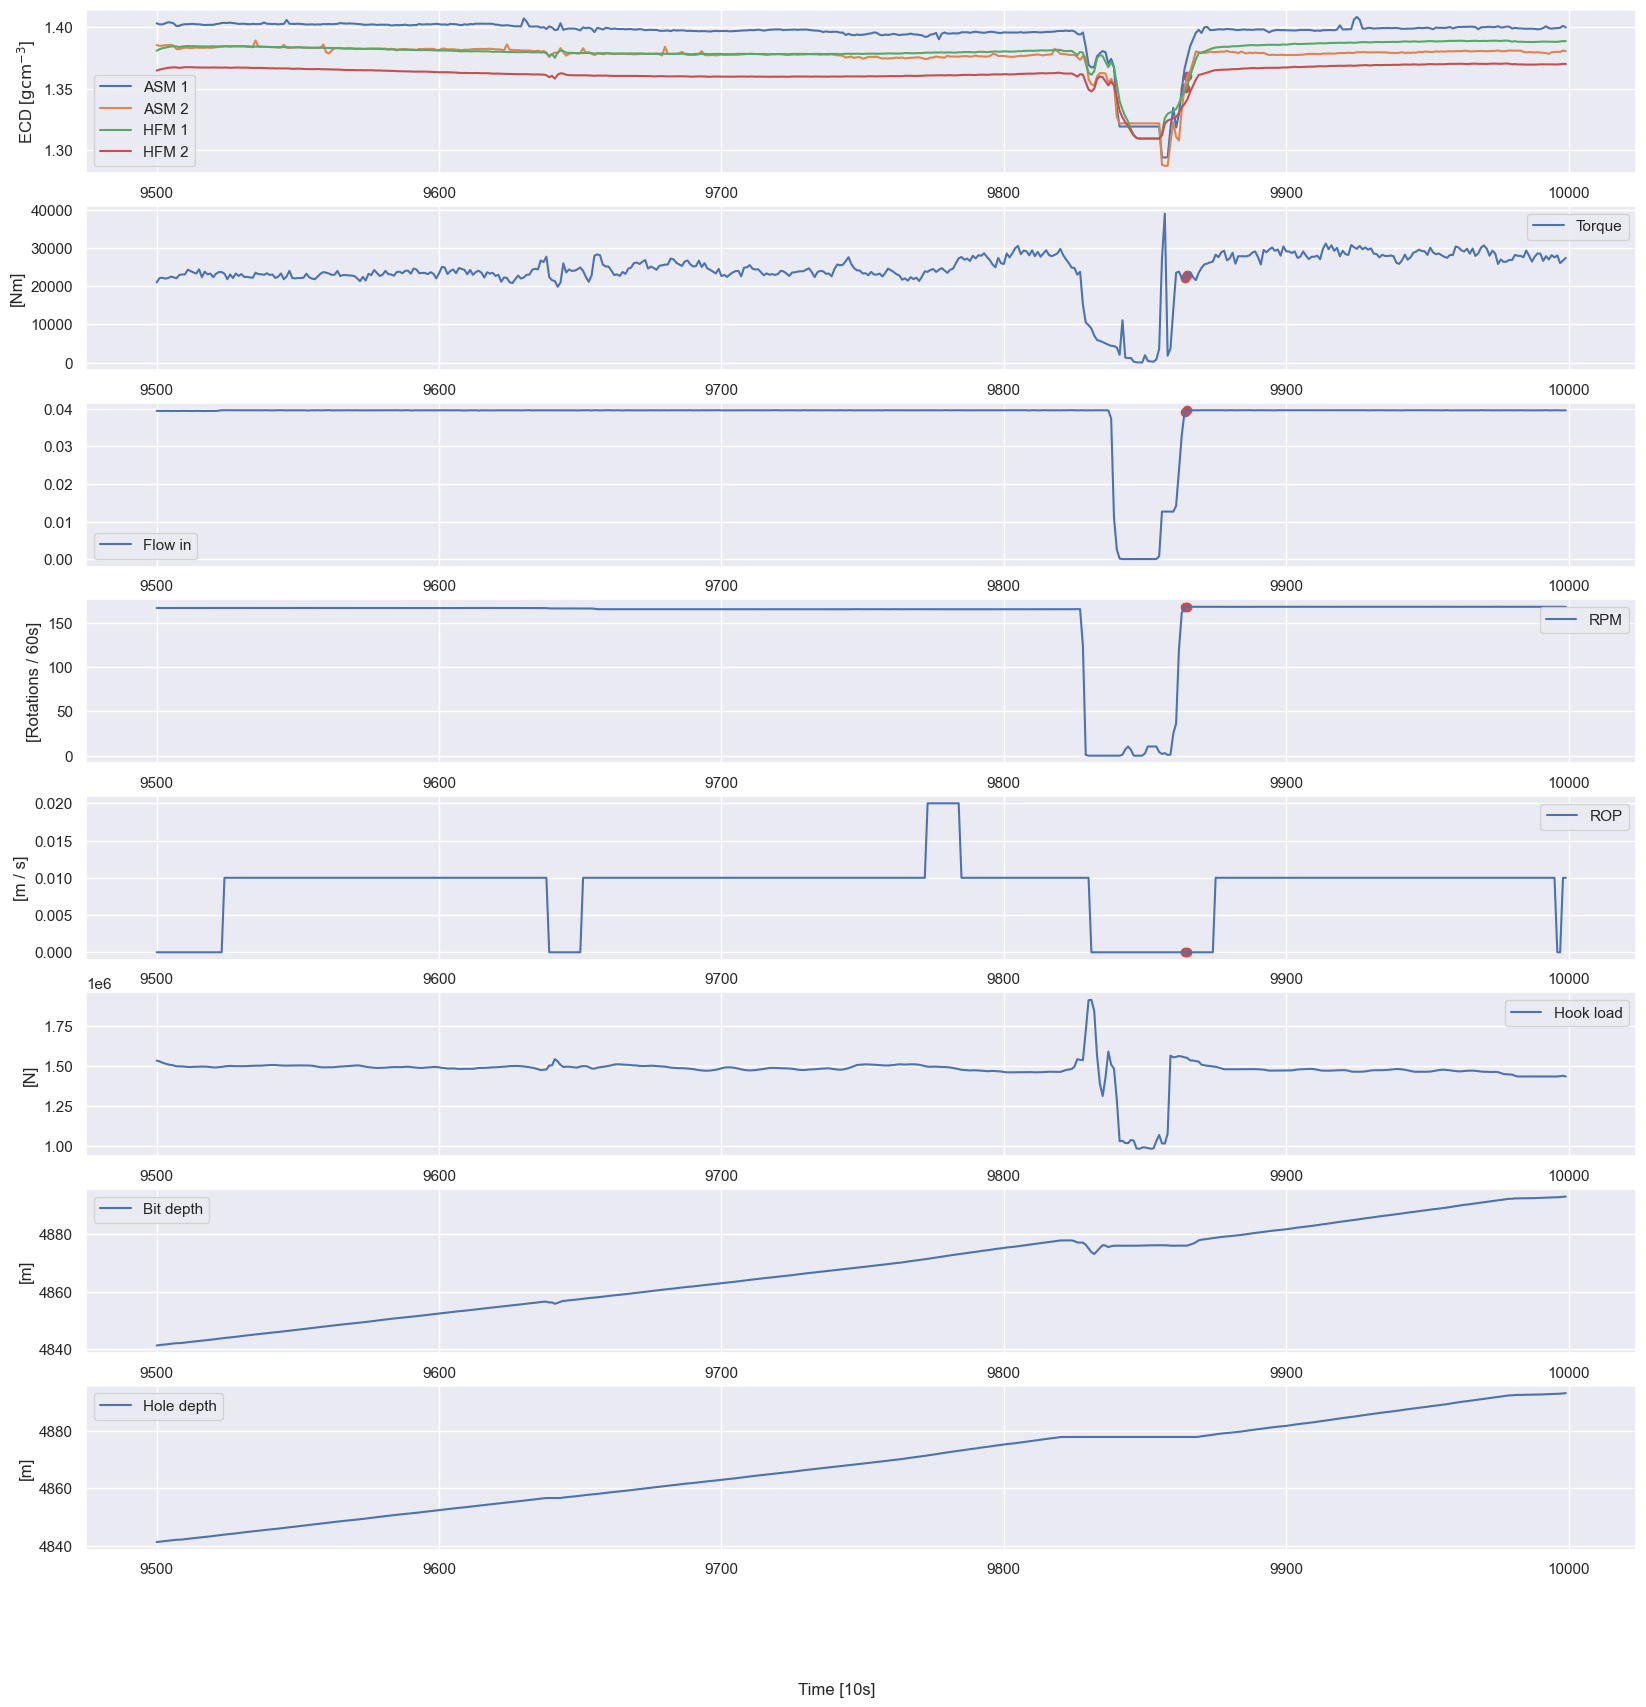

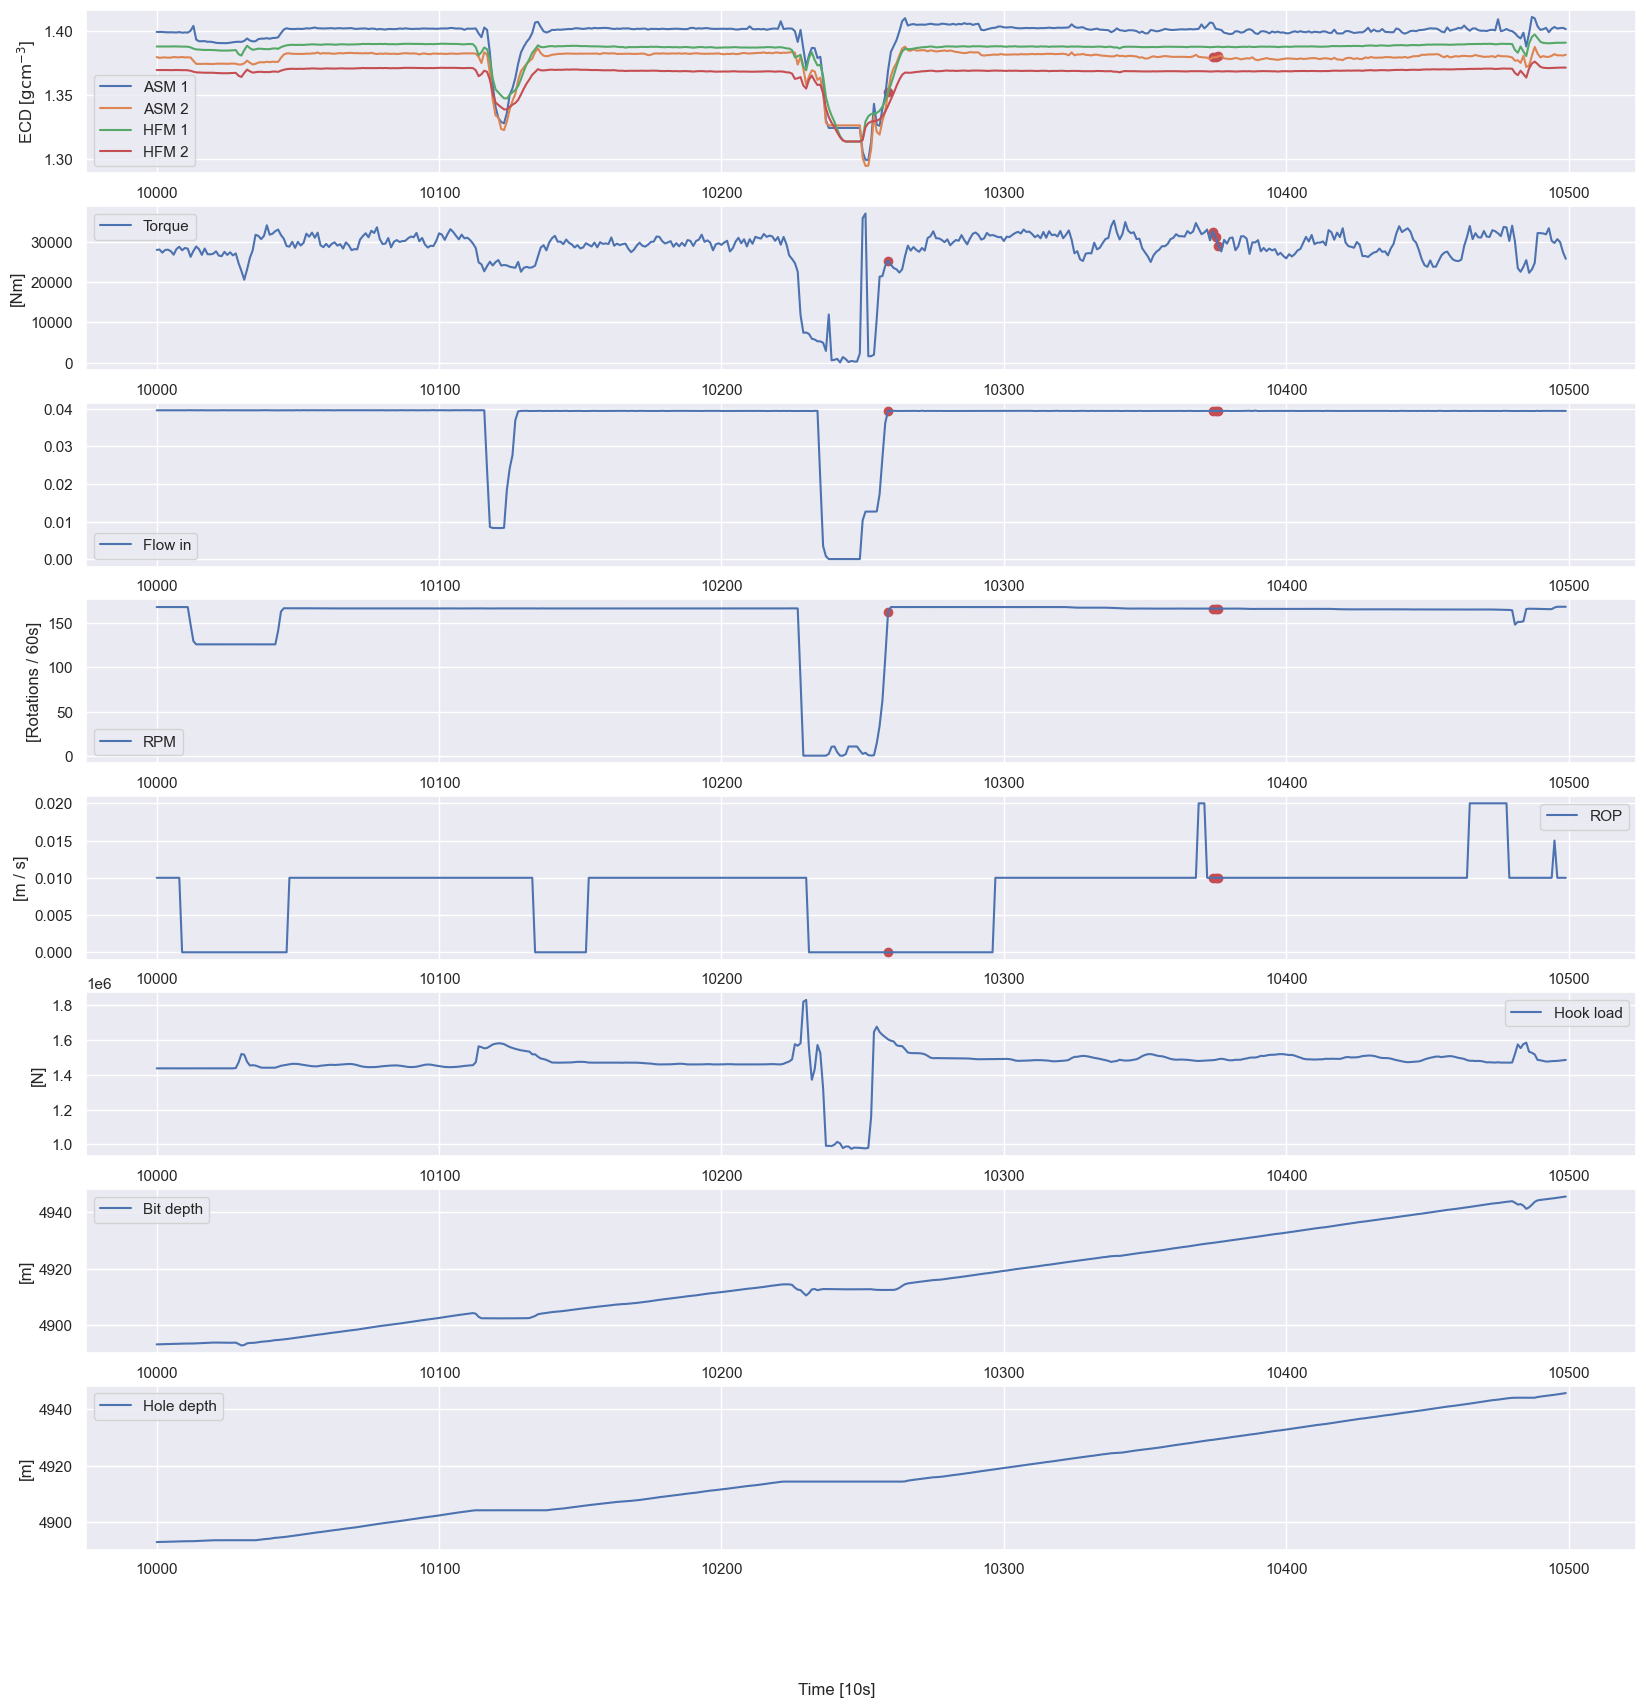

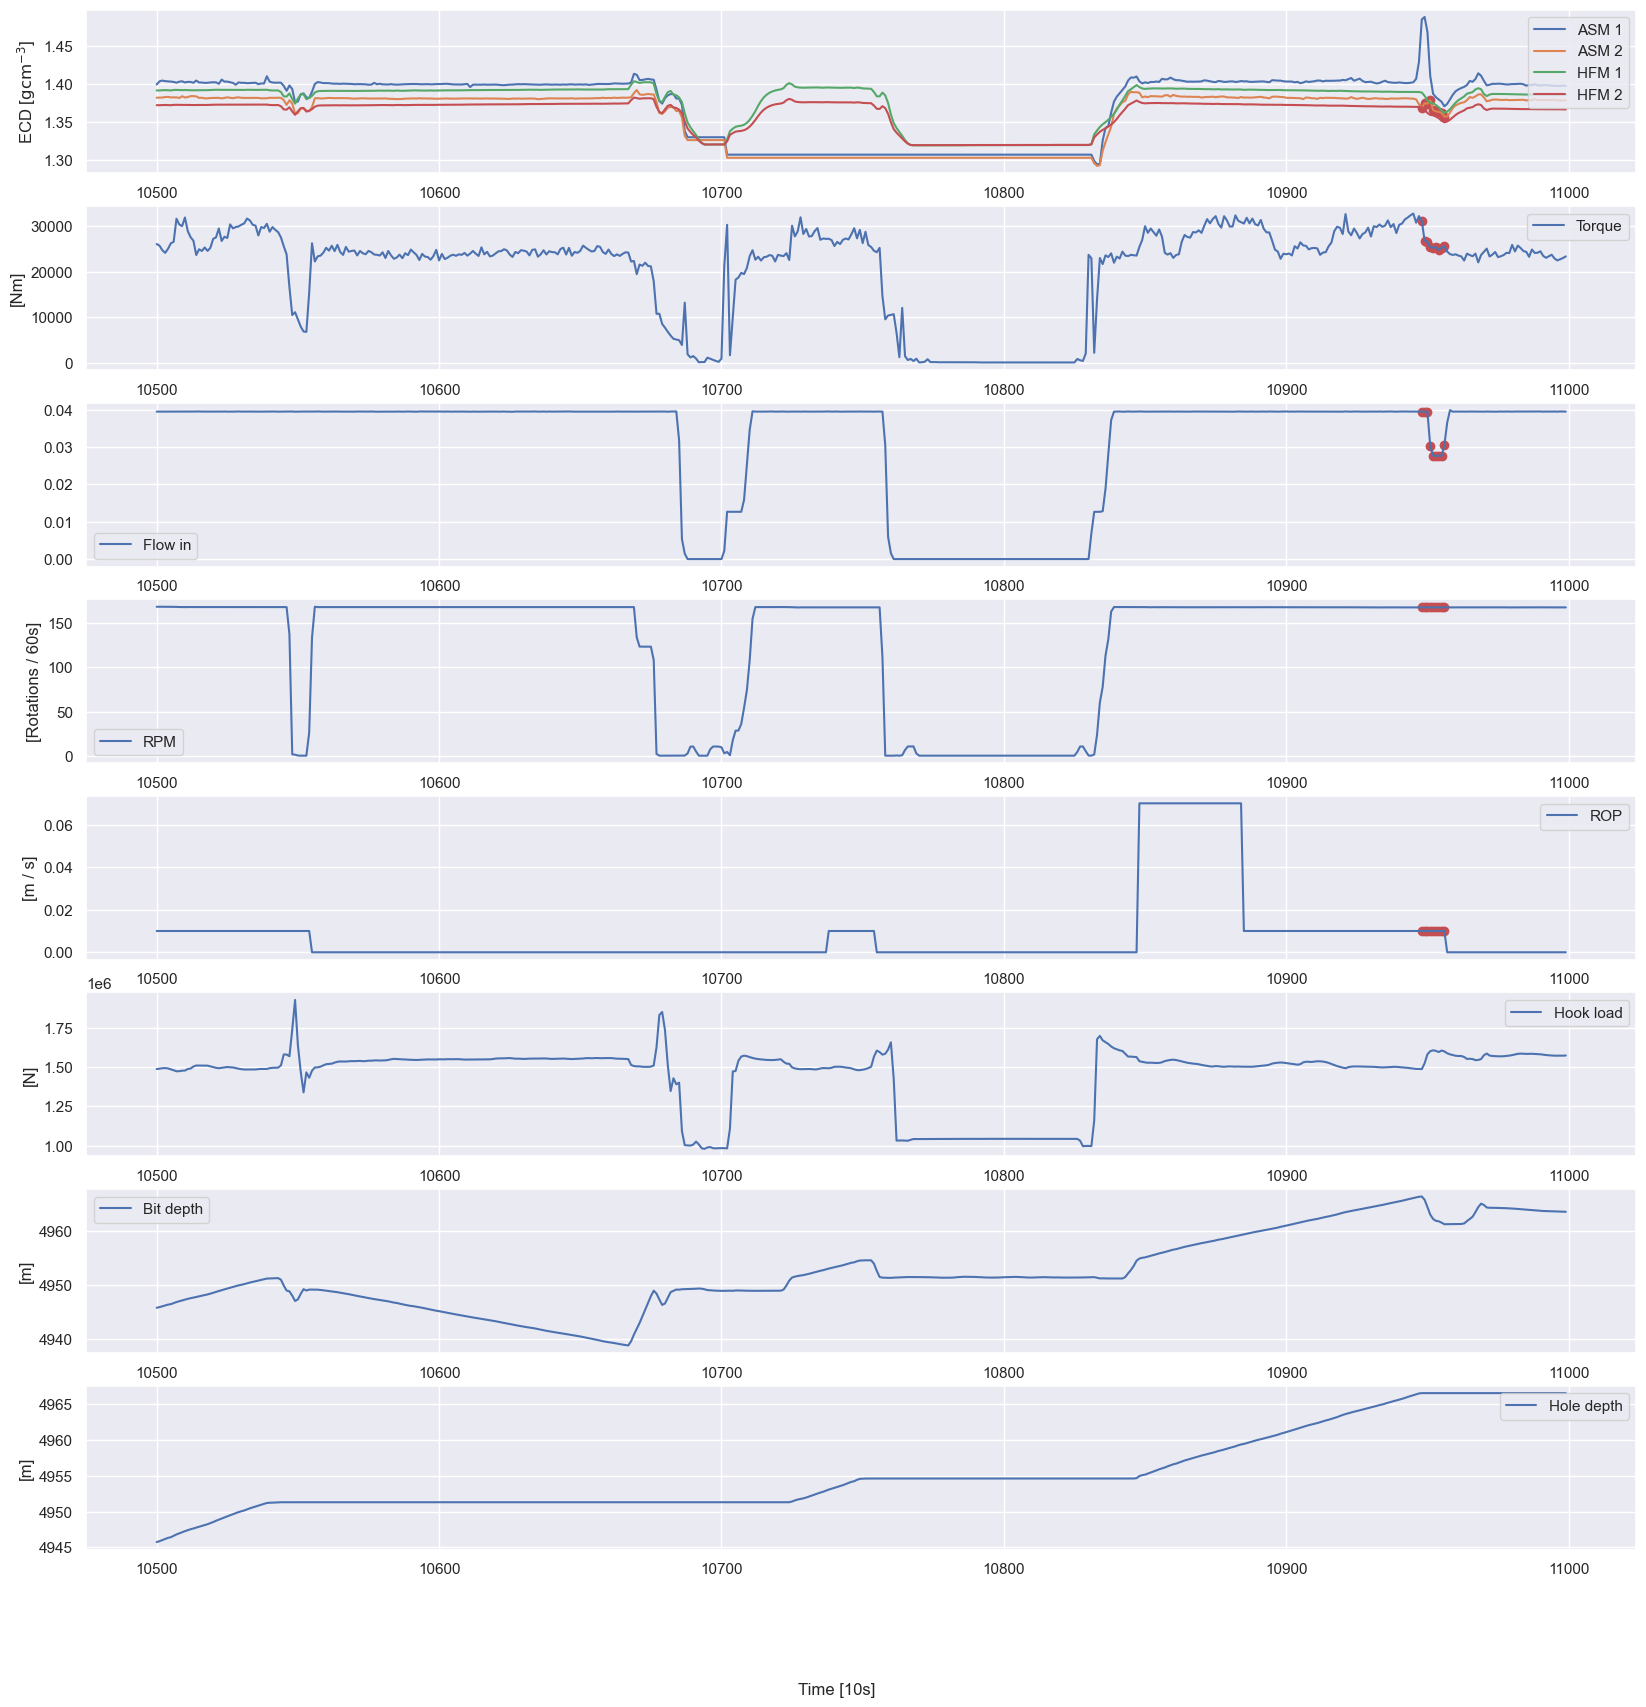

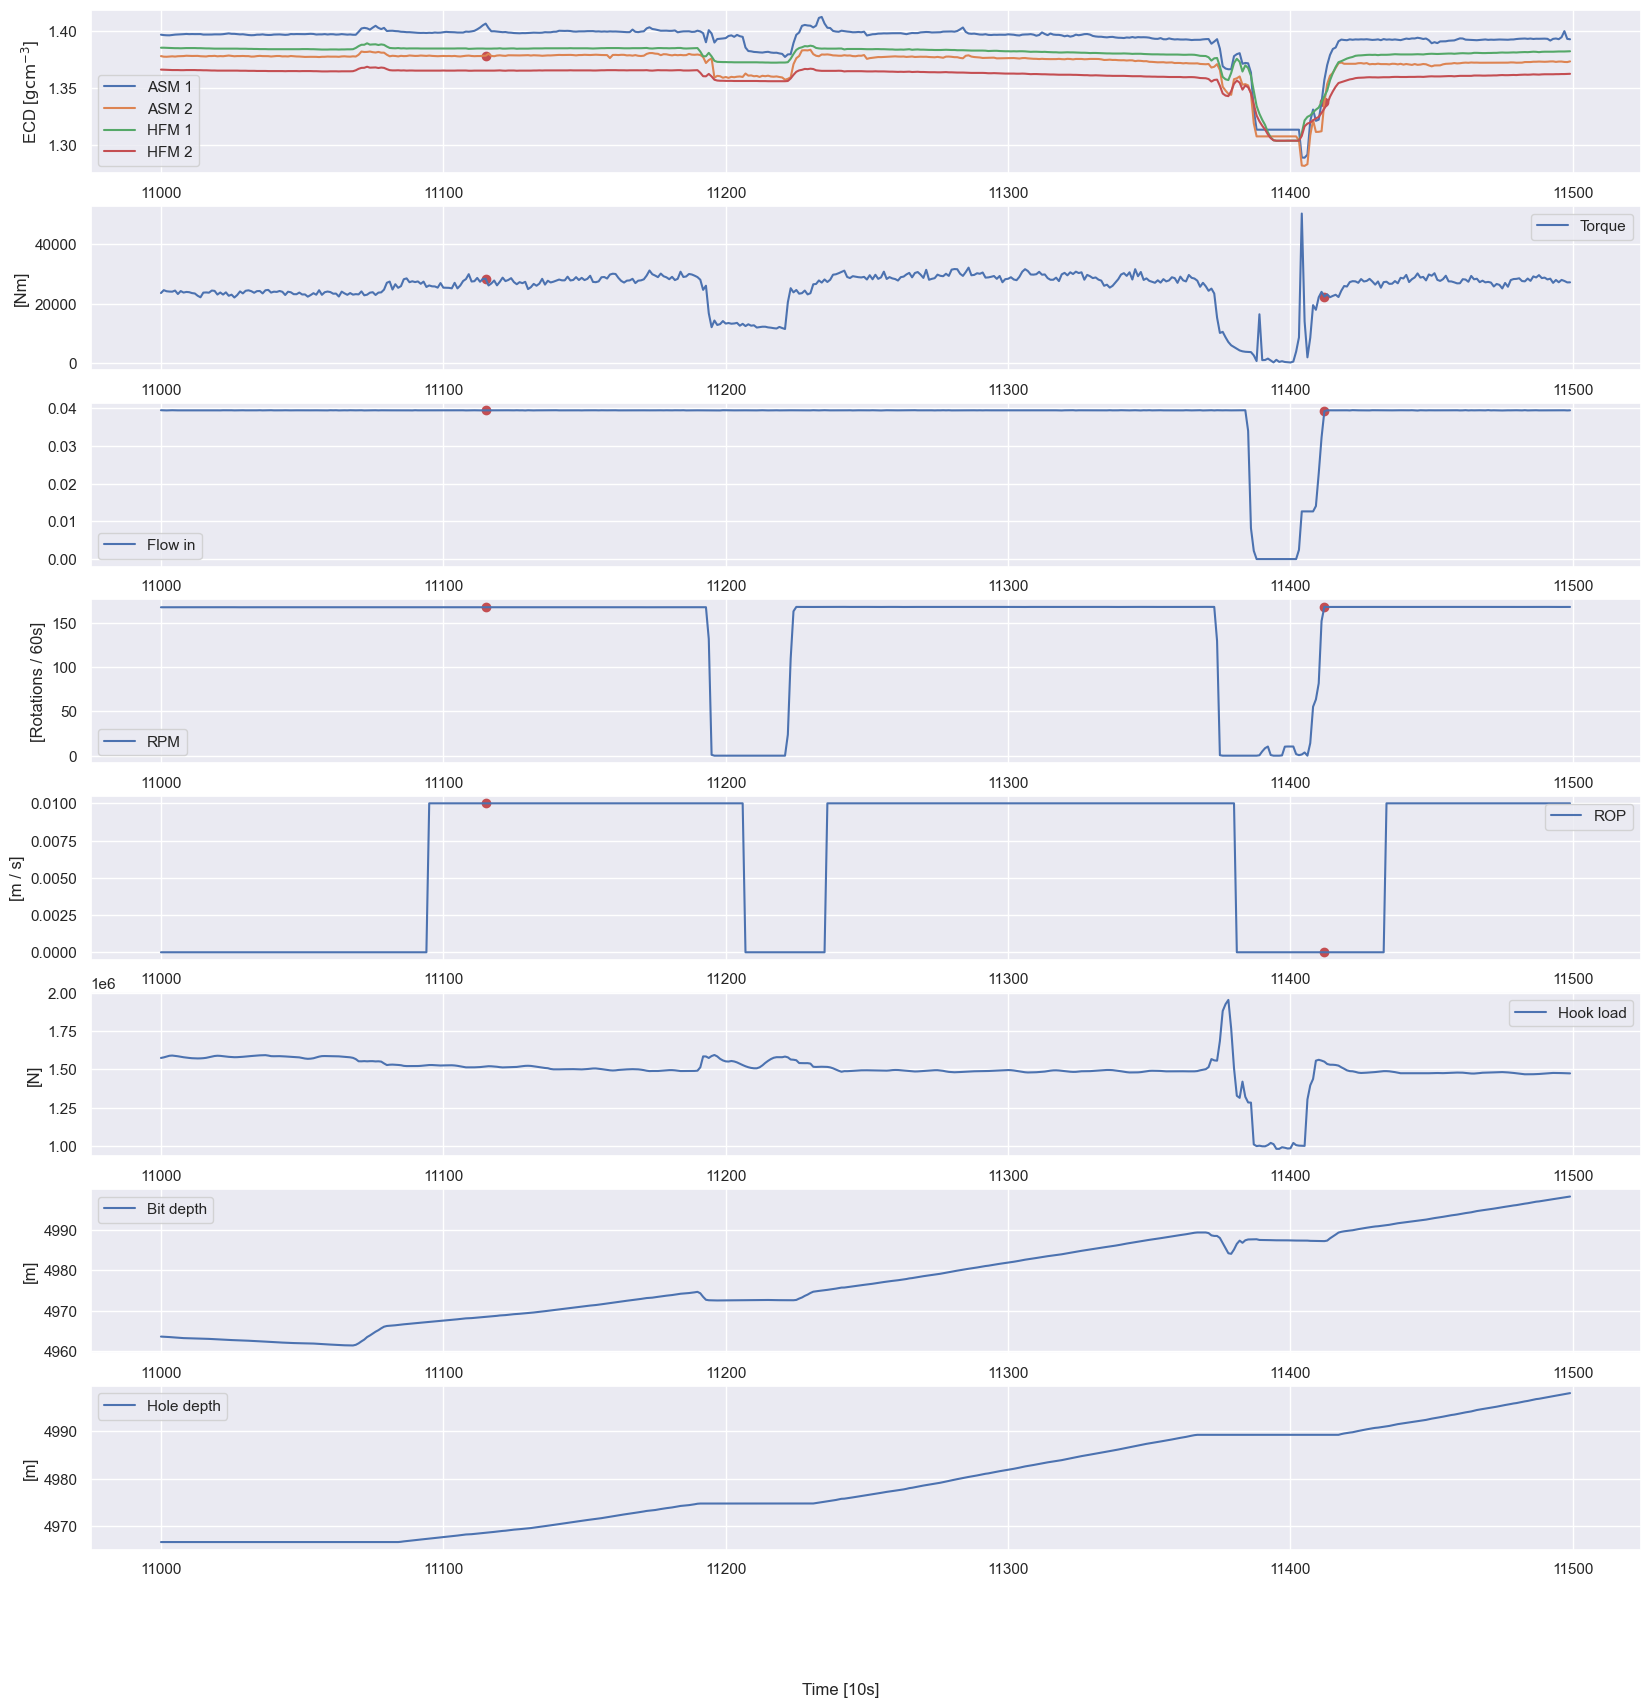

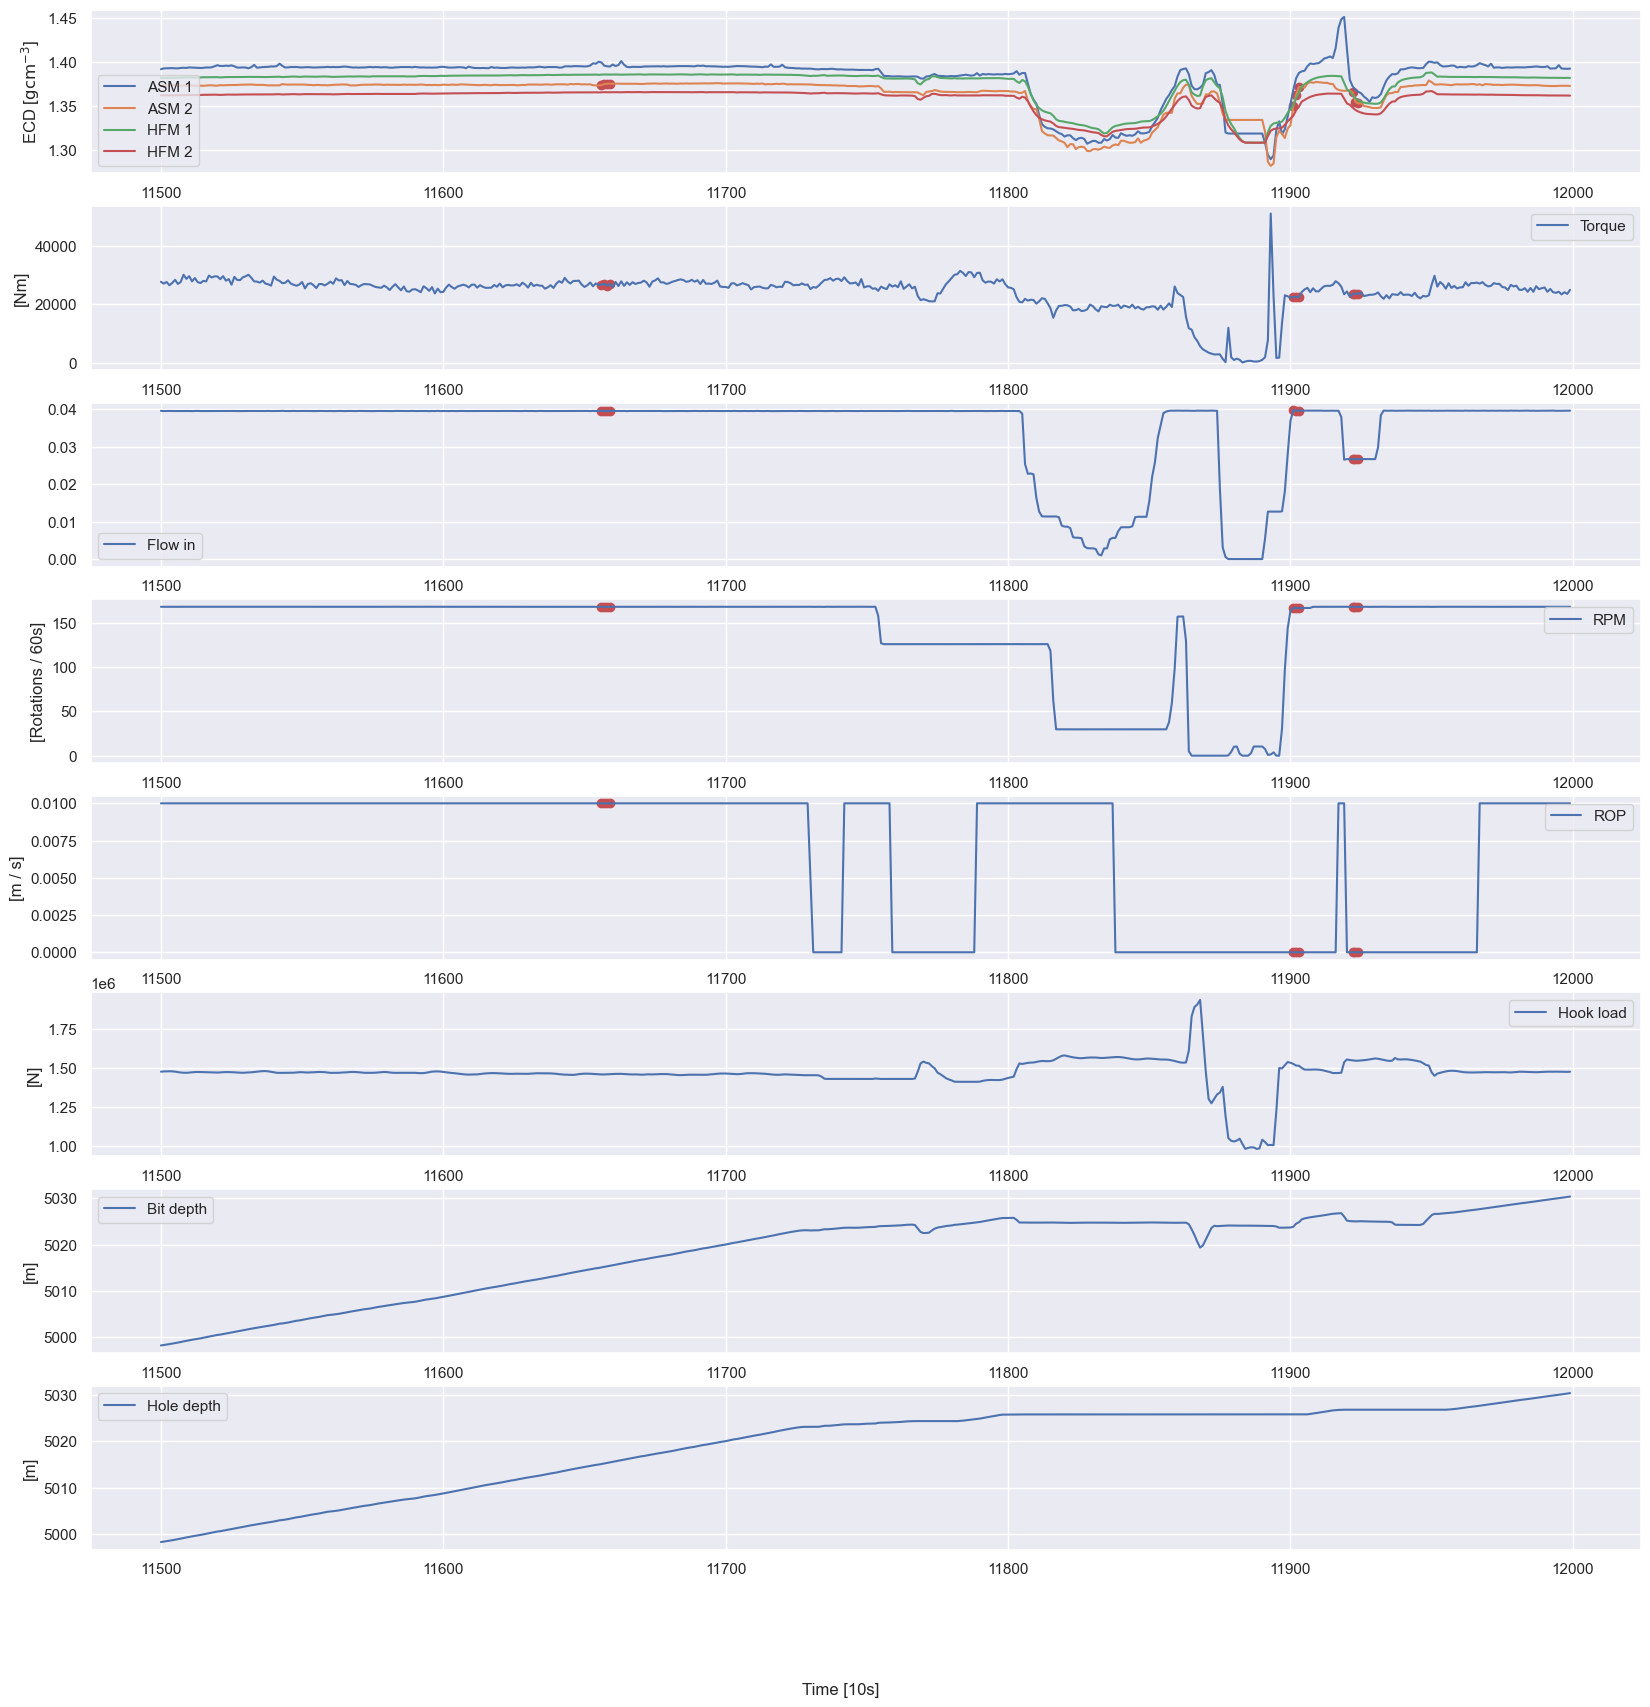

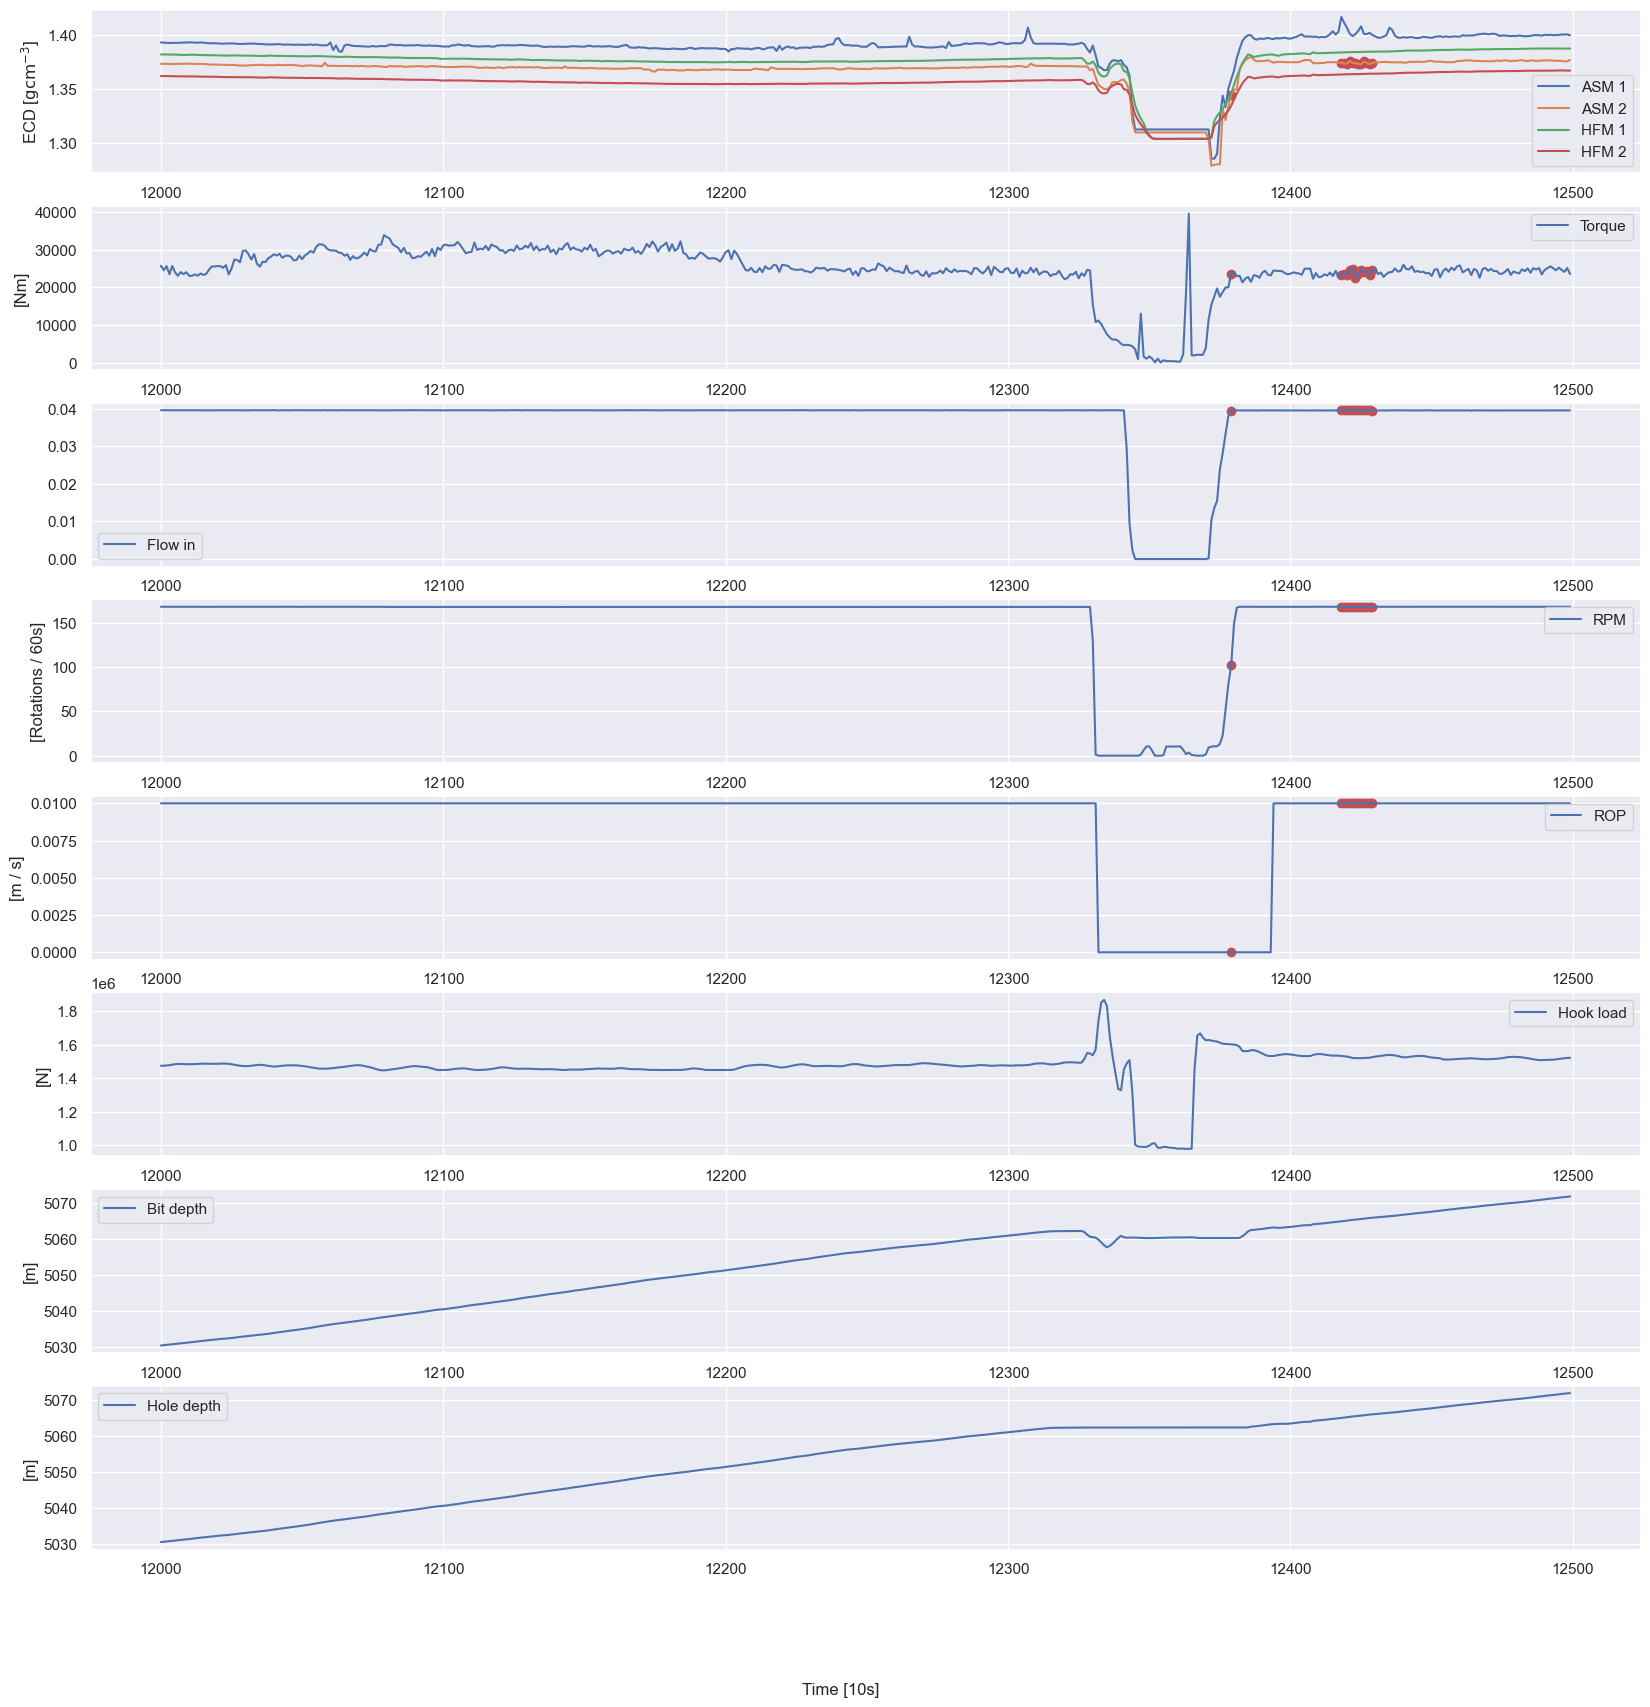

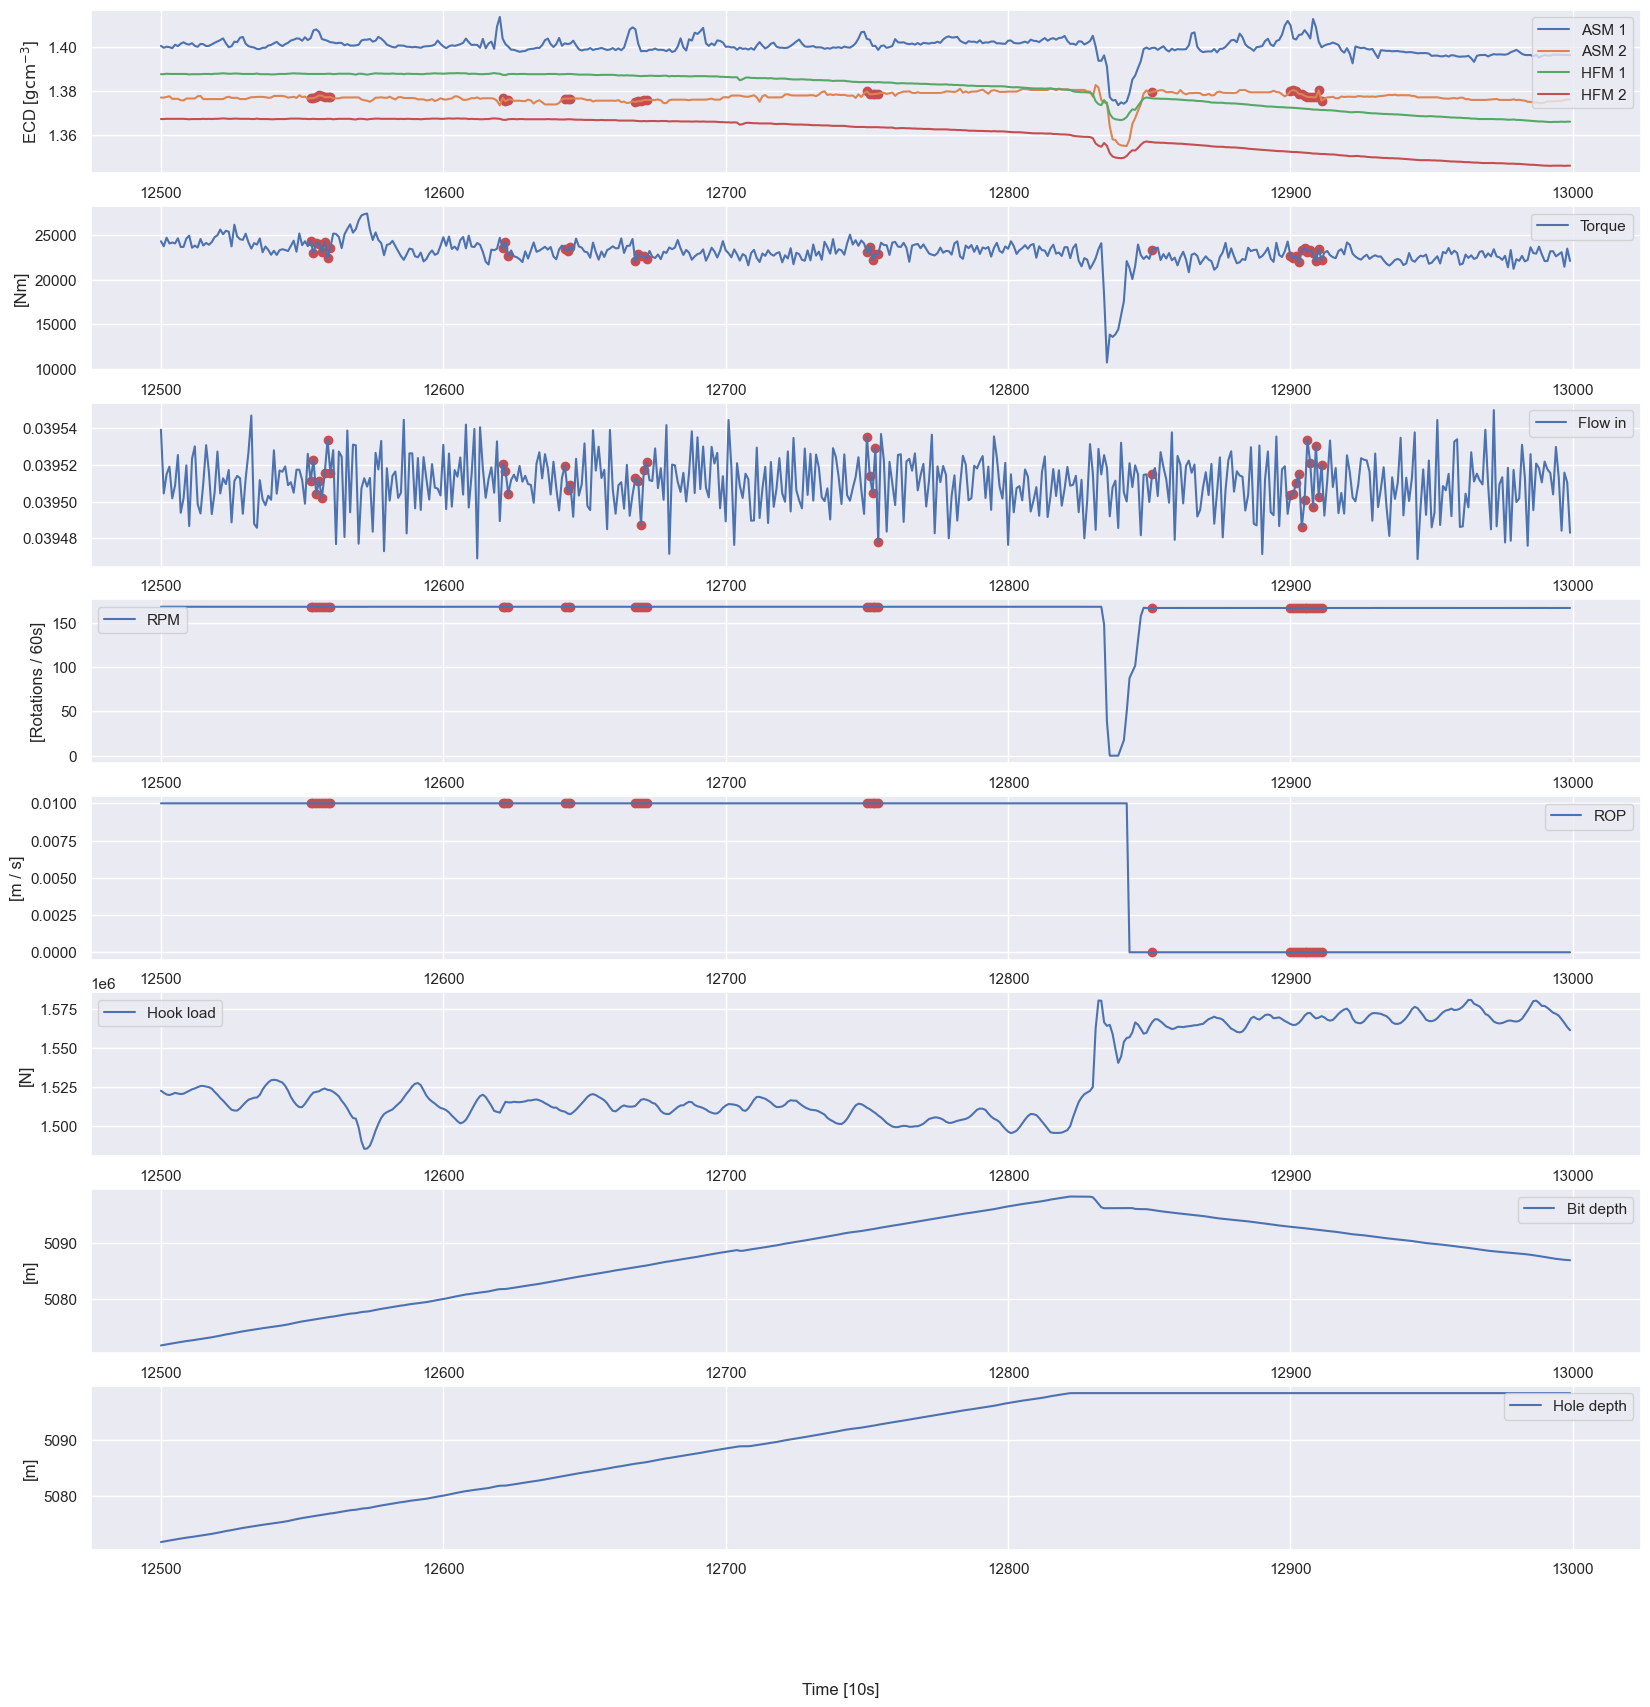

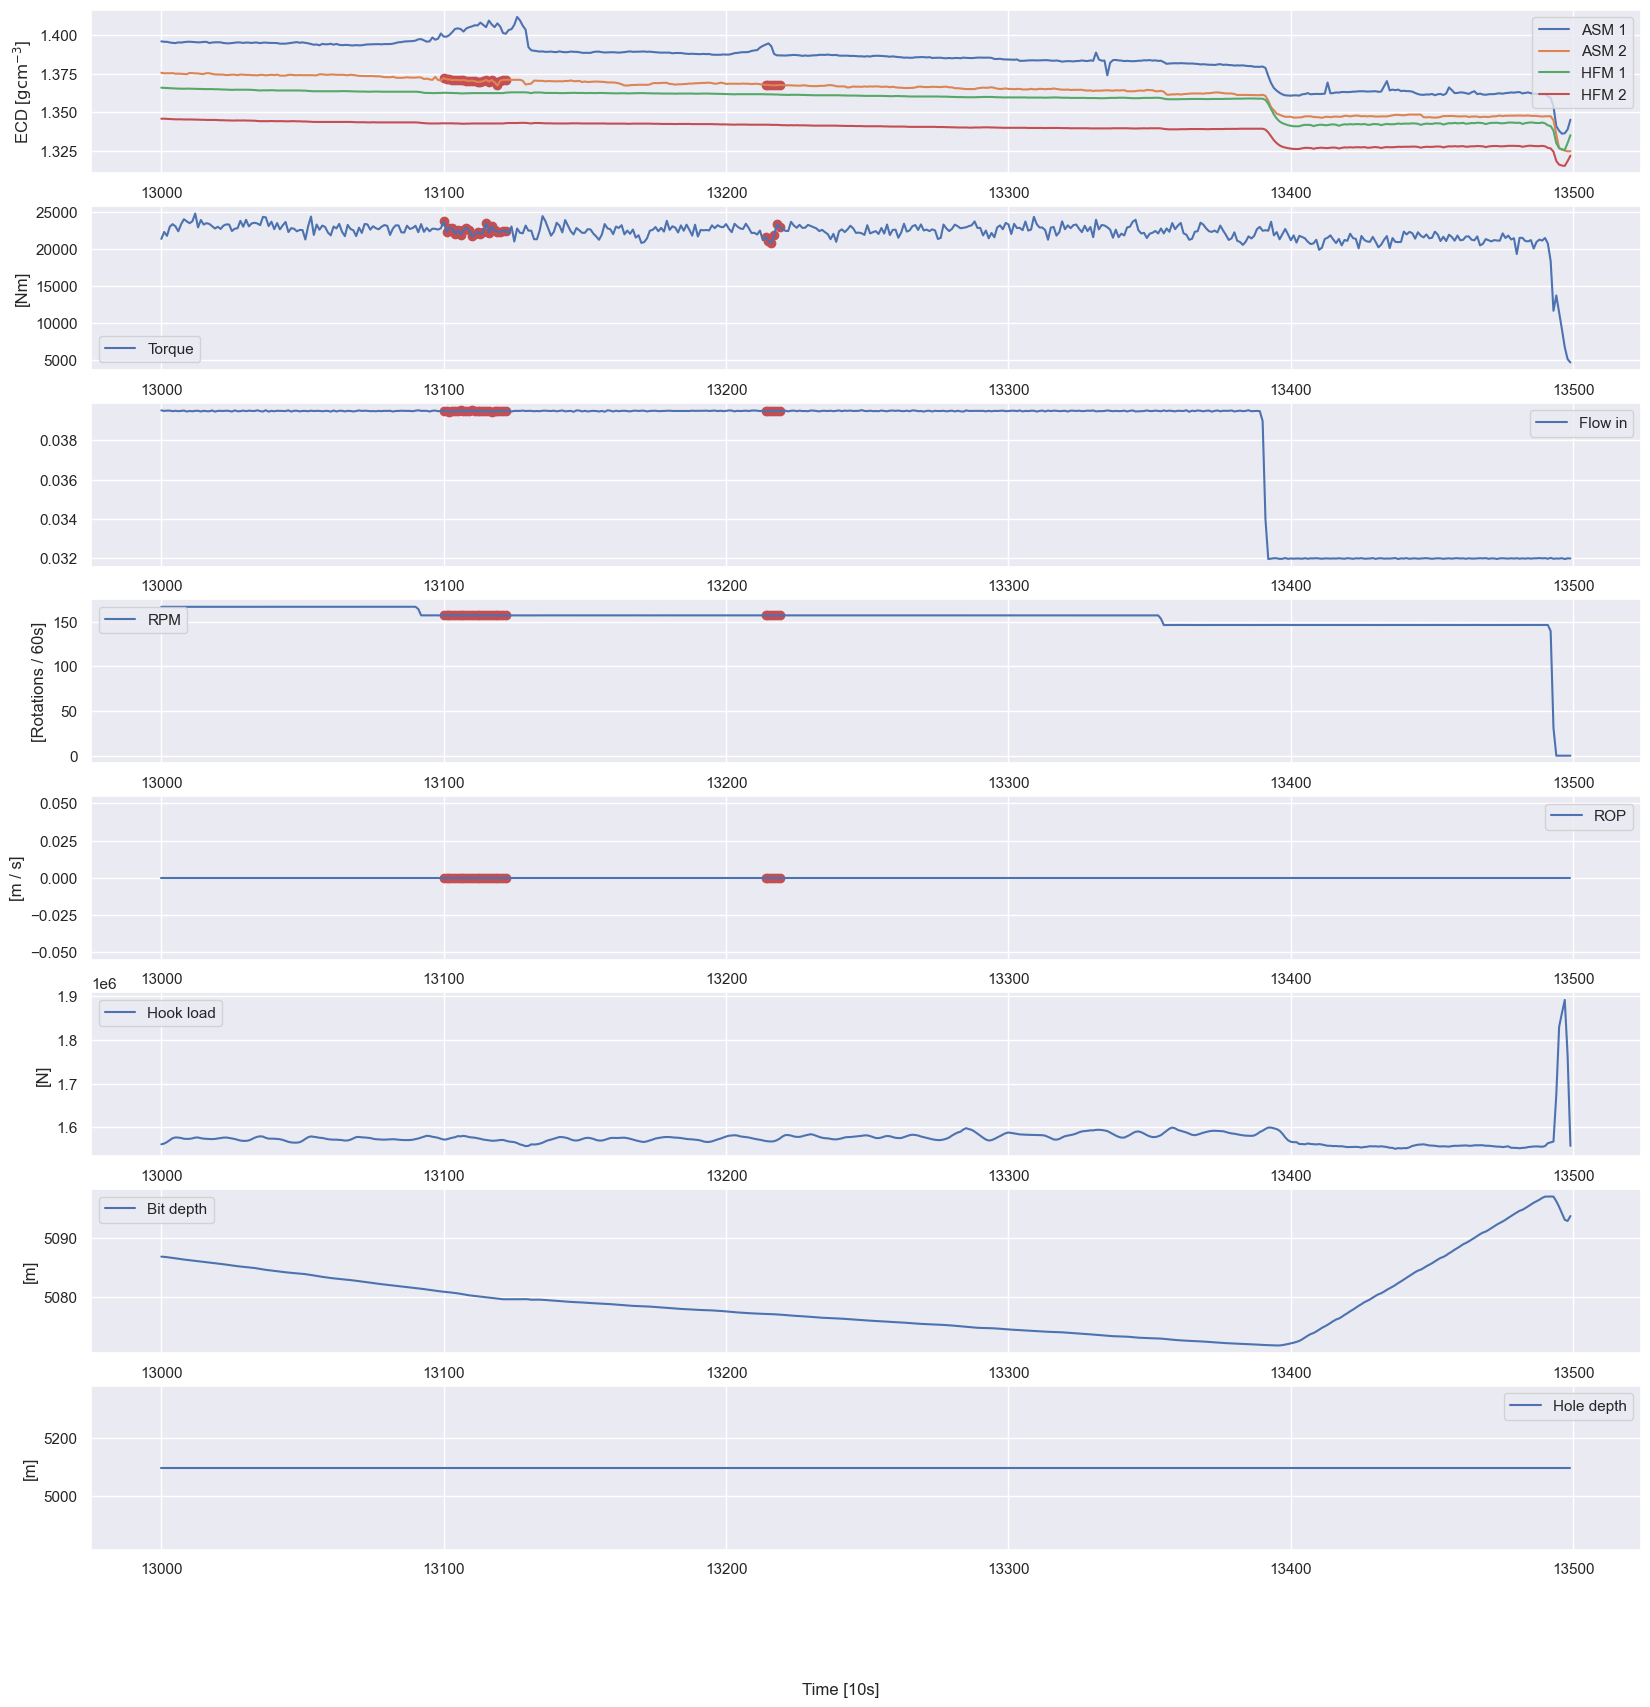

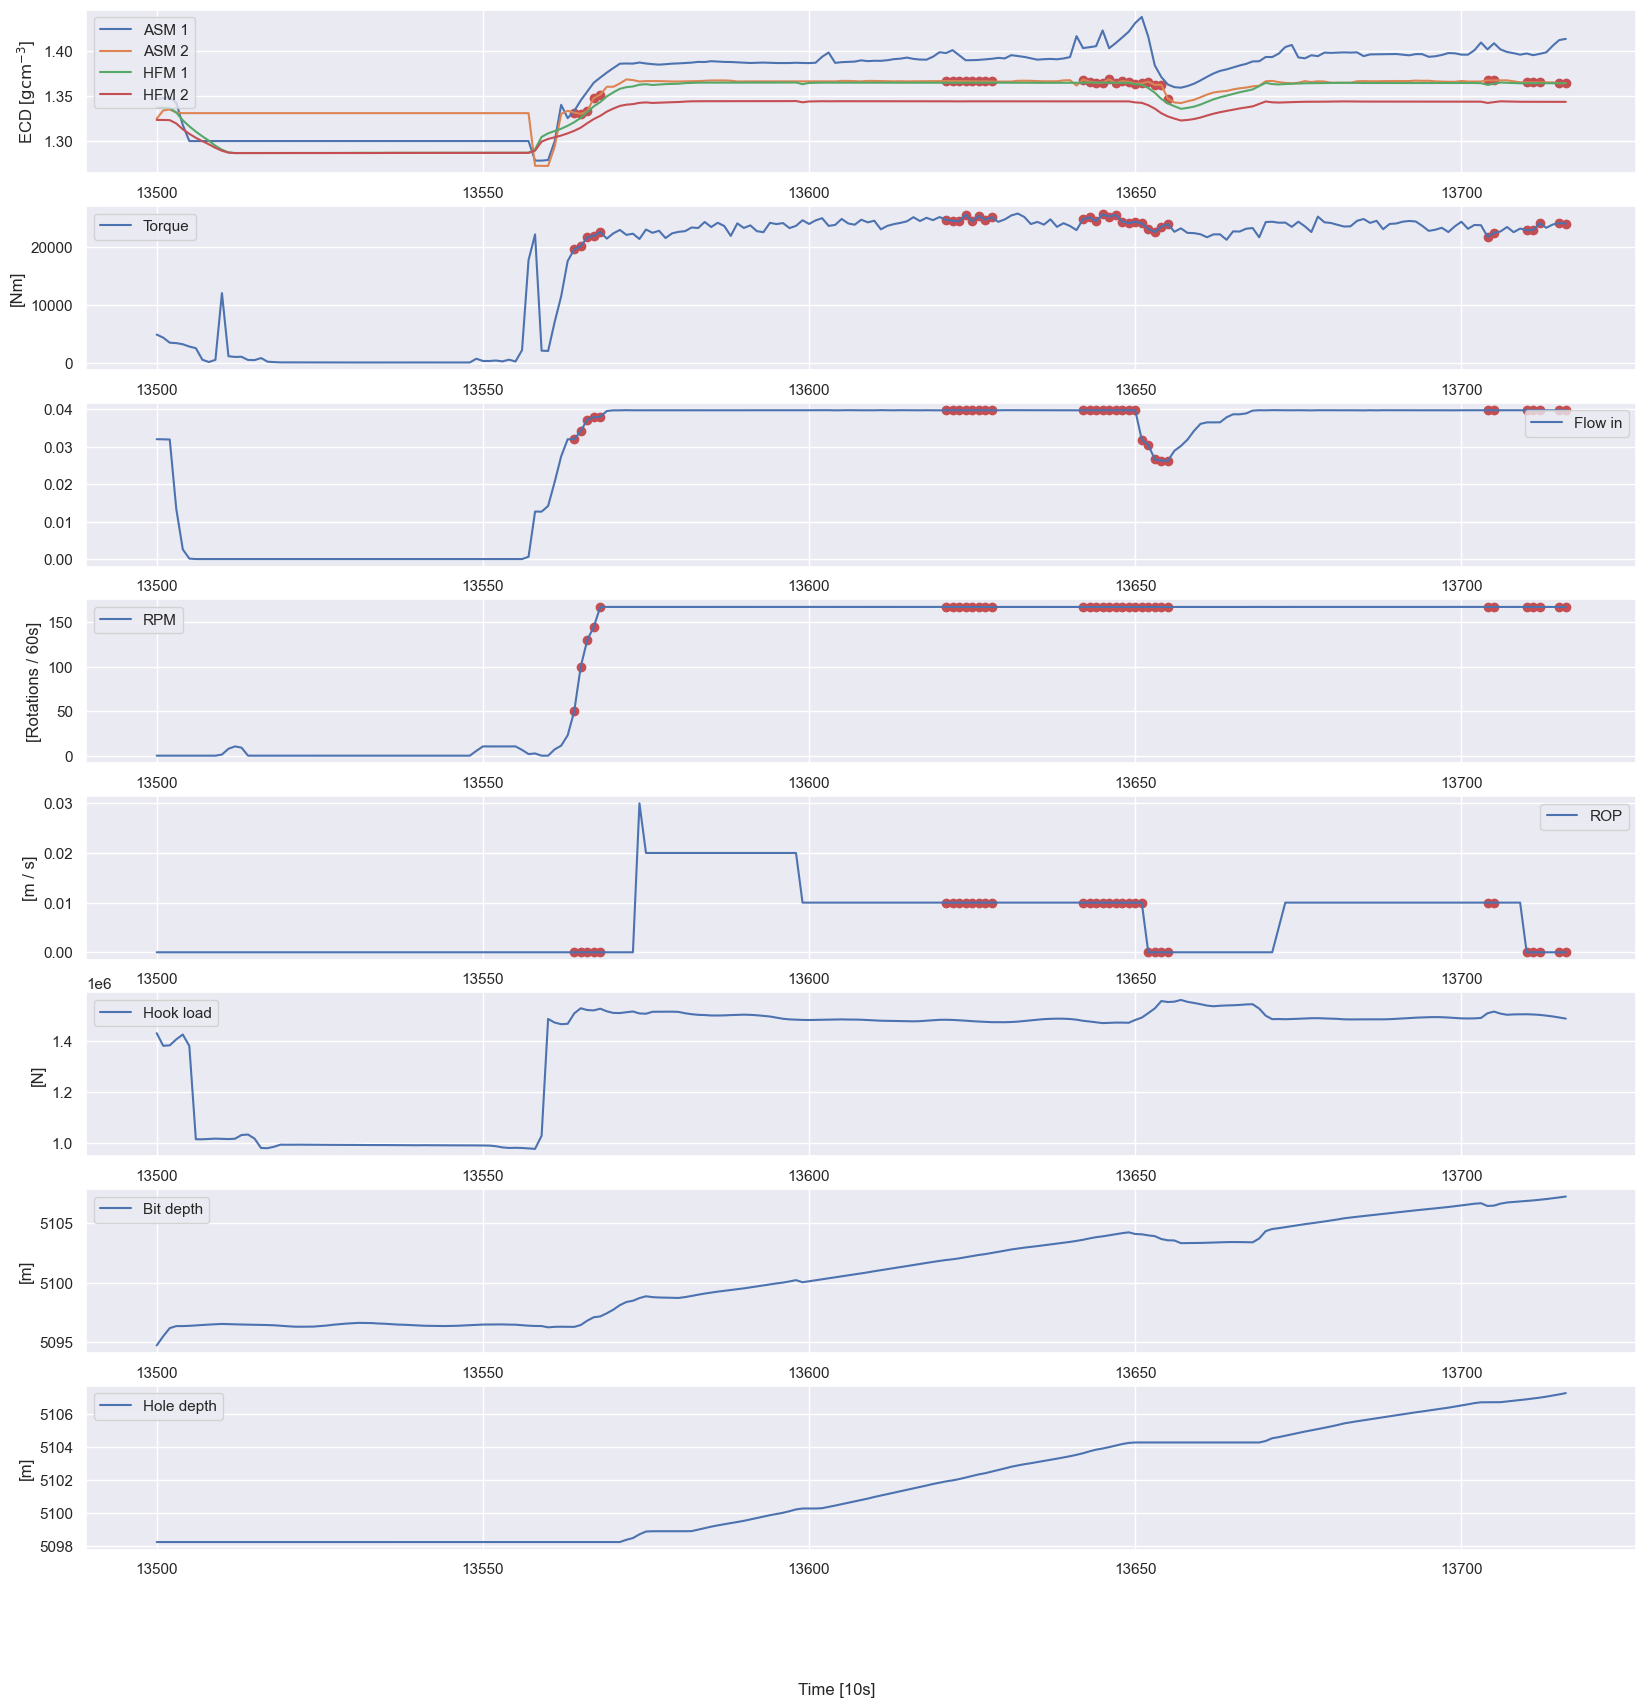

In [189]:
plot_with_warnings_pack_off_sensor_1_2(df_input=df_sensor, df_sim = df_simulated, warnings = warnings_linreg,chunk_size=500)